<a href="https://colab.research.google.com/github/hyunshoon/bitcoin_price_prediction_with_SNS_sentiment/blob/main/build_base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting


In [1]:
!pip install finance-datareader


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 3.1 MB/s 


In [2]:
import sys, os
import tempfile, urllib, zipfile
import math
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from google.colab import drive
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.utils import np_utils

import FinanceDataReader as fdr

import tensorflow as tf
%matplotlib inline

In [3]:
drive.mount('/content/drive')
path_capstone = '/content/drive/MyDrive/Colab Notebooks/capstone/data/'

Mounted at /content/drive


# Data load

In [4]:
hist = fdr.DataReader('BTC/USD')
hist

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,80.0,0.0000
2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0000
2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0000
2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0000
2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0000
...,...,...,...,...,...,...
2022-05-27,28601.2,29194.0,29377.1,28282.2,116410.0,-0.0206
2022-05-28,29027.1,28620.1,29194.4,28537.2,43870.0,0.0149
2022-05-29,29465.2,29027.1,29556.5,28838.7,36870.0,0.0151


#Price data pre-porcessing

In [5]:
def make_price_features(hist):
  #Make Features based price data
  hist['diff'] = hist['Close'] - hist.shift(1)['Close']
  hist['direction'] = 0
  hist['fluct'] = (hist['Close'] - hist.shift(1)['Close'])/hist.shift(1)['Close'] *100
  hist['EMA_short_price'] = hist.Close.ewm(span = 12).mean()
  hist['EMA_long_price'] = hist.Close.ewm(span = 26).mean()
  hist['MACD_price'] = hist.EMA_short_price - hist.EMA_long_price
  hist['MACD_Signal_price'] = hist['MACD_price'].rolling(window=9, min_periods=1).mean()
  hist['MACD_OSC_price'] = hist.MACD_price - hist.MACD_Signal_price

  hist = hist.dropna(axis=0)
  return hist

In [6]:
train_ratio = 0.8
val_ratio = 0.2

train, val = train_test_split(hist, test_size = 1 - train_ratio, shuffle = False)

Train, test 가격 데이터의 패턴이 많이 다르다

In [7]:
hist = make_price_features(hist)
hist

,Close,Open,High,Low,Volume,Change,diff,direction,fluct,EMA_short_price,EMA_long_price,MACD_price,MACD_Signal_price,MACD_OSC_price
Date,,,,,,,,,,,,,,
2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0000,0.0,0,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000
2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0000,0.0,0,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000
2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0000,0.0,0,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000
2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0000,0.0,0,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000
2010-07-23,0.1,0.1,0.1,0.1,2400.0,0.0000,0.0,0,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27,28601.2,29194.0,29377.1,28282.2,116410.0,-0.0206,-602.3,0,-2.062424,29758.752112,31704.032480,-1945.280368,-2281.407605,336.127237
2022-05-28,29027.1,28620.1,29194.4,28537.2,43870.0,0.0149,425.9,0,1.489098,29646.190248,31505.741185,-1859.550936,-2195.181344,335.630408
2022-05-29,29465.2,29027.1,29556.5,28838.7,36870.0,0.0151,438.1,0,1.509279,29618.345595,31354.589986,-1736.244391,-2100.068548,363.824157


In [8]:
def line_plot(line1, line2,  label1, label2,  title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

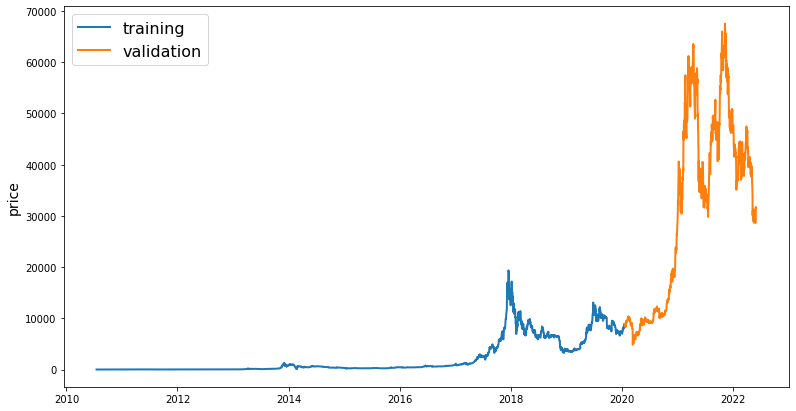

In [9]:
line_plot(train['Close'], val['Close'], 'training', 'validation', title='')

# Model & Experiment

## Model

In [10]:
class Crypto:
  test_size = 0.2
  zero_base = True
  lstm_neurons = 100
  epochs = 30
  batch_size = 32
  loss = 'binary_crossentropy'
  dropout = 0.2
  optimizer = 'adam'
  def __init__(self, window, col):
    self.window_len = window
    self.eval = []
    self.hist = price[col]
    # self.hist = price.drop(columns=drop_col, axis=0)


  def extract_window_data(self, df, window_len, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)


  def prepare_data_classification(self, df, target_col, window_len=5, zero_base=True, test_size=0.2):
      train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
      X_train = self.extract_window_data(train_data, window_len, zero_base)
      X_test = self.extract_window_data(test_data, window_len, zero_base)
      y_train = train_data[target_col][window_len:].values#ori
      y_test = test_data[target_col][window_len:].values#ori

      return  X_train, X_test, y_train, y_test


  def build_lstm_model(self, input_data, neurons=100, activ_func='tanh',
                      dropout=0.2, loss='binary_crossentropy', optimizer='adam'):
      model = Sequential()
      model.add(LSTM(200, input_shape=(input_data.shape[1], input_data.shape[2])))
      model.add(Activation(activ_func))
      model.add(Dropout(dropout))
      # model.add(Dense(50, activation=activ_func))
      model.add(Dense(units=1))
      model.add(Activation('sigmoid'))
      # model.add(Activation('softmax'))
      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
      return model

  def data_set(self):
      self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data_classification(
          self.hist, target_col, window_len=self.window_len, zero_base=self.zero_base, test_size=self.test_size)


  def train_model(self):
    early_stopping = EarlyStopping(monitor = 'val_loss', patience=50)
    self.model = self.build_lstm_model(
        self.X_train,neurons=self.lstm_neurons, dropout=self.dropout, loss=self.loss,
        optimizer=self.optimizer)
    self.history = self.model.fit(
        self.X_train, self.y_train, validation_data=(self.X_test, self.y_test), epochs=self.epochs, batch_size = self.batch_size, verbose=1, shuffle=True,
        callbacks=[early_stopping])
    print(self.model.summary())
  
  def evaluate(self):
    self.train_model()
    self.preds = self.model.predict(self.X_test).squeeze()
    self.preds_X = self.model.predict(self.X_train).squeeze()
    scores = self.model.evaluate(self.X_test, self.y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

  def conditions(self):
    return self.hist.columns, 'dropout:',self.dropout, 'window_size:', self.window_len


## Experiment

### Base model


In [11]:
price = make_price_features(hist[1200:])
for i in range(len(price)):
  if price.iloc[i, 6]>0:#diff
    price.iloc[i, 7] = 1 # direction
  else:
    price.iloc[i, 7] = -1
price.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Close,Open,High,Low,Volume,Change,diff,direction,fluct,EMA_short_price,EMA_long_price,MACD_price,MACD_Signal_price,MACD_OSC_price
Date,,,,,,,,,,,,,,
2013-11-07,309.6,264.1,324.2,263.6,86130.0,0.1725,45.5,1,17.228323,288.745833,287.725000,1.020833,0.510417,0.510417
2013-11-08,355.0,309.6,358.0,308.0,44630.0,0.1465,45.4,1,14.664083,314.604850,311.896254,2.708596,1.243143,1.465453
2013-11-09,367.8,355.0,395.0,340.0,49910.0,0.0360,12.8,1,3.605634,331.396480,327.524499,3.871981,1.900353,1.971629
2013-11-10,336.3,367.8,372.5,290.0,74250.0,-0.0856,-31.5,-1,-8.564437,332.728749,329.559574,3.169175,2.154117,1.015058
2013-11-11,363.0,336.3,376.0,321.4,18000.0,0.0793,26.7,1,7.939340,340.086255,336.257424,3.828831,2.433236,1.395595


In [14]:
target_col = 'direction'

features = ['Open', 'High', 'Low', 'Close', 'MACD_OSC_price', 'direction']
price.dropna(inplace = True)
scaler = MinMaxScaler()
price[features] = scaler.fit_transform(price[features])

In [13]:
#ohlc + MACD_OSC_price
window_size = 14

crypto_obj = Crypto(window_size, features)
crypto_obj.data_set()

crypto_obj.evaluate()

condition = crypto_obj.conditions()

print(condition)

Epoch 1/30
78/78 [==============================] - 9s 12ms/step - loss: 0.6927 - accuracy: 0.5269 - val_loss: 0.6930 - val_accuracy: 0.5245
Epoch 2/30
78/78 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5265 - val_loss: 0.6966 - val_accuracy: 0.5163
Epoch 3/30
78/78 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5309 - val_loss: 0.6910 - val_accuracy: 0.5278
Epoch 4/30
78/78 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.5297 - val_loss: 0.6952 - val_accuracy: 0.4935
Epoch 5/30
78/78 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5309 - val_loss: 0.6902 - val_accuracy: 0.5523
Epoch 6/30
78/78 [==============================] - 0s 5ms/step - loss: 0.6893 - accuracy: 0.5326 - val_loss: 0.6943 - val_accuracy: 0.4804
Epoch 7/30
78/78 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.5265 - val_loss: 0.7024 - val_accuracy: 0.4771
Epoch 8/30
78/78 [=

# Hyperparameter tunning with W&B

## setting

In [15]:
%pip install -q wandb
import wandb

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 181 kB 69.5 MB/s 
     |████████████████████████████████| 145 kB 71.7 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

In [ ]:
class data_preparation:
  test_size = 0.2
  zero_base = True
  def __init__(self, window, features):
    self.window_len = window
    self.hist = price[features]

  def extract_window_data(self, df, window_len, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)


  def prepare_data_classification(self, df, target_col, window_len=5, zero_base=True, test_size=0.2):
      train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
      X_train = self.extract_window_data(train_data, window_len, zero_base)
      X_test = self.extract_window_data(test_data, window_len, zero_base)
      y_train = train_data[target_col][window_len:].values#ori
      y_test = test_data[target_col][window_len:].values#ori

      return  X_train, X_test, y_train, y_test



  def data_set(self):
      self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data_classification(
          self.hist, target_col, window_len=self.window_len, zero_base=self.zero_base, test_size=self.test_size)
      return self.X_train, self.X_test, self.y_train, self.y_test

In [ ]:
price = price.loc['',:]

,Close,Open,High,Low,Volume,Change,diff,direction,fluct,EMA_short_price,EMA_long_price,MACD_price,MACD_Signal_price,MACD_OSC_price
Date,,,,,,,,,,,,,,
2013-11-07,0.002937,0.002262,0.002384,0.002595,86130.0,0.1725,45.5,1.0,17.228323,288.745833,287.725000,1.020833,0.510417,0.554668
2013-11-08,0.003610,0.002937,0.002875,0.003265,44630.0,0.1465,45.4,1.0,14.664083,314.604850,311.896254,2.708596,1.243143,0.554923
2013-11-09,0.003800,0.003610,0.003413,0.003748,49910.0,0.0360,12.8,1.0,3.605634,331.396480,327.524499,3.871981,1.900353,0.555058
2013-11-10,0.003333,0.003800,0.003086,0.002994,74250.0,-0.0856,-31.5,0.0,-8.564437,332.728749,329.559574,3.169175,2.154117,0.554803
2013-11-11,0.003729,0.003333,0.003137,0.003468,18000.0,0.0793,26.7,1.0,7.939340,340.086255,336.257424,3.828831,2.433236,0.554904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,0.447878,0.424059,0.441156,0.431598,101380.0,0.0566,1622.2,1.0,5.655477,31082.787075,33718.374356,-2635.587281,-2791.918070,0.596255
2022-05-20,0.431157,0.447873,0.444207,0.432449,98780.0,-0.0372,-1127.3,0.0,-3.719738,30789.835217,33382.094774,-2592.259557,-2792.549648,0.607988
2022-05-21,0.434954,0.431302,0.428053,0.435701,32270.0,0.0088,256.0,1.0,0.877355,30581.337492,33089.687754,-2508.350262,-2757.155715,0.620936


In [ ]:
price.iloc[403] #Name: 2014-12-15 00:00:00, dtype: float64

Close                    0.003468
Open                     0.003527
High                     0.002776
Low                      0.003803
Volume               22160.000000
Change                  -0.011400
diff                    -4.000000
direction                0.000000
fluct                   -1.144820
EMA_short_price        356.458887
EMA_long_price         362.659579
MACD_price              -6.200693
MACD_Signal_price       -2.733756
MACD_OSC_price           0.553606
Name: 2014-12-15 00:00:00, dtype: float64

In [ ]:
start = 403
train = price.iloc[start:start+1215]
val = price.iloc[start+1215:start+1215+85]


In [ ]:
train

,Close,Open,High,Low,Volume,Change,diff,direction,fluct,EMA_short_price,EMA_long_price,MACD_price,MACD_Signal_price,MACD_OSC_price
Date,,,,,,,,,,,,,,
2014-12-15,0.003468,0.003527,0.002776,0.003803,22160.0,-0.0114,-4.0,0.0,-1.144820,356.458887,362.659579,-6.200693,-2.733756,0.553606
2014-12-16,0.003243,0.003468,0.002708,0.003581,38590.0,-0.0439,-15.2,0.0,-4.400695,352.419058,360.255166,-7.836108,-3.840360,0.553465
2014-12-17,0.003091,0.003243,0.002551,0.003360,61340.0,-0.0309,-10.2,0.0,-3.089037,347.431510,357.273302,-9.841791,-5.062454,0.553256
2014-12-18,0.002947,0.003091,0.002404,0.003196,60520.0,-0.0302,-9.7,0.0,-3.031250,341.718970,353.793798,-12.074828,-6.333626,0.552999
2014-12-19,0.003059,0.002947,0.002326,0.003241,41710.0,0.0240,7.5,1.0,2.417016,338.039129,351.127591,-13.088462,-7.524174,0.553047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-08,0.102629,0.100780,0.101021,0.102836,132510.0,0.0181,124.8,1.0,1.807203,7163.291182,7766.289104,-602.997922,-642.995443,0.565207
2018-04-09,0.098942,0.102705,0.102170,0.098750,241190.0,-0.0354,-248.6,0.0,-3.536022,7104.615615,7693.371392,-588.755777,-638.412094,0.567785
2018-04-10,0.100023,0.098951,0.097913,0.099329,134230.0,0.0108,72.9,1.0,1.074920,7066.182444,7631.254993,-565.072549,-627.283438,0.571135


In [ ]:
features = ['Open', 'High', 'Low', 'Close', 'MACD_OSC_price', 'direction']
price.dropna(inplace = True)
scaler = MinMaxScaler()
price[features] = scaler.fit_transform(price[features])

In [ ]:
def train():
    config_defaults = {
        'layer1_size': 200,
        'layer1_activation': 'tanh',
        'dropout_rate':0.2,
        'optimizer': ' adam',
        'epochs' : 30,
        'batch_size' : 32
    }
    window_size = 14
    wandb.init(project= 'sweep-practice', config=config_defaults, magic=True)
    config = wandb.config

    data_obj = data_preparation(window_size, drop_col)
    X_train, X_test, y_train, y_test = data_obj.data_set()

    model = Sequential()
    model.add(LSTM(config.layer1_size, input_shape=(window_size, X_train.shape[2])))
    model.add(Activation(config.layer1_activation))
    model.add(Dropout(config.dropout_rate))
    model.add(Dense(units=1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs= config.epochs, batch_size = config.batch_size,
                  validation_data=(X_test, y_test))
    

In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {
         'name': 'val_acc',
         'goal': 'maximize'  
       },
    'parameters': {
        'layer1_size': {
            'values': [150, 200, 250, 300, 350]
        },
        'layer1_activation': {
            'values': ['tanh', 'sigmoid']
        },
        'dropout_rate':{
            'values': [0.2, 0.3, 0.4]
        },
        'epochs':{
            'values': [20, 30, 50]
        },
        'batch_size':{
            'values' : [16,32]
        }
    }
}

## Execute

In [ ]:
sweep_id = wandb.sweep(sweep_config, project = 'bitcoin_direction_base')
wandb.agent(sweep_id, function=train)

Create sweep with ID: lk3p7ds8
Sweep URL: https://wandb.ai/hyunshoon/bitcoin_direction_base/sweeps/lk3p7ds8


wandb: Agent Starting Run: ylahec79 with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 5s 69ms/step - loss: 0.6962 - accuracy: 0.5197 - val_loss: 0.6935 - val_accuracy: 0.5037 - _timestamp: 1652876398.0000 - _runtime: 13.0000
Epoch 2/50
35/35 [==============================] - 3s 83ms/step - loss: 0.6920 - accuracy: 0.5286 - val_loss: 0.6931 - val_accuracy: 0.5111 - _timestamp: 1652876401.0000 - _runtime: 16.0000
Epoch 3/50
35/35 [==============================] - 1s 38ms/step - loss: 0.6906 - accuracy: 0.5286 - val_loss: 0.6923 - val_accuracy: 0.5259 - _timestamp: 1652876402.0000 - _runtime: 17.0000
Epoch 4/50
35/35 [==============================] - 1s 40ms/step - loss: 0.6894 - accuracy: 0.5385 - val_loss: 0.6927 - val_accuracy: 0.5000 - _timestamp: 1652876404.0000 - _runtime: 19.0000
Epoch 5/50
35/35 [==============================] - 2s 45ms/step - loss: 0.6896 - accuracy: 0.5385 - val_loss: 0.6940 - val_accuracy: 0.5037 - _timestamp: 1652876405.0000 - _runtime: 20.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▂▂▃▃▄▄▄▅▅▄▅▅▅▆▅▅▅▃▆▅▆▄▄▇▅▆▇▄▆▄▃▃▃▅▄▄▄█▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▅▆▄▄▄▃▃▃▃▃▃▂▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▁
val_accuracy,▁▂▄▁▁▄▇▅▅▆▆▅▇▇▇▆▆▇▆▆▆▅▇▇██▅▄▆▅▅▄▆▅▆▆▅▇▇▃
val_loss,▅▄▄▄█▃▃▂▄▃▄▂▄▃▄▂▃▃▂▂▃▃▃▂▁▃▂▃▃▂▂▆▂▂▁▃▂▃▃█
accuracy,0.56351
best_epoch,42
best_val_loss,0.68928
epoch,49
loss,0.68122
val_accuracy,0.51852


wandb: Agent Starting Run: 581e405y with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 5s 69ms/step - loss: 0.6964 - accuracy: 0.5385 - val_loss: 0.6955 - val_accuracy: 0.5000 - _timestamp: 1652876557.0000 - _runtime: 14.0000
Epoch 2/50
35/35 [==============================] - 2s 59ms/step - loss: 0.6921 - accuracy: 0.5224 - val_loss: 0.6951 - val_accuracy: 0.5000 - _timestamp: 1652876559.0000 - _runtime: 16.0000
Epoch 3/50
35/35 [==============================] - 1s 43ms/step - loss: 0.6901 - accuracy: 0.5322 - val_loss: 0.6926 - val_accuracy: 0.5296 - _timestamp: 1652876561.0000 - _runtime: 18.0000
Epoch 4/50
35/35 [==============================] - 2s 45ms/step - loss: 0.6898 - accuracy: 0.5331 - val_loss: 0.6928 - val_accuracy: 0.5074 - _timestamp: 1652876562.0000 - _runtime: 19.0000
Epoch 5/50
35/35 [==============================] - 2s 47ms/step - loss: 0.6895 - accuracy: 0.5277 - val_loss: 0.6918 - val_accuracy: 0.5333 - _timestamp: 1652876564.0000 - _runtime: 21.0000
Epoch 6/50
35/35 [===========================

accuracy,▄▁▃▃▄▁▅▄▆▆▆█▇▇▆▇▆▇▇█▇▆▆▆▅▂▅▆▅▇▄▆▇█▅█▇▇▄█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▅▅▅▄▄▃▃▃▃▃▂▃▂▃▂▂▃▂▂▂▂▂▃▂▂▂▂▂▁▁▁▂▁▂▂▂▂
val_accuracy,▂▂▅▃▂▄▁▅▆▆▆▆▆▆▆▇▇▆▆▅▆▅▅▇▇▇▆▅▅▆▅▅█▅▆▆▆▇▇▆
val_loss,▃▃▂▂▃▁▂▂▂▁▂▁▂▂▁▂▂▁▁▁▂▁▂▁▂▁▂▃▂▂▄█▁▃▂█▃▃▃▁
accuracy,0.55725
best_epoch,48
best_val_loss,0.68918
epoch,49
loss,0.68289
val_accuracy,0.54074


wandb: Agent Starting Run: eih9jy2h with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 5s 79ms/step - loss: 0.6966 - accuracy: 0.5107 - val_loss: 0.6925 - val_accuracy: 0.4889 - _timestamp: 1652876716.0000 - _runtime: 14.0000
Epoch 2/30
35/35 [==============================] - 2s 51ms/step - loss: 0.6924 - accuracy: 0.5331 - val_loss: 0.6927 - val_accuracy: 0.5000 - _timestamp: 1652876718.0000 - _runtime: 16.0000
Epoch 3/30
35/35 [==============================] - 2s 50ms/step - loss: 0.6911 - accuracy: 0.5465 - val_loss: 0.6919 - val_accuracy: 0.5074 - _timestamp: 1652876719.0000 - _runtime: 17.0000
Epoch 4/30
35/35 [==============================] - 2s 46ms/step - loss: 0.6890 - accuracy: 0.5420 - val_loss: 0.6918 - val_accuracy: 0.5185 - _timestamp: 1652876721.0000 - _runtime: 19.0000
Epoch 5/30
35/35 [==============================] - 1s 40ms/step - loss: 0.6887 - accuracy: 0.5331 - val_loss: 0.6921 - val_accuracy: 0.5148 - _timestamp: 1652876723.0000 - _runtime: 21.0000
Epoch 6/30
35/35 [===========================

accuracy,▁▄▆▆▄▅▃▇▆▆▆▅▆▆▆▅▆▇▆▆▇▆▄▆▅█▅▇▇▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▄▄▃▄▂▂▃▂▄▂▂▃▂▂▂▂▂▁▂▂▂▃▁▂▂▂▂
val_accuracy,▁▂▃▅▄▅▅▃▇▇▆▇█▇▇▇▆█▇███▆█▇███▇█
val_loss,▅▅▃▃▄▄▂█▂▂▂▂▁▁▁▃▂▁▂▅▃▂▂▃▁▃▃▁▁▁
accuracy,0.54562
best_epoch,24
best_val_loss,0.6905
epoch,29
loss,0.68543
val_accuracy,0.54444


wandb: Agent Starting Run: s3gwcjos with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 5s 63ms/step - loss: 0.6917 - accuracy: 0.5179 - val_loss: 0.6994 - val_accuracy: 0.5000 - _timestamp: 1652876822.0000 - _runtime: 13.0000
Epoch 2/30
35/35 [==============================] - 2s 47ms/step - loss: 0.6921 - accuracy: 0.5295 - val_loss: 0.6927 - val_accuracy: 0.5407 - _timestamp: 1652876824.0000 - _runtime: 15.0000
Epoch 3/30
35/35 [==============================] - 2s 48ms/step - loss: 0.6906 - accuracy: 0.5322 - val_loss: 0.6947 - val_accuracy: 0.5000 - _timestamp: 1652876826.0000 - _runtime: 17.0000
Epoch 4/30
35/35 [==============================] - 2s 45ms/step - loss: 0.6898 - accuracy: 0.5403 - val_loss: 0.6922 - val_accuracy: 0.5148 - _timestamp: 1652876827.0000 - _runtime: 18.0000
Epoch 5/30
35/35 [==============================] - 1s 40ms/step - loss: 0.6909 - accuracy: 0.5304 - val_loss: 0.6916 - val_accuracy: 0.5519 - _timestamp: 1652876829.0000 - _runtime: 20.0000
Epoch 6/30
35/35 [===========================

accuracy,▁▃▃▅▃▃▅▃▅▄▂▆▄▄▃▇▅█▄▅▆▇█▄▇▅▆▇▇▄
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,██▇▆▇▆▅▆▅▅▅▅▃▅▅▂▃▂▃▃▂▂▁▃▃▂▂▂▂▄
val_accuracy,▁▆▁▃█▅▅▆▇▄▄▆▆▇▇▅▅▆▇▆▇▆▇▆▆▆▇▆▇█
val_loss,█▃▄▃▂▂▂▁▂▂▂▁▁▂▂▂▄▁▁▁▂▁▂▁▃▁▁▁▁▃
accuracy,0.53757
best_epoch,26
best_val_loss,0.69005
epoch,29
loss,0.68649
val_accuracy,0.55185


wandb: Agent Starting Run: oq6ljson with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 5s 67ms/step - loss: 0.6942 - accuracy: 0.5259 - val_loss: 0.6953 - val_accuracy: 0.5037 - _timestamp: 1652876910.0000 - _runtime: 14.0000
Epoch 2/30
35/35 [==============================] - 2s 57ms/step - loss: 0.6912 - accuracy: 0.5376 - val_loss: 0.6952 - val_accuracy: 0.5000 - _timestamp: 1652876912.0000 - _runtime: 16.0000
Epoch 3/30
35/35 [==============================] - 1s 41ms/step - loss: 0.6905 - accuracy: 0.5331 - val_loss: 0.6976 - val_accuracy: 0.5000 - _timestamp: 1652876913.0000 - _runtime: 17.0000
Epoch 4/30
35/35 [==============================] - 2s 46ms/step - loss: 0.6905 - accuracy: 0.5340 - val_loss: 0.6939 - val_accuracy: 0.5000 - _timestamp: 1652876915.0000 - _runtime: 19.0000
Epoch 5/30
35/35 [==============================] - 2s 46ms/step - loss: 0.6890 - accuracy: 0.5420 - val_loss: 0.6937 - val_accuracy: 0.5074 - _timestamp: 1652876916.0000 - _runtime: 20.0000
Epoch 6/30
35/35 [===========================

accuracy,▁▃▂▂▄▅▃▃▂▃▆▄▄▃▆▆▆█▆▆█▆▆▆▅▄▆▄▆▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▆▆▅▅▆▄▃▄▃▃▄▂▁▃▁▂▂▂▁▁▂▂▁▂▁▂▁▁
val_accuracy,▃▃▃▃▃▄▂█▆▆▇█▆█▆█▇▁▇▇█▆▇█▇▇▇██▆
val_loss,▆▆█▄▄▅▄▂▂▂▂▂▁▁▁▂▁▇▂▁▂▁▁▁▁▁▁▂▁▁
accuracy,0.55456
best_epoch,25
best_val_loss,0.69067
epoch,29
loss,0.68431
val_accuracy,0.53333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hj6v551w with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 5s 80ms/step - loss: 0.6980 - accuracy: 0.5143 - val_loss: 0.6989 - val_accuracy: 0.5000 - _timestamp: 1652877002.0000 - _runtime: 14.0000
Epoch 2/50
35/35 [==============================] - 2s 61ms/step - loss: 0.6922 - accuracy: 0.5340 - val_loss: 0.6932 - val_accuracy: 0.4926 - _timestamp: 1652877005.0000 - _runtime: 17.0000
Epoch 3/50
35/35 [==============================] - 1s 38ms/step - loss: 0.6911 - accuracy: 0.5304 - val_loss: 0.6939 - val_accuracy: 0.5111 - _timestamp: 1652877006.0000 - _runtime: 18.0000
Epoch 4/50
35/35 [==============================] - 2s 50ms/step - loss: 0.6900 - accuracy: 0.5331 - val_loss: 0.6921 - val_accuracy: 0.5148 - _timestamp: 1652877008.0000 - _runtime: 20.0000
Epoch 5/50
35/35 [==============================] - 2s 44ms/step - loss: 0.6892 - accuracy: 0.5286 - val_loss: 0.6918 - val_accuracy: 0.5370 - _timestamp: 1652877009.0000 - _runtime: 21.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▄▃▄▃▄▅▂▄▆▆▆▅▆▄▅▆▅▇▇▆▆▇▆▅▄▆▆▇▅▄▆▅▅▇▅▆▆██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▅▅▄▄▄▄▃▃▃▂▃▂▃▂▂▂▂▂▂▃▂▂▂▃▂▂▂▂▂▁▂▂▂▂▁▂▁▁
val_accuracy,▂▁▃▃▅▅▅▆▆▄▅▄▆▇▇▄▇▆▆▅▆▅▇█▇▆▅█▇▇▅▇▆▇▇▇██▆▆
val_loss,█▄▄▃▂▂▂▂▃▂▄▂▃▃▃▂▃▂▂▁▂▂▂▁▃▃▂▁▂▂▂▂▄▃▃▃▁▁▂▅
accuracy,0.56619
best_epoch,28
best_val_loss,0.68971
epoch,49
loss,0.68171
val_accuracy,0.54074


wandb: Agent Starting Run: 2oudg3b0 with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 5s 66ms/step - loss: 0.6961 - accuracy: 0.5116 - val_loss: 0.6930 - val_accuracy: 0.5074 - _timestamp: 1652877155.0000 - _runtime: 14.0000
Epoch 2/50
35/35 [==============================] - 1s 40ms/step - loss: 0.6910 - accuracy: 0.5349 - val_loss: 0.6936 - val_accuracy: 0.5000 - _timestamp: 1652877157.0000 - _runtime: 16.0000
Epoch 3/50
35/35 [==============================] - 2s 56ms/step - loss: 0.6901 - accuracy: 0.5331 - val_loss: 0.6920 - val_accuracy: 0.5148 - _timestamp: 1652877158.0000 - _runtime: 17.0000
Epoch 4/50
35/35 [==============================] - 1s 33ms/step - loss: 0.6905 - accuracy: 0.5358 - val_loss: 0.6956 - val_accuracy: 0.5000 - _timestamp: 1652877160.0000 - _runtime: 19.0000
Epoch 5/50
35/35 [==============================] - 2s 44ms/step - loss: 0.6893 - accuracy: 0.5367 - val_loss: 0.6914 - val_accuracy: 0.5481 - _timestamp: 1652877161.0000 - _runtime: 20.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▄▄▄▃▄▃▄▅▄▃▅▅▅▆▆▆▅▆▆▄▆▆▅▅▅▅▅▄▄▆▅▆█▅▅▆▆▆▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▅▅▄▄▄▄▅▃▃▂▃▂▃▃▂▃▂▂▂▃▂▂▂▂▃▂▂▂▁▁▂▁▂▂▁▁▂▁
val_accuracy,▃▂▄▂▆▆▇▆▂▇▇▆▇▆▆▆▇▇▇▆▆▇▇▇▆▇▇▆█▅▆▁▆▃▆▇▇▆▃▅
val_loss,▂▃▂▃▁▁▂▁▂▁▁▁▂▁▂▁▁▁▂▃▁▂▂▂▁▂▁▁▂▂▂█▂▆▂▁▂▃▇▄
accuracy,0.55993
best_epoch,19
best_val_loss,0.69003
epoch,49
loss,0.6825
val_accuracy,0.52963


wandb: Agent Starting Run: sml42k5l with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 5s 70ms/step - loss: 0.6946 - accuracy: 0.5170 - val_loss: 0.6927 - val_accuracy: 0.5074 - _timestamp: 1652877308.0000 - _runtime: 13.0000
Epoch 2/50
35/35 [==============================] - 2s 46ms/step - loss: 0.6900 - accuracy: 0.5367 - val_loss: 0.6944 - val_accuracy: 0.5000 - _timestamp: 1652877310.0000 - _runtime: 15.0000
Epoch 3/50
35/35 [==============================] - 2s 47ms/step - loss: 0.6934 - accuracy: 0.5125 - val_loss: 0.6940 - val_accuracy: 0.5000 - _timestamp: 1652877312.0000 - _runtime: 17.0000
Epoch 4/50
35/35 [==============================] - 2s 55ms/step - loss: 0.6913 - accuracy: 0.5358 - val_loss: 0.6935 - val_accuracy: 0.5037 - _timestamp: 1652877314.0000 - _runtime: 19.0000
Epoch 5/50
35/35 [==============================] - 1s 43ms/step - loss: 0.6891 - accuracy: 0.5322 - val_loss: 0.6918 - val_accuracy: 0.5407 - _timestamp: 1652877315.0000 - _runtime: 20.0000
Epoch 6/50
35/35 [===========================

accuracy,▂▄▁▄▄▃▂▄▇▄▆▅▆▅▆█▇▇▄▆▅▆▇▆▆▇▇▇▆▆▆▄▆▅▆▆█▇▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▇▆▅▅▅▅▄▃▄▃▄▄▃▃▃▃▃▄▃▂▃▃▂▃▄▃▂▂▂▃▂▂▃▂▂▂▂▁
val_accuracy,▃▂▂▂▃▅▆▆▁▃▅▅▅▆▅▆▆▆▆▅▅▆▆▅▆█▆█▅▆▅▅▆▆▆▆▅▆▄▆
val_loss,▂▂▂▂▃▁▁▁▅▃▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂▂▁▁▁▂▁▂▂▂▁▁▄█
accuracy,0.55546
best_epoch,28
best_val_loss,0.69065
epoch,49
loss,0.68082
val_accuracy,0.54074


wandb: Agent Starting Run: dkaq5qly with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 5s 70ms/step - loss: 0.6947 - accuracy: 0.5179 - val_loss: 0.6929 - val_accuracy: 0.5222 - _timestamp: 1652877472.0000 - _runtime: 14.0000
Epoch 2/50
35/35 [==============================] - 1s 41ms/step - loss: 0.6920 - accuracy: 0.5358 - val_loss: 0.6932 - val_accuracy: 0.4963 - _timestamp: 1652877474.0000 - _runtime: 16.0000
Epoch 3/50
35/35 [==============================] - 3s 83ms/step - loss: 0.6899 - accuracy: 0.5313 - val_loss: 0.6921 - val_accuracy: 0.5407 - _timestamp: 1652877476.0000 - _runtime: 18.0000
Epoch 4/50
35/35 [==============================] - 2s 65ms/step - loss: 0.6898 - accuracy: 0.5438 - val_loss: 0.6971 - val_accuracy: 0.5000 - _timestamp: 1652877479.0000 - _runtime: 21.0000
Epoch 5/50
35/35 [==============================] - 2s 62ms/step - loss: 0.6871 - accuracy: 0.5385 - val_loss: 0.6955 - val_accuracy: 0.5000 - _timestamp: 1652877481.0000 - _runtime: 23.0000
Epoch 6/50
35/35 [===========================

accuracy,▂▄▃▅▃▁▆▄▃▅▆▃▇▆▅▆▇▇▅▇▆▅▆▆▅▅▅█▇▆▅▆▅▆▅▅▆▆▆▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▆▇▅▄▅▄▄▄▅▄▃▄▃▄▃▄▃▃▃▃▃▃▃▄▃▃▃▃▃▃▂▂▃▂▁▂▂
val_accuracy,▄▁▆▂▆▅▁▇▆▅▇▅▅▁▅▆▆▆▇▇▇▄▇▆▆▇▆▇▆█▇▄▅▇▆▆▂▃▇▇
val_loss,▃▃▂▆▂▁▄▂▁▂▁▂▁█▂▄▂▂▂▂▂▂▃▂▁▁▁▃▁▂▃▅▂▅▄▃██▂▆
accuracy,0.55814
best_epoch,35
best_val_loss,0.69025
epoch,49
loss,0.68135
val_accuracy,0.54444


wandb: Agent Starting Run: le3e7wqg with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 5s 67ms/step - loss: 0.6968 - accuracy: 0.5081 - val_loss: 0.6934 - val_accuracy: 0.5074 - _timestamp: 1652877633.0000 - _runtime: 14.0000
Epoch 2/50
35/35 [==============================] - 2s 63ms/step - loss: 0.6914 - accuracy: 0.5331 - val_loss: 0.6932 - val_accuracy: 0.4963 - _timestamp: 1652877635.0000 - _runtime: 16.0000
Epoch 3/50
35/35 [==============================] - 1s 37ms/step - loss: 0.6919 - accuracy: 0.5394 - val_loss: 0.6945 - val_accuracy: 0.5037 - _timestamp: 1652877637.0000 - _runtime: 18.0000
Epoch 4/50
35/35 [==============================] - 1s 38ms/step - loss: 0.6897 - accuracy: 0.5358 - val_loss: 0.6946 - val_accuracy: 0.5037 - _timestamp: 1652877638.0000 - _runtime: 19.0000
Epoch 5/50
35/35 [==============================] - 2s 46ms/step - loss: 0.6901 - accuracy: 0.5394 - val_loss: 0.6950 - val_accuracy: 0.5074 - _timestamp: 1652877640.0000 - _runtime: 21.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▄▅▅▅▅▄▅▆▆▄▆█▆███▇▇▇▄▅▆▇▇▇█▆▅▆▇▇▇▆██▇█▆▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▅▄▅▃▄▃▃▃▃▃▂▃▂▃▂▂▃▂▃▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂
val_accuracy,▂▁▂▂▃▁▅▃▄▆▅▆▇▆▅▆▅▆▆▅▆▆▆▆▆▆▆▆█▆▇▆▄▆▆▆▄▆▆▅
val_loss,▃▃▄▄▂▅▁▃▂▁▁▁▂▂▁▂▂▃▂▂▂▁▃▂▁▃▃▄▄▄▂▂▆▄▂▆█▃▂▄
accuracy,0.54919
best_epoch,30
best_val_loss,0.69069
epoch,49
loss,0.68374
val_accuracy,0.53704


wandb: Agent Starting Run: adymqvs9 with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 5s 65ms/step - loss: 0.6933 - accuracy: 0.5250 - val_loss: 0.6952 - val_accuracy: 0.5000 - _timestamp: 1652877786.0000 - _runtime: 14.0000
Epoch 2/50
35/35 [==============================] - 2s 45ms/step - loss: 0.6935 - accuracy: 0.5259 - val_loss: 0.6932 - val_accuracy: 0.5074 - _timestamp: 1652877787.0000 - _runtime: 15.0000
Epoch 3/50
35/35 [==============================] - 2s 57ms/step - loss: 0.6907 - accuracy: 0.5349 - val_loss: 0.6932 - val_accuracy: 0.5000 - _timestamp: 1652877789.0000 - _runtime: 17.0000
Epoch 4/50
35/35 [==============================] - 1s 39ms/step - loss: 0.6896 - accuracy: 0.5331 - val_loss: 0.6939 - val_accuracy: 0.5000 - _timestamp: 1652877791.0000 - _runtime: 19.0000
Epoch 5/50
35/35 [==============================] - 2s 51ms/step - loss: 0.6892 - accuracy: 0.5403 - val_loss: 0.6921 - val_accuracy: 0.5148 - _timestamp: 1652877792.0000 - _runtime: 20.0000
Epoch 6/50
35/35 [===========================

accuracy,▂▂▃▃▃▄▃▁▄▄▃▄▄▄▅▅▅▅▆▆▅▅▄▅▄▅▅▅▅▅▅▅▄▅▅▆▄▆█▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▆▅▅▅▆▅▅▄▅▄▄▄▄▄▃▄▄▄▃▃▃▃▄▂▃▃▃▄▃▃▂▂▂▂▂▂▁
val_accuracy,▁▂▁▁█▁▄▅█▅▅▆▅▇▅▆▅▆██▄▇▇▄▅▅▄▅▆▆▆▇▅▅▇▅▂▇▄▇
val_loss,▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▂▁▁▂▂▂▅▃▁█▃
accuracy,0.55993
best_epoch,11
best_val_loss,0.69061
epoch,49
loss,0.67959
val_accuracy,0.55185


wandb: Agent Starting Run: kyy1ivs8 with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 5s 69ms/step - loss: 0.6947 - accuracy: 0.5045 - val_loss: 0.6944 - val_accuracy: 0.5037 - _timestamp: 1652877944.0000 - _runtime: 14.0000
Epoch 2/50
35/35 [==============================] - 2s 58ms/step - loss: 0.6919 - accuracy: 0.5385 - val_loss: 0.6955 - val_accuracy: 0.5000 - _timestamp: 1652877946.0000 - _runtime: 16.0000
Epoch 3/50
35/35 [==============================] - 2s 55ms/step - loss: 0.6909 - accuracy: 0.5349 - val_loss: 0.6938 - val_accuracy: 0.5074 - _timestamp: 1652877948.0000 - _runtime: 18.0000
Epoch 4/50
35/35 [==============================] - 1s 40ms/step - loss: 0.6897 - accuracy: 0.5385 - val_loss: 0.6916 - val_accuracy: 0.5444 - _timestamp: 1652877950.0000 - _runtime: 20.0000
Epoch 5/50
35/35 [==============================] - 1s 40ms/step - loss: 0.6882 - accuracy: 0.5420 - val_loss: 0.6977 - val_accuracy: 0.5000 - _timestamp: 1652877951.0000 - _runtime: 21.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▅▅▅▄▅▃▅▆▆▅▆▆▅▇▆▅▅▆▅█▇▇▇▇▇▅▅▅▆▇▅▇▆▅▇▆▅▅▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▅▅▅▄▄▄▄▄▃▃▃▂▃▂▃▂▃▂▂▃▃▂▂▃▂▃▂▂▂▁▂▂▃▂▁▂▁
val_accuracy,▂▂▃▇▂▅▇▆▇▆▅▅▅▆▇▆▇▆▆▆▆▆▇▆▇▆▆▆▇██▇▆▄▁▆▆█▅▆
val_loss,▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▃▂▃▅▃▄▃█▅
accuracy,0.55725
best_epoch,33
best_val_loss,0.68995
epoch,49
loss,0.68159
val_accuracy,0.53704


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b5mck0ue with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 6s 95ms/step - loss: 0.6949 - accuracy: 0.5250 - val_loss: 0.6943 - val_accuracy: 0.5000 - _timestamp: 1652878117.0000 - _runtime: 18.0000
Epoch 2/50
35/35 [==============================] - 1s 38ms/step - loss: 0.6905 - accuracy: 0.5367 - val_loss: 0.6929 - val_accuracy: 0.5148 - _timestamp: 1652878119.0000 - _runtime: 20.0000
Epoch 3/50
35/35 [==============================] - 1s 41ms/step - loss: 0.6902 - accuracy: 0.5349 - val_loss: 0.6936 - val_accuracy: 0.5111 - _timestamp: 1652878120.0000 - _runtime: 21.0000
Epoch 4/50
35/35 [==============================] - 1s 43ms/step - loss: 0.6894 - accuracy: 0.5340 - val_loss: 0.6972 - val_accuracy: 0.5000 - _timestamp: 1652878122.0000 - _runtime: 23.0000
Epoch 5/50
35/35 [==============================] - 1s 41ms/step - loss: 0.6885 - accuracy: 0.5403 - val_loss: 0.6918 - val_accuracy: 0.5259 - _timestamp: 1652878123.0000 - _runtime: 24.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▃▃▃▅▂▂▄▃▃▂▂▄▃▃▇▇▂▆█▅▆▆▅▅▆▅▆▄▃▆▃▄▆▅▄▆▅▆▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▅▄▅▄▄▄▅▃▃▄▃▃▃▄▂▃▃▂▃▄▄▂▃▃▃▃▂▃▃▂▃▃▃▁▂▁
val_accuracy,▂▄▃▂▆▇▆▁▇▇▆▆▆▇▆▆▆▅█▆▆▇▇▅▆▅▆█▇▆▅▇▆▇▆▆▅██▆
val_loss,▅▄▄█▃▂▂▆▂▂▂▂▃▃▂▂▂▂▄▂▂▃▁▃▃▃▂▅▂▅▄▃▁▅▄▃▄▁▅▂
accuracy,0.56172
best_epoch,27
best_val_loss,0.69005
epoch,49
loss,0.68009
val_accuracy,0.54074


wandb: Agent Starting Run: v9468ai3 with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 5s 66ms/step - loss: 0.6945 - accuracy: 0.5143 - val_loss: 0.6928 - val_accuracy: 0.5259 - _timestamp: 1652878282.0000 - _runtime: 14.0000
Epoch 2/50
35/35 [==============================] - 1s 41ms/step - loss: 0.6925 - accuracy: 0.5367 - val_loss: 0.6979 - val_accuracy: 0.5000 - _timestamp: 1652878284.0000 - _runtime: 16.0000
Epoch 3/50
35/35 [==============================] - 2s 52ms/step - loss: 0.6908 - accuracy: 0.5268 - val_loss: 0.6935 - val_accuracy: 0.5037 - _timestamp: 1652878286.0000 - _runtime: 18.0000
Epoch 4/50
35/35 [==============================] - 2s 45ms/step - loss: 0.6913 - accuracy: 0.5340 - val_loss: 0.6961 - val_accuracy: 0.5000 - _timestamp: 1652878287.0000 - _runtime: 19.0000
Epoch 5/50
35/35 [==============================] - 2s 49ms/step - loss: 0.6882 - accuracy: 0.5394 - val_loss: 0.6914 - val_accuracy: 0.5222 - _timestamp: 1652878289.0000 - _runtime: 21.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▄▃▄▅▇▃▅▅▃▃▃▇▆█▆▅▅▇▅▄▆▇▆▇▆▇▇█▄▇▆▅▇▆▇▇█▇▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▆▅▆▅▄▄▄▄▅▃▄▃▄▃▃▃▄▄▃▃▃▃▂▃▃▃▃▂▂▃▂▃▁▃▂▃▂
val_accuracy,▄▁▁▁▁▄▁▇▅▇▆▄▆▆▆█▇▅▆▅▅█▅▅█▅▆▇▂▆▆█▅▂▄▂▇▃▅▅
val_loss,▂▄▂▄▂▂▂▁▂▂▂▂▂▂▂▂▂▁▂▂▃▂▁▁▂▁▁▂▇▁▁▂▃▃▃█▂▃▁▄
accuracy,0.53846
best_epoch,32
best_val_loss,0.69009
epoch,49
loss,0.68261
val_accuracy,0.53704


wandb: Agent Starting Run: m9sc2usp with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 5s 68ms/step - loss: 0.6962 - accuracy: 0.5277 - val_loss: 0.6941 - val_accuracy: 0.4852 - _timestamp: 1652878435.0000 - _runtime: 14.0000
Epoch 2/50
35/35 [==============================] - 2s 47ms/step - loss: 0.6908 - accuracy: 0.5376 - val_loss: 0.6928 - val_accuracy: 0.5000 - _timestamp: 1652878437.0000 - _runtime: 16.0000
Epoch 3/50
35/35 [==============================] - 1s 41ms/step - loss: 0.6903 - accuracy: 0.5349 - val_loss: 0.6925 - val_accuracy: 0.5148 - _timestamp: 1652878438.0000 - _runtime: 17.0000
Epoch 4/50
35/35 [==============================] - 2s 56ms/step - loss: 0.6899 - accuracy: 0.5304 - val_loss: 0.6915 - val_accuracy: 0.5407 - _timestamp: 1652878440.0000 - _runtime: 19.0000
Epoch 5/50
35/35 [==============================] - 1s 39ms/step - loss: 0.6883 - accuracy: 0.5331 - val_loss: 0.7096 - val_accuracy: 0.5000 - _timestamp: 1652878442.0000 - _runtime: 21.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▃▂▂▁▂▅▂▁▃▃▆▆▄▂▃▅▆▅▂▆▄▅▇▅▅▄▃▆▄▆▆▆▄▅▆▅▄█▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▅▅▅▄▅▄▄▃▃▂▃▃▃▃▂▂▃▃▂▃▂▂▃▂▃▂▂▂▂▂▃▂▁▂▂▁▁▂
val_accuracy,▁▂▄▆▁▄▇▆▆▇▇▄▅▇▆▇▅▆▆▆▅▇▆█▆▆▆▇▇▆██▆▇▇▇▆▇▆▅
val_loss,▇▅▄▃█▂▃▃▂▃▃▄▂▃▃▃▂▇▂▂▃▄▃▂▂▂▂▃▄▄█▂▄▃▄▄▄▆▁▆
accuracy,0.5653
best_epoch,47
best_val_loss,0.69005
epoch,49
loss,0.68244
val_accuracy,0.52222


wandb: Agent Starting Run: eht1sgha with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 4s 64ms/step - loss: 0.6954 - accuracy: 0.5098 - val_loss: 0.6949 - val_accuracy: 0.5000 - _timestamp: 1652878584.0000 - _runtime: 14.0000
Epoch 2/50
35/35 [==============================] - 1s 41ms/step - loss: 0.6900 - accuracy: 0.5385 - val_loss: 0.6922 - val_accuracy: 0.5259 - _timestamp: 1652878585.0000 - _runtime: 15.0000
Epoch 3/50
35/35 [==============================] - 1s 43ms/step - loss: 0.6906 - accuracy: 0.5394 - val_loss: 0.6918 - val_accuracy: 0.5222 - _timestamp: 1652878587.0000 - _runtime: 17.0000
Epoch 4/50
35/35 [==============================] - 2s 50ms/step - loss: 0.6886 - accuracy: 0.5403 - val_loss: 0.6951 - val_accuracy: 0.5000 - _timestamp: 1652878589.0000 - _runtime: 19.0000
Epoch 5/50
35/35 [==============================] - 2s 47ms/step - loss: 0.6892 - accuracy: 0.5286 - val_loss: 0.6942 - val_accuracy: 0.5037 - _timestamp: 1652878590.0000 - _runtime: 20.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▅▅▅▃▅▄▄▆▄▅▂▅▅▄▄▆▆▅▆▆▇▅▇▇▅▅▅▆▇▆▇▆▇▅▇▆▇█▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▅▅▅▅▄▄▄▄▃▃▄▃▃▃▃▃▄▃▃▃▃▂▃▃▂▂▃▂▂▂▃▂▂▁▂▂
val_accuracy,▂▄▄▂▅▂▁▆▆▅▆▆▅▆▄▇▅▅▆▇▆▅▆▅▅▇▆▇▅▆▇▇▅▆▇▆▄█▅▇
val_loss,▇▄▄█▄█▆▃▄▄▃▃▅▃▃▄▅▃▃▄▂▃▄▃▃▆▃▄▄▅▄▆█▄▂▃█▅▁▁
accuracy,0.55277
best_epoch,47
best_val_loss,0.68915
epoch,49
loss,0.68254
val_accuracy,0.54815


wandb: Agent Starting Run: u0v5casm with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 5s 68ms/step - loss: 0.6950 - accuracy: 0.5215 - val_loss: 0.6959 - val_accuracy: 0.5000 - _timestamp: 1652878732.0000 - _runtime: 13.0000
Epoch 2/50
35/35 [==============================] - 1s 39ms/step - loss: 0.6924 - accuracy: 0.5331 - val_loss: 0.6926 - val_accuracy: 0.5185 - _timestamp: 1652878734.0000 - _runtime: 15.0000
Epoch 3/50
35/35 [==============================] - 1s 41ms/step - loss: 0.6913 - accuracy: 0.5322 - val_loss: 0.6927 - val_accuracy: 0.5148 - _timestamp: 1652878735.0000 - _runtime: 16.0000
Epoch 4/50
35/35 [==============================] - 2s 56ms/step - loss: 0.6906 - accuracy: 0.5250 - val_loss: 0.6930 - val_accuracy: 0.5111 - _timestamp: 1652878737.0000 - _runtime: 18.0000
Epoch 5/50
35/35 [==============================] - 1s 40ms/step - loss: 0.6895 - accuracy: 0.5376 - val_loss: 0.6985 - val_accuracy: 0.5000 - _timestamp: 1652878739.0000 - _runtime: 20.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▃▃▂▄▆▂▅▅▆▄▆▅▄█▆▆▆▅▄▅▆▅▅▄▄▇▅▇▅▆▅▇▇▆▆▇▇▆▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▆▅▄▅▄▄▃▄▃▄▃▃▃▃▄▃▃▃▄▃▂▃▃▂▃▂▂▂▂▁▃▂▂▁▂▁▁
val_accuracy,▂▄▃▃▆▄▃▅▆▆▆▇▁▆▅▆▇▆█▆▆▇▆▇█▆█▆▆▆▃▆▁█▅▇█▆▇▆
val_loss,▃▂▂▂▁▁▁▁▁▂▁▁▃▁▁▂▂▁▁▂▁▁▁▁▂▂▁▂▂▂▃▂█▂▂▂▂▄▁▄
accuracy,0.55009
best_epoch,14
best_val_loss,0.69095
epoch,49
loss,0.68199
val_accuracy,0.53333


wandb: Agent Starting Run: 2v8nmowp with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 5s 65ms/step - loss: 0.6926 - accuracy: 0.5215 - val_loss: 0.6933 - val_accuracy: 0.5074 - _timestamp: 1652878881.0000 - _runtime: 14.0000
Epoch 2/50
35/35 [==============================] - 1s 41ms/step - loss: 0.6922 - accuracy: 0.5215 - val_loss: 0.6947 - val_accuracy: 0.4889 - _timestamp: 1652878882.0000 - _runtime: 15.0000
Epoch 3/50
35/35 [==============================] - 1s 41ms/step - loss: 0.6905 - accuracy: 0.5349 - val_loss: 0.6927 - val_accuracy: 0.5037 - _timestamp: 1652878884.0000 - _runtime: 17.0000
Epoch 4/50
35/35 [==============================] - 2s 54ms/step - loss: 0.6902 - accuracy: 0.5349 - val_loss: 0.6924 - val_accuracy: 0.5111 - _timestamp: 1652878886.0000 - _runtime: 19.0000
Epoch 5/50
35/35 [==============================] - 1s 40ms/step - loss: 0.6898 - accuracy: 0.5420 - val_loss: 0.6939 - val_accuracy: 0.5037 - _timestamp: 1652878887.0000 - _runtime: 20.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▁▃▃▅▄▃▃▃▇▄▇▅▅▄▄▆▆▅▅▅▄▅▄▅▅▅▅▅▄▆▄▅▆▆▆▅▆█▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▇▆▆▅▆▅▄▄▄▃▄▄▄▄▃▄▃▃▄▃▄▃▃▃▃▂▂▃▃▂▂▃▂▁▁▂▂
val_accuracy,▃▁▂▃▂█▃▅▆▂▅▇▅▅▆▆▆▆▇▆▆▆▇▇▆▆▇▇▇▆█▅█▆▅▇▇▅▆▇
val_loss,▄▅▃▃▄▂▃▃▂▅▂▃▃▃▂▂▂▂▃▂▂▃▃▄▂▂▃▂▄▁▄▆▄█▃▃█▃▃▄
accuracy,0.55098
best_epoch,36
best_val_loss,0.68982
epoch,49
loss,0.68201
val_accuracy,0.54815


wandb: Agent Starting Run: 3k7ctl7a with config:
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 4s 61ms/step - loss: 0.6955 - accuracy: 0.5295 - val_loss: 0.6932 - val_accuracy: 0.5000 - _timestamp: 1652879028.0000 - _runtime: 14.0000
Epoch 2/50
35/35 [==============================] - 2s 44ms/step - loss: 0.6908 - accuracy: 0.5322 - val_loss: 0.6929 - val_accuracy: 0.5148 - _timestamp: 1652879029.0000 - _runtime: 15.0000
Epoch 3/50
35/35 [==============================] - 1s 37ms/step - loss: 0.6906 - accuracy: 0.5349 - val_loss: 0.6953 - val_accuracy: 0.5000 - _timestamp: 1652879031.0000 - _runtime: 17.0000
Epoch 4/50
35/35 [==============================] - 2s 56ms/step - loss: 0.6917 - accuracy: 0.5322 - val_loss: 0.6922 - val_accuracy: 0.4926 - _timestamp: 1652879033.0000 - _runtime: 19.0000
Epoch 5/50
35/35 [==============================] - 1s 36ms/step - loss: 0.6897 - accuracy: 0.5268 - val_loss: 0.6912 - val_accuracy: 0.5259 - _timestamp: 1652879034.0000 - _runtime: 20.0000
Epoch 6/50
35/35 [===========================

wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
sweep_id = wandb.sweep(sweep_config, project = 'bitcoin_direction_base2') #하이퍼파라미터 추가
wandb.agent(sweep_id, function=train)

Create sweep with ID: jtcpr394
Sweep URL: https://wandb.ai/hyunshoon/bitcoin_direction_base2/sweeps/jtcpr394


wandb: Agent Starting Run: lwltr5oy with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


Epoch 1/20
35/35 [==============================] - 9s 59ms/step - loss: 0.7149 - accuracy: 0.4875 - val_loss: 0.6987 - val_accuracy: 0.5000 - _timestamp: 1652932328.0000 - _runtime: 22.0000
Epoch 2/20
35/35 [==============================] - 1s 31ms/step - loss: 0.7017 - accuracy: 0.5152 - val_loss: 0.6948 - val_accuracy: 0.5000 - _timestamp: 1652932329.0000 - _runtime: 23.0000
Epoch 3/20
35/35 [==============================] - 1s 31ms/step - loss: 0.7043 - accuracy: 0.5277 - val_loss: 0.6937 - val_accuracy: 0.5000 - _timestamp: 1652932330.0000 - _runtime: 24.0000
Epoch 4/20
35/35 [==============================] - 1s 33ms/step - loss: 0.7064 - accuracy: 0.5009 - val_loss: 0.7010 - val_accuracy: 0.5000 - _timestamp: 1652932332.0000 - _runtime: 26.0000
Epoch 5/20
35/35 [==============================] - 1s 30ms/step - loss: 0.7043 - accuracy: 0.5089 - val_loss: 0.6937 - val_accuracy: 0.5000 - _timestamp: 1652932333.0000 - _runtime: 27.0000
Epoch 6/20
35/35 [===========================

accuracy,▁▅▇▃▄▅▂▄▅█▄▃█▇▆▆▆▅▆█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▅▅▅▆▄▆▃▂▄▆▂▁▃▅▅▄▁▃
val_accuracy,▂▂▂▂▂▂▂█▇▂▂▄▂▂▂▂▂▁▄▂
val_loss,▂▂▁▃▁▁▃▁▁▁▁▁█▃▂▂▇▁▂▂
accuracy,0.53399
best_epoch,7
best_val_loss,0.69191
epoch,19
loss,0.7001
val_accuracy,0.5


wandb: Agent Starting Run: ab6ezj3h with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 3s 51ms/step - loss: 0.6950 - accuracy: 0.5268 - val_loss: 0.6934 - val_accuracy: 0.5111 - _timestamp: 1652932377.0000 - _runtime: 11.0000
Epoch 2/30
35/35 [==============================] - 1s 29ms/step - loss: 0.6909 - accuracy: 0.5465 - val_loss: 0.6949 - val_accuracy: 0.5000 - _timestamp: 1652932378.0000 - _runtime: 12.0000
Epoch 3/30
35/35 [==============================] - 1s 31ms/step - loss: 0.6906 - accuracy: 0.5242 - val_loss: 0.6945 - val_accuracy: 0.5000 - _timestamp: 1652932379.0000 - _runtime: 13.0000
Epoch 4/30
35/35 [==============================] - 1s 30ms/step - loss: 0.6905 - accuracy: 0.5286 - val_loss: 0.6921 - val_accuracy: 0.5481 - _timestamp: 1652932380.0000 - _runtime: 14.0000
Epoch 5/30
35/35 [==============================] - 1s 35ms/step - loss: 0.6909 - accuracy: 0.5313 - val_loss: 0.6917 - val_accuracy: 0.5444 - _timestamp: 1652932381.0000 - _runtime: 15.0000
Epoch 6/30
35/35 [===========================

accuracy,▁▄▁▂▂▅▁▄▃▄▄▂▄▅▃▄▅▂▄▄▅▄▄▅▄▇█▄▂▂
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▅▅▅▃▄▄▄▂▄▃▂▃▃▂▃▂▂▂▂▃▂▂▁▁▁▂▂▂
val_accuracy,▅▄▄██▄▄██▆██▆▇▇▇▅▃█▇█▇▆▇▇▇▇▁▇█
val_loss,▄▅▅▂▂▅▄▂▁▂▁▂▃▁▁▁▄▆▁▄▂▂▂▂▂▂▂█▂▂
accuracy,0.52952
best_epoch,15
best_val_loss,0.69062
epoch,29
loss,0.68508
val_accuracy,0.54444


wandb: Agent Starting Run: gwqb8iz0 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
70/70 [==============================] - 3s 23ms/step - loss: 0.6936 - accuracy: 0.5098 - val_loss: 0.6926 - val_accuracy: 0.5037 - _timestamp: 1652932440.0000 - _runtime: 11.0000
Epoch 2/30
70/70 [==============================] - 1s 18ms/step - loss: 0.6905 - accuracy: 0.5349 - val_loss: 0.6955 - val_accuracy: 0.5000 - _timestamp: 1652932442.0000 - _runtime: 13.0000
Epoch 3/30
70/70 [==============================] - 1s 18ms/step - loss: 0.6903 - accuracy: 0.5340 - val_loss: 0.6908 - val_accuracy: 0.5222 - _timestamp: 1652932443.0000 - _runtime: 14.0000
Epoch 4/30
70/70 [==============================] - 1s 18ms/step - loss: 0.6883 - accuracy: 0.5501 - val_loss: 0.6935 - val_accuracy: 0.5037 - _timestamp: 1652932444.0000 - _runtime: 15.0000
Epoch 5/30
70/70 [==============================] - 2s 23ms/step - loss: 0.6907 - accuracy: 0.5286 - val_loss: 0.6907 - val_accuracy: 0.5407 - _timestamp: 1652932446.0000 - _runtime: 17.0000
Epoch 6/30
70/70 [===========================

accuracy,▁▄▄▆▃▆▄▃▅▄▅▄▆▄▆▆▇▇▅▅▇▆▆▄▄▆█▆▄▄
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▆▅▆▅▆▄▄▄▃▄▃▄▃▄▂▂▂▃▂▂▁▃▃▃▂▂▃▂
val_accuracy,▁▁▄▁▆▆▅█▆▇▆▇▆▆▆▅▆▇▇▇▆▇▇▆▇▇▇▆▆▆
val_loss,▄█▂▆▂▂▂▂▁▂▂▂▂▂▁▂▂▃▃▂▂▃▂▁▁▃▁▂▃▁
accuracy,0.53578
best_epoch,23
best_val_loss,0.68984
epoch,29
loss,0.68451
val_accuracy,0.54074


wandb: Agent Starting Run: s936fjti with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 3s 46ms/step - loss: 0.6946 - accuracy: 0.5179 - val_loss: 0.7045 - val_accuracy: 0.5000 - _timestamp: 1652932504.0000 - _runtime: 11.0000
Epoch 2/50
35/35 [==============================] - 1s 26ms/step - loss: 0.6926 - accuracy: 0.5277 - val_loss: 0.6934 - val_accuracy: 0.5111 - _timestamp: 1652932505.0000 - _runtime: 12.0000
Epoch 3/50
35/35 [==============================] - 1s 30ms/step - loss: 0.6909 - accuracy: 0.5322 - val_loss: 0.6936 - val_accuracy: 0.5037 - _timestamp: 1652932506.0000 - _runtime: 13.0000
Epoch 4/50
35/35 [==============================] - 1s 32ms/step - loss: 0.6901 - accuracy: 0.5340 - val_loss: 0.6922 - val_accuracy: 0.5000 - _timestamp: 1652932507.0000 - _runtime: 14.0000
Epoch 5/50
35/35 [==============================] - 1s 31ms/step - loss: 0.6897 - accuracy: 0.5385 - val_loss: 0.6913 - val_accuracy: 0.5185 - _timestamp: 1652932508.0000 - _runtime: 15.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▂▃▃▃▁▃▃▄▃▃▅▄▄▇▃█▅▅▆▆▆▆▆▄▇▄▇▆▆▅▇▅▅▅▆▆▇█▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▆▅▆▅▆▄▄▄▄▄▄▄▄▃▄▃▄▃▃▄▃▃▃▄▂▄▃▃▃▃▂▂▂▂▃▁▃
val_accuracy,▁▃▂▁▂▁▃▆▆▄▆▆▄▅▆▅▅▆▆▄▆▆▅▆▆▆▃▆▆▆▅▆▇▃▃█▃▆▂▄
val_loss,▇▂▂▂▂▂▂▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▃▂▂▅█▂▅▄█▂
accuracy,0.55456
best_epoch,27
best_val_loss,0.69016
epoch,49
loss,0.68308
val_accuracy,0.52593


wandb: Agent Starting Run: 7mxp4raw with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 3s 41ms/step - loss: 0.7146 - accuracy: 0.5045 - val_loss: 0.6937 - val_accuracy: 0.5000 - _timestamp: 1652932610.0000 - _runtime: 11.0000
Epoch 2/20
35/35 [==============================] - 1s 29ms/step - loss: 0.7053 - accuracy: 0.4919 - val_loss: 0.6939 - val_accuracy: 0.5000 - _timestamp: 1652932611.0000 - _runtime: 12.0000
Epoch 3/20
35/35 [==============================] - 1s 30ms/step - loss: 0.7028 - accuracy: 0.5161 - val_loss: 0.6998 - val_accuracy: 0.5000 - _timestamp: 1652932612.0000 - _runtime: 13.0000
Epoch 4/20
35/35 [==============================] - 1s 32ms/step - loss: 0.7073 - accuracy: 0.5233 - val_loss: 0.6979 - val_accuracy: 0.5000 - _timestamp: 1652932613.0000 - _runtime: 14.0000
Epoch 5/20
35/35 [==============================] - 1s 34ms/step - loss: 0.7115 - accuracy: 0.4946 - val_loss: 0.6925 - val_accuracy: 0.5000 - _timestamp: 1652932614.0000 - _runtime: 15.0000
Epoch 6/20
35/35 [===========================

accuracy,▃▁▄▆▁▅▂▇▆▇▄▇▂▅▅▅▂██▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▆▇▄▇▃▄▂▅▃▅▃▄▃▅▄▁▄
val_accuracy,▂▂▂▂▂▂▂█▂▂▂▂▂▁▂▂▂▅▂▁
val_loss,▂▂▅▄▁▅▅▁▆▄▄▃▂▂███▂▄▂
accuracy,0.52773
best_epoch,7
best_val_loss,0.69174
epoch,19
loss,0.70079
val_accuracy,0.49259


wandb: Agent Starting Run: ft3v5v1q with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
70/70 [==============================] - 3s 24ms/step - loss: 0.7191 - accuracy: 0.5036 - val_loss: 0.6928 - val_accuracy: 0.5037 - _timestamp: 1652932673.0000 - _runtime: 11.0000
Epoch 2/20
70/70 [==============================] - 1s 17ms/step - loss: 0.7223 - accuracy: 0.4955 - val_loss: 0.7001 - val_accuracy: 0.5000 - _timestamp: 1652932675.0000 - _runtime: 13.0000
Epoch 3/20
70/70 [==============================] - 1s 17ms/step - loss: 0.7178 - accuracy: 0.5134 - val_loss: 0.7158 - val_accuracy: 0.5000 - _timestamp: 1652932676.0000 - _runtime: 14.0000
Epoch 4/20
70/70 [==============================] - 1s 18ms/step - loss: 0.7070 - accuracy: 0.5277 - val_loss: 0.6944 - val_accuracy: 0.5000 - _timestamp: 1652932677.0000 - _runtime: 15.0000
Epoch 5/20
70/70 [==============================] - 1s 19ms/step - loss: 0.7027 - accuracy: 0.5242 - val_loss: 0.6962 - val_accuracy: 0.5000 - _timestamp: 1652932678.0000 - _runtime: 16.0000
Epoch 6/20
70/70 [===========================

accuracy,▄▂▅▇▆▆█▃▅▁▇▃▆█▆▆▄▆▃▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▇█▇▄▃▄▃▅▄▄▁▅▃▁▄▂▄▃▄▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▆▆▁▁
val_loss,▁▃█▂▂▃▆▂▃▅▁▁▁▄▁▂▁▁▄▆
accuracy,0.51968
best_epoch,16
best_val_loss,0.69235
epoch,19
loss,0.6954
val_accuracy,0.5


wandb: Agent Starting Run: 4uac5084 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 3s 43ms/step - loss: 0.6959 - accuracy: 0.5233 - val_loss: 0.6924 - val_accuracy: 0.5074 - _timestamp: 1652932726.0000 - _runtime: 11.0000
Epoch 2/20
35/35 [==============================] - 1s 26ms/step - loss: 0.6916 - accuracy: 0.5206 - val_loss: 0.6925 - val_accuracy: 0.5222 - _timestamp: 1652932727.0000 - _runtime: 12.0000
Epoch 3/20
35/35 [==============================] - 1s 30ms/step - loss: 0.6916 - accuracy: 0.5250 - val_loss: 0.6929 - val_accuracy: 0.5222 - _timestamp: 1652932728.0000 - _runtime: 13.0000
Epoch 4/20
35/35 [==============================] - 1s 31ms/step - loss: 0.6902 - accuracy: 0.5322 - val_loss: 0.6924 - val_accuracy: 0.5074 - _timestamp: 1652932729.0000 - _runtime: 14.0000
Epoch 5/20
35/35 [==============================] - 1s 34ms/step - loss: 0.6903 - accuracy: 0.5259 - val_loss: 0.6919 - val_accuracy: 0.5259 - _timestamp: 1652932730.0000 - _runtime: 15.0000
Epoch 6/20
35/35 [===========================

accuracy,▂▁▂▃▂▄▃▇▂▃▃▇▇▃▆█▆▃█▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▄▄▃▅▁▃▃▄▂▂▂▂▁▁▁▂▁
val_accuracy,▁▄▄▁▄▂▃▄▃▇▃▁▅▇▇▇█▅▅▅
val_loss,▄▄▅▄▃█▃▂▂▂▄▃▂▁▁▁▁▁▁▃
accuracy,0.54383
best_epoch,17
best_val_loss,0.69035
epoch,19
loss,0.68626
val_accuracy,0.52963


wandb: Agent Starting Run: cn0i53vy with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 3s 44ms/step - loss: 0.6939 - accuracy: 0.5331 - val_loss: 0.6979 - val_accuracy: 0.5000 - _timestamp: 1652932791.0000 - _runtime: 11.0000
Epoch 2/20
35/35 [==============================] - 1s 30ms/step - loss: 0.6936 - accuracy: 0.5340 - val_loss: 0.6920 - val_accuracy: 0.5407 - _timestamp: 1652932792.0000 - _runtime: 12.0000
Epoch 3/20
35/35 [==============================] - 1s 43ms/step - loss: 0.6904 - accuracy: 0.5304 - val_loss: 0.6919 - val_accuracy: 0.5259 - _timestamp: 1652932794.0000 - _runtime: 14.0000
Epoch 4/20
35/35 [==============================] - 1s 26ms/step - loss: 0.6888 - accuracy: 0.5367 - val_loss: 0.6927 - val_accuracy: 0.5037 - _timestamp: 1652932795.0000 - _runtime: 15.0000
Epoch 5/20
35/35 [==============================] - 1s 35ms/step - loss: 0.6898 - accuracy: 0.5403 - val_loss: 0.6912 - val_accuracy: 0.5185 - _timestamp: 1652932796.0000 - _runtime: 16.0000
Epoch 6/20
35/35 [===========================

accuracy,▃▃▂▃▄▁▃▄▂▆▂▄█▅▅▃▄▆▄▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,██▅▄▅▆▄▄▅▃▄▃▂▃▃▂▃▁▂▂
val_accuracy,▁▆▄▁▃▅▄▅▃▆▇▇█▅▆▇▄▆▅▆
val_loss,█▂▂▃▂▂▂▂▁▂▂▂▂▂▃▁▄▂▁▂
accuracy,0.54651
best_epoch,18
best_val_loss,0.6906
epoch,19
loss,0.68519
val_accuracy,0.53704


wandb: Agent Starting Run: ugpir08w with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
70/70 [==============================] - 4s 26ms/step - loss: 0.6960 - accuracy: 0.5277 - val_loss: 0.6951 - val_accuracy: 0.5000 - _timestamp: 1652932855.0000 - _runtime: 12.0000
Epoch 2/20
70/70 [==============================] - 1s 18ms/step - loss: 0.6918 - accuracy: 0.5331 - val_loss: 0.6928 - val_accuracy: 0.4815 - _timestamp: 1652932857.0000 - _runtime: 14.0000
Epoch 3/20
70/70 [==============================] - 1s 17ms/step - loss: 0.6920 - accuracy: 0.5206 - val_loss: 0.6929 - val_accuracy: 0.5037 - _timestamp: 1652932858.0000 - _runtime: 15.0000
Epoch 4/20
70/70 [==============================] - 1s 18ms/step - loss: 0.6894 - accuracy: 0.5510 - val_loss: 0.6932 - val_accuracy: 0.5074 - _timestamp: 1652932859.0000 - _runtime: 16.0000
Epoch 5/20
70/70 [==============================] - 1s 19ms/step - loss: 0.6895 - accuracy: 0.5215 - val_loss: 0.6912 - val_accuracy: 0.5333 - _timestamp: 1652932860.0000 - _runtime: 17.0000
Epoch 6/20
70/70 [===========================

accuracy,▂▃▁▆▁▃▃▅▅▆▅▆▇▇▅▇▇▄▆█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▆▄▄▃▃▂▂▂▂▂▁▂▂▂▁▂▂▁
val_accuracy,▃▁▃▃▆▇▅▄▄▇▆▄▅▇▆▇▆▆█▇
val_loss,█▄▅▅▂▂▃▂▄▂▁▂▆▃▁▄▂▂▃▂
accuracy,0.56172
best_epoch,10
best_val_loss,0.69062
epoch,19
loss,0.68454
val_accuracy,0.54444


wandb: Agent Starting Run: heqne10n with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 3s 42ms/step - loss: 0.6940 - accuracy: 0.5259 - val_loss: 0.6933 - val_accuracy: 0.5037 - _timestamp: 1652932908.0000 - _runtime: 12.0000
Epoch 2/50
35/35 [==============================] - 1s 31ms/step - loss: 0.6909 - accuracy: 0.5233 - val_loss: 0.6942 - val_accuracy: 0.5000 - _timestamp: 1652932909.0000 - _runtime: 13.0000
Epoch 3/50
35/35 [==============================] - 1s 30ms/step - loss: 0.6902 - accuracy: 0.5376 - val_loss: 0.6936 - val_accuracy: 0.5074 - _timestamp: 1652932910.0000 - _runtime: 14.0000
Epoch 4/50
35/35 [==============================] - 1s 31ms/step - loss: 0.6891 - accuracy: 0.5367 - val_loss: 0.6977 - val_accuracy: 0.5000 - _timestamp: 1652932911.0000 - _runtime: 15.0000
Epoch 5/50
35/35 [==============================] - 1s 32ms/step - loss: 0.6897 - accuracy: 0.5367 - val_loss: 0.6914 - val_accuracy: 0.5407 - _timestamp: 1652932912.0000 - _runtime: 16.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▁▃▃▃▃▄▃▂▄▅▄▂▅▃▃▄▂▄▅▄▅▄▃▅▄▃▃▅▆▄▂▆▄▄▆▄▇▅█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▅▅▄▅▄▃▄▄▄▃▄▃▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁
val_accuracy,▂▁▂▁▅▄▁█▇▆▇▆▅▄█▅▇▇▅▅▅▅▇▆▅▇▇▇▃▃▆▅█▁▅▂▅▆▅▂
val_loss,▄▄▄█▂▂▄▁▂▂▂▂▃▃▃▂▂▂▂▄▂▁▁▂▂▂▁▄▅▇▂▃▁█▂▅▂▂▃▃
accuracy,0.57871
best_epoch,40
best_val_loss,0.6906
epoch,49
loss,0.68179
val_accuracy,0.5037


wandb: Agent Starting Run: 1tp85z5u with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
70/70 [==============================] - 3s 25ms/step - loss: 0.7191 - accuracy: 0.5420 - val_loss: 0.7076 - val_accuracy: 0.5000 - _timestamp: 1652933015.0000 - _runtime: 12.0000
Epoch 2/30
70/70 [==============================] - 1s 16ms/step - loss: 0.7320 - accuracy: 0.5089 - val_loss: 0.6952 - val_accuracy: 0.5000 - _timestamp: 1652933016.0000 - _runtime: 13.0000
Epoch 3/30
70/70 [==============================] - 1s 17ms/step - loss: 0.7280 - accuracy: 0.4884 - val_loss: 0.6974 - val_accuracy: 0.5000 - _timestamp: 1652933018.0000 - _runtime: 15.0000
Epoch 4/30
70/70 [==============================] - 1s 19ms/step - loss: 0.7217 - accuracy: 0.4937 - val_loss: 0.6926 - val_accuracy: 0.5000 - _timestamp: 1652933019.0000 - _runtime: 16.0000
Epoch 5/30
70/70 [==============================] - 1s 21ms/step - loss: 0.7200 - accuracy: 0.5197 - val_loss: 0.6926 - val_accuracy: 0.5000 - _timestamp: 1652933020.0000 - _runtime: 17.0000
Epoch 6/30
70/70 [===========================

accuracy,█▄▁▂▅▃▃▅▇▄▁▄▂▃▂▅▃▆▆▆▃▅▂▄▃▆▄▄▇▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▆█▇▆▆▆▃▄▂▃▄▃▃▃▄▂▃▂▁▁▃▁▂▂▃▁▂▂▁▂
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▂▁▁▁▁▁█▁▁▁▁
val_loss,█▂▃▁▁▁▂▆█▄▂▃▁▁▁▃▄▁▁▁▂▁▁▇▁▁▁▂▆▂
accuracy,0.49195
best_epoch,25
best_val_loss,0.69255
epoch,29
loss,0.70096
val_accuracy,0.5


wandb: Agent Starting Run: wur9jn7p with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 3s 43ms/step - loss: 0.6939 - accuracy: 0.5116 - val_loss: 0.6930 - val_accuracy: 0.5111 - _timestamp: 1652933083.0000 - _runtime: 11.0000
Epoch 2/20
35/35 [==============================] - 1s 28ms/step - loss: 0.6918 - accuracy: 0.5349 - val_loss: 0.6969 - val_accuracy: 0.5000 - _timestamp: 1652933085.0000 - _runtime: 13.0000
Epoch 3/20
35/35 [==============================] - 1s 30ms/step - loss: 0.6907 - accuracy: 0.5403 - val_loss: 0.7127 - val_accuracy: 0.5000 - _timestamp: 1652933086.0000 - _runtime: 14.0000
Epoch 4/20
35/35 [==============================] - 1s 32ms/step - loss: 0.6927 - accuracy: 0.5242 - val_loss: 0.6941 - val_accuracy: 0.5000 - _timestamp: 1652933087.0000 - _runtime: 15.0000
Epoch 5/20
35/35 [==============================] - 1s 35ms/step - loss: 0.6880 - accuracy: 0.5322 - val_loss: 0.6918 - val_accuracy: 0.5333 - _timestamp: 1652933088.0000 - _runtime: 16.0000
Epoch 6/20
35/35 [===========================

accuracy,▁▄▄▃▃▅▄▄▅▆▄▃▄▄█▆▆▄▇▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▆▇▄▅▅▄▆▃▃▃▃▄▂▂▂▃▁▁
val_accuracy,▃▂▂▂▅▁▆▆▅▃█▄▅▆▇▆▆▇▅▆
val_loss,▂▃█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.54741
best_epoch,13
best_val_loss,0.69051
epoch,19
loss,0.68406
val_accuracy,0.54074


wandb: Agent Starting Run: 36lbo2hx with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
70/70 [==============================] - 3s 25ms/step - loss: 0.6973 - accuracy: 0.5036 - val_loss: 0.6930 - val_accuracy: 0.4963 - _timestamp: 1652933131.0000 - _runtime: 11.0000
Epoch 2/30
70/70 [==============================] - 1s 17ms/step - loss: 0.6930 - accuracy: 0.5242 - val_loss: 0.6937 - val_accuracy: 0.4926 - _timestamp: 1652933133.0000 - _runtime: 13.0000
Epoch 3/30
70/70 [==============================] - 1s 19ms/step - loss: 0.6897 - accuracy: 0.5313 - val_loss: 0.6987 - val_accuracy: 0.5000 - _timestamp: 1652933134.0000 - _runtime: 14.0000
Epoch 4/30
70/70 [==============================] - 1s 18ms/step - loss: 0.6912 - accuracy: 0.5242 - val_loss: 0.6951 - val_accuracy: 0.5000 - _timestamp: 1652933135.0000 - _runtime: 15.0000
Epoch 5/30
70/70 [==============================] - 1s 17ms/step - loss: 0.6905 - accuracy: 0.5447 - val_loss: 0.7074 - val_accuracy: 0.5000 - _timestamp: 1652933137.0000 - _runtime: 17.0000
Epoch 6/30
70/70 [===========================

accuracy,▁▃▄▃▆▄▃▄▆▅▅▆▅▄▅▆▅▅▇▆▅▆▇▆▅█▇▆▆▅
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▄▅▅▄▄▃▄▃▃▃▂▄▂▃▃▂▁▂▂▂▁▂▂▁▂▁▁▁
val_accuracy,▃▃▄▄▄▃▇▁▇▇▅▄▃▇▇▇▇▇▇▇▇▇▆▇█▆▇▇▇▇
val_loss,▃▃▅▃█▃▂▃▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▂
accuracy,0.54383
best_epoch,28
best_val_loss,0.68854
epoch,29
loss,0.68368
val_accuracy,0.54074


wandb: Agent Starting Run: 26exu60e with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 4s 53ms/step - loss: 0.7155 - accuracy: 0.5107 - val_loss: 0.6987 - val_accuracy: 0.5000 - _timestamp: 1652933199.0000 - _runtime: 12.0000
Epoch 2/20
35/35 [==============================] - 1s 30ms/step - loss: 0.7179 - accuracy: 0.5054 - val_loss: 0.6943 - val_accuracy: 0.5000 - _timestamp: 1652933200.0000 - _runtime: 13.0000
Epoch 3/20
35/35 [==============================] - 1s 31ms/step - loss: 0.7126 - accuracy: 0.5089 - val_loss: 0.6977 - val_accuracy: 0.5000 - _timestamp: 1652933201.0000 - _runtime: 14.0000
Epoch 4/20
35/35 [==============================] - 1s 30ms/step - loss: 0.7111 - accuracy: 0.5134 - val_loss: 0.6992 - val_accuracy: 0.5000 - _timestamp: 1652933202.0000 - _runtime: 15.0000
Epoch 5/20
35/35 [==============================] - 1s 33ms/step - loss: 0.7261 - accuracy: 0.5018 - val_loss: 0.6962 - val_accuracy: 0.5000 - _timestamp: 1652933203.0000 - _runtime: 16.0000
Epoch 6/20
35/35 [===========================

accuracy,▄▃▄▅▂▃▂▅▃▂▂▆▆▆▁▃▅▇▅█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▆▆▅▅█▆▇▃▃▃▃▃▂▂▃▂▁▁▂▂
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▃▄▂█▃▁▁▂▁▂▂▂▂▂▁▃▂▁
accuracy,0.53131
best_epoch,7
best_val_loss,0.69244
epoch,19
loss,0.69649
val_accuracy,0.5


wandb: Agent Starting Run: jhlotwa4 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
70/70 [==============================] - 4s 30ms/step - loss: 0.6939 - accuracy: 0.5322 - val_loss: 0.7357 - val_accuracy: 0.5000 - _timestamp: 1652933247.0000 - _runtime: 13.0000
Epoch 2/50
70/70 [==============================] - 1s 17ms/step - loss: 0.6958 - accuracy: 0.5385 - val_loss: 0.6942 - val_accuracy: 0.5000 - _timestamp: 1652933248.0000 - _runtime: 14.0000
Epoch 3/50
70/70 [==============================] - 1s 21ms/step - loss: 0.6914 - accuracy: 0.5403 - val_loss: 0.6934 - val_accuracy: 0.4963 - _timestamp: 1652933249.0000 - _runtime: 15.0000
Epoch 4/50
70/70 [==============================] - 1s 15ms/step - loss: 0.6920 - accuracy: 0.5349 - val_loss: 0.6963 - val_accuracy: 0.5000 - _timestamp: 1652933250.0000 - _runtime: 16.0000
Epoch 5/50
70/70 [==============================] - 1s 20ms/step - loss: 0.6919 - accuracy: 0.5277 - val_loss: 0.6919 - val_accuracy: 0.5296 - _timestamp: 1652933252.0000 - _runtime: 18.0000
Epoch 6/50
70/70 [===========================

accuracy,▃▄▄▃▁▂▅▃▄▂▄▅▅▄▆▆▆▄▇▇█▅▄▃▇▆▅▅▃▅▆▇▅▅▆▆▆▅▆▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▇█▆▆▅▅▄▄▃▄▃▄▃▃▂▂▃▃▂▂▂▃▂▂▂▃▂▁▂▃▁▂▂▁▂▂▁▁▂▂
val_accuracy,▁▁▁▁▁▅▁▆▂▃▄▇▅▇▇▆▅▅▅▄▄▇▇▆▆▇██▇▇▆▆▅▇▇▆▆▇█▇
val_loss,█▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁
accuracy,0.54293
best_epoch,48
best_val_loss,0.68989
epoch,49
loss,0.68395
val_accuracy,0.54444


wandb: Agent Starting Run: 9jetknwk with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 3s 44ms/step - loss: 0.7550 - accuracy: 0.5027 - val_loss: 0.6949 - val_accuracy: 0.5000 - _timestamp: 1652933362.0000 - _runtime: 11.0000
Epoch 2/30
35/35 [==============================] - 1s 28ms/step - loss: 0.7329 - accuracy: 0.5089 - val_loss: 0.7048 - val_accuracy: 0.5000 - _timestamp: 1652933363.0000 - _runtime: 12.0000
Epoch 3/30
35/35 [==============================] - 1s 31ms/step - loss: 0.7303 - accuracy: 0.5179 - val_loss: 0.6936 - val_accuracy: 0.5000 - _timestamp: 1652933364.0000 - _runtime: 13.0000
Epoch 4/30
35/35 [==============================] - 1s 35ms/step - loss: 0.7273 - accuracy: 0.4982 - val_loss: 0.6956 - val_accuracy: 0.5000 - _timestamp: 1652933366.0000 - _runtime: 15.0000
Epoch 5/30
35/35 [==============================] - 1s 31ms/step - loss: 0.7215 - accuracy: 0.5027 - val_loss: 0.6926 - val_accuracy: 0.5444 - _timestamp: 1652933367.0000 - _runtime: 16.0000
Epoch 6/30
35/35 [===========================

accuracy,▄▅▆▃▄▅▄▂▃▃▅▁▅█▅▆▅▅▆▂▆▆▄▃▅▂▄▅▆▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▅▅▄▃▄▄▄▄▃▃▂▁▂▂▂▂▂▃▂▂▂▃▁▃▁▁▁▁
val_accuracy,▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▆▁▂▁▁▁█▁▁▄▆█▇▂▂▁▁▁▁▂▂▁▁▁▁▁▂▄▂
accuracy,0.52147
best_epoch,4
best_val_loss,0.69264
epoch,29
loss,0.698
val_accuracy,0.5


wandb: Agent Starting Run: o842anjk with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 3s 42ms/step - loss: 0.7387 - accuracy: 0.5045 - val_loss: 0.7117 - val_accuracy: 0.5000 - _timestamp: 1652933426.0000 - _runtime: 12.0000
Epoch 2/50
35/35 [==============================] - 1s 31ms/step - loss: 0.7276 - accuracy: 0.5107 - val_loss: 0.6931 - val_accuracy: 0.5000 - _timestamp: 1652933427.0000 - _runtime: 13.0000
Epoch 3/50
35/35 [==============================] - 1s 30ms/step - loss: 0.7318 - accuracy: 0.5072 - val_loss: 0.7042 - val_accuracy: 0.5000 - _timestamp: 1652933428.0000 - _runtime: 14.0000
Epoch 4/50
35/35 [==============================] - 1s 31ms/step - loss: 0.7274 - accuracy: 0.5009 - val_loss: 0.6995 - val_accuracy: 0.5000 - _timestamp: 1652933429.0000 - _runtime: 15.0000
Epoch 5/50
35/35 [==============================] - 2s 49ms/step - loss: 0.7143 - accuracy: 0.5170 - val_loss: 0.6928 - val_accuracy: 0.5000 - _timestamp: 1652933431.0000 - _runtime: 17.0000
Epoch 6/50
35/35 [===========================

accuracy,▄▄▄▃▇▅▂▅▅▅▅▇▅▇▁▅▆▄▃▃▆▇▅▅▄▃▇▄▃▂▃▅▅▅▆▄▄█▅█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▇▆▄▆▄▆▄▄▃▃▄▂▅▂▂▄▄▄▂▂▂▃▂▃▁▂▄▃▂▂▂▂▂▃▂▁▁▁
val_accuracy,▂▂▂▂▂▇▂▂▂▂▂▂▂▂█▂▂▂▂▂▂▂▂▂▂▂▇▂▂▂▁▂▂▂▂▂▄▂▂▂
val_loss,█▁▅▄▂▁▇▆▄▂▂▂▁▂▁▅▃▅▄▁▁▁▇▂▂▄▁▃▁▂▁▂▃▃▁▂▁▄▂▁
accuracy,0.54114
best_epoch,32
best_val_loss,0.69245
epoch,49
loss,0.6933
val_accuracy,0.4963


wandb: Agent Starting Run: z86vmyyf with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
70/70 [==============================] - 4s 29ms/step - loss: 0.7368 - accuracy: 0.5027 - val_loss: 0.6993 - val_accuracy: 0.5000 - _timestamp: 1652933534.0000 - _runtime: 14.0000
Epoch 2/30
70/70 [==============================] - 1s 20ms/step - loss: 0.7225 - accuracy: 0.4848 - val_loss: 0.6948 - val_accuracy: 0.5000 - _timestamp: 1652933535.0000 - _runtime: 15.0000
Epoch 3/30
70/70 [==============================] - 1s 17ms/step - loss: 0.7102 - accuracy: 0.5089 - val_loss: 0.6970 - val_accuracy: 0.5000 - _timestamp: 1652933536.0000 - _runtime: 16.0000
Epoch 4/30
70/70 [==============================] - 1s 18ms/step - loss: 0.7115 - accuracy: 0.5161 - val_loss: 0.7112 - val_accuracy: 0.5000 - _timestamp: 1652933538.0000 - _runtime: 18.0000
Epoch 5/30
70/70 [==============================] - 1s 18ms/step - loss: 0.7154 - accuracy: 0.5054 - val_loss: 0.6926 - val_accuracy: 0.4963 - _timestamp: 1652933539.0000 - _runtime: 19.0000
Epoch 6/30
70/70 [===========================

accuracy,▃▁▄▅▄▄▁▆▂▃▄▂▅▅▆▇▄█▆▆▄▄▅█▇▆▇▆▆▅
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▄▄▅▄▅▃▃▃▃▄▃▂▂▁▂▂▂▁▃▃▂▁▂▂▂▁▂▁
val_accuracy,▂▂▂▂▂▂▂▂▂▂▂▁▂▇▇▂▂██▂▇▃▂▂█▃▃▃▂█
val_loss,▄▂▃█▁▄▂▁▃▂▃▁▂▁▁▁▂▁▁▂▁▁▁▂▁▁▁▂▂▁
accuracy,0.51968
best_epoch,13
best_val_loss,0.6922
epoch,29
loss,0.69464
val_accuracy,0.54074


wandb: Agent Starting Run: 7ay8yxjq with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
70/70 [==============================] - 3s 23ms/step - loss: 0.6955 - accuracy: 0.5331 - val_loss: 0.6934 - val_accuracy: 0.5000 - _timestamp: 1652933606.0000 - _runtime: 12.0000
Epoch 2/30
70/70 [==============================] - 1s 18ms/step - loss: 0.6924 - accuracy: 0.5295 - val_loss: 0.6954 - val_accuracy: 0.5037 - _timestamp: 1652933607.0000 - _runtime: 13.0000
Epoch 3/30
70/70 [==============================] - 1s 18ms/step - loss: 0.6910 - accuracy: 0.5322 - val_loss: 0.6940 - val_accuracy: 0.5000 - _timestamp: 1652933609.0000 - _runtime: 15.0000
Epoch 4/30
70/70 [==============================] - 1s 21ms/step - loss: 0.6900 - accuracy: 0.5420 - val_loss: 0.6918 - val_accuracy: 0.5333 - _timestamp: 1652933610.0000 - _runtime: 16.0000
Epoch 5/30
70/70 [==============================] - 1s 16ms/step - loss: 0.6897 - accuracy: 0.5340 - val_loss: 0.6922 - val_accuracy: 0.5259 - _timestamp: 1652933611.0000 - _runtime: 17.0000
Epoch 6/30
70/70 [===========================

accuracy,▂▂▂▄▃▂▃▃▁▄▂▂█▇▅▄▇▇██▅▃▁▇▄▇▄▆▄▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▄▄▃▄▃▃▃▂▃▂▂▁▃▁▃▂▁▁▂▂▁▁▁▂▁
val_accuracy,▁▂▁▅▄▄▃▁▁▆▄▆█▆▄▅▇▆▆█▆▅█▆▆▆▆▆▆▅
val_loss,▅█▆▃▃▃▂▆▄▃▄▁▂▃▃▁▂▂▁▂▂▁▂▄▂▂▂▂▂▁
accuracy,0.55277
best_epoch,15
best_val_loss,0.69034
epoch,29
loss,0.68418
val_accuracy,0.53333


wandb: Agent Starting Run: aj0yz6h6 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 3s 42ms/step - loss: 0.6973 - accuracy: 0.5125 - val_loss: 0.6932 - val_accuracy: 0.5000 - _timestamp: 1652933714.0000 - _runtime: 12.0000
Epoch 2/20
35/35 [==============================] - 1s 32ms/step - loss: 0.6911 - accuracy: 0.5358 - val_loss: 0.6930 - val_accuracy: 0.4815 - _timestamp: 1652933716.0000 - _runtime: 14.0000
Epoch 3/20
35/35 [==============================] - 1s 34ms/step - loss: 0.6906 - accuracy: 0.5295 - val_loss: 0.6926 - val_accuracy: 0.5074 - _timestamp: 1652933717.0000 - _runtime: 15.0000
Epoch 4/20
35/35 [==============================] - 1s 33ms/step - loss: 0.6920 - accuracy: 0.5304 - val_loss: 0.6965 - val_accuracy: 0.5000 - _timestamp: 1652933718.0000 - _runtime: 16.0000
Epoch 5/20
35/35 [==============================] - 1s 36ms/step - loss: 0.6892 - accuracy: 0.5447 - val_loss: 0.6918 - val_accuracy: 0.5259 - _timestamp: 1652933719.0000 - _runtime: 17.0000
Epoch 6/20
35/35 [===========================

accuracy,▁▅▄▄▆▄▅▄▄▅▅▆▆▇▇▇█▇▇▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▅▄▄▃▃▃▄▃▂▃▂▂▂▁▂▂▂
val_accuracy,▃▁▃▃▅▆▃▄▅▇▅█▇▆▅▆▆▆▆▇
val_loss,▄▄▃█▂▂▃▃▂▂▃▂▂▂▁▂▁▂▁▂
accuracy,0.53399
best_epoch,18
best_val_loss,0.69069
epoch,19
loss,0.68653
val_accuracy,0.54815


wandb: Agent Starting Run: n5xvtyh4 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 3s 46ms/step - loss: 0.6941 - accuracy: 0.5349 - val_loss: 0.6930 - val_accuracy: 0.5111 - _timestamp: 1652933766.0000 - _runtime: 12.0000
Epoch 2/20
35/35 [==============================] - 1s 29ms/step - loss: 0.6916 - accuracy: 0.5322 - val_loss: 0.6928 - val_accuracy: 0.5037 - _timestamp: 1652933767.0000 - _runtime: 13.0000
Epoch 3/20
35/35 [==============================] - 1s 30ms/step - loss: 0.6914 - accuracy: 0.5349 - val_loss: 0.6921 - val_accuracy: 0.5185 - _timestamp: 1652933768.0000 - _runtime: 14.0000
Epoch 4/20
35/35 [==============================] - 1s 30ms/step - loss: 0.6909 - accuracy: 0.5259 - val_loss: 0.6921 - val_accuracy: 0.5370 - _timestamp: 1652933769.0000 - _runtime: 15.0000
Epoch 5/20
35/35 [==============================] - 1s 35ms/step - loss: 0.6908 - accuracy: 0.5456 - val_loss: 0.6922 - val_accuracy: 0.5074 - _timestamp: 1652933771.0000 - _runtime: 17.0000
Epoch 6/20
35/35 [===========================

accuracy,▃▂▃▁▅▃▃▃▄▇▃▄▆▃█▆▄▄▇▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▆▆▆▆▄▄▄▃▄▃▂▂▂▂▂▂▁▁
val_accuracy,▃▂▄▆▃▆▂▁▅▂▆▆▇▇▇▇▆█▇█
val_loss,▄▄▃▃▃▂▅▄▃█▁▂▁▂▃▁▅▂▂▃
accuracy,0.54562
best_epoch,15
best_val_loss,0.69068
epoch,19
loss,0.68373
val_accuracy,0.54815


wandb: Agent Starting Run: t1g7wh7f with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
70/70 [==============================] - 3s 25ms/step - loss: 0.7367 - accuracy: 0.5107 - val_loss: 0.6993 - val_accuracy: 0.5000 - _timestamp: 1652933830.0000 - _runtime: 12.0000
Epoch 2/20
70/70 [==============================] - 1s 17ms/step - loss: 0.7277 - accuracy: 0.4758 - val_loss: 0.7043 - val_accuracy: 0.5000 - _timestamp: 1652933831.0000 - _runtime: 13.0000
Epoch 3/20
70/70 [==============================] - 1s 19ms/step - loss: 0.7128 - accuracy: 0.5179 - val_loss: 0.6932 - val_accuracy: 0.5037 - _timestamp: 1652933833.0000 - _runtime: 15.0000
Epoch 4/20
70/70 [==============================] - 1s 18ms/step - loss: 0.7217 - accuracy: 0.5152 - val_loss: 0.6939 - val_accuracy: 0.5000 - _timestamp: 1652933834.0000 - _runtime: 16.0000
Epoch 5/20
70/70 [==============================] - 2s 30ms/step - loss: 0.7166 - accuracy: 0.5125 - val_loss: 0.6995 - val_accuracy: 0.5000 - _timestamp: 1652933836.0000 - _runtime: 18.0000
Epoch 6/20
70/70 [===========================

accuracy,▅▁▅▅▅▄▄▃▅▆▄▅▂▇█▃▇▇▄▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▄▆▅▃▄▅▄▁▃▄▃▃▁▄▁▁▃▃
val_accuracy,▁▁▂▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
val_loss,▅█▂▂▅▅▃▂▁▁▁▄▁▁▄▁▂▆▅▇
accuracy,0.51521
best_epoch,10
best_val_loss,0.69227
epoch,19
loss,0.70403
val_accuracy,0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d0ifytpg with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 3s 44ms/step - loss: 0.7338 - accuracy: 0.5125 - val_loss: 0.7062 - val_accuracy: 0.5000 - _timestamp: 1652933903.0000 - _runtime: 12.0000
Epoch 2/20
35/35 [==============================] - 1s 30ms/step - loss: 0.7157 - accuracy: 0.5116 - val_loss: 0.6933 - val_accuracy: 0.5000 - _timestamp: 1652933904.0000 - _runtime: 13.0000
Epoch 3/20
35/35 [==============================] - 1s 32ms/step - loss: 0.7055 - accuracy: 0.5242 - val_loss: 0.6912 - val_accuracy: 0.5481 - _timestamp: 1652933905.0000 - _runtime: 14.0000
Epoch 4/20
35/35 [==============================] - 1s 28ms/step - loss: 0.7222 - accuracy: 0.4705 - val_loss: 0.6926 - val_accuracy: 0.5000 - _timestamp: 1652933906.0000 - _runtime: 15.0000
Epoch 5/20
35/35 [==============================] - 2s 50ms/step - loss: 0.7050 - accuracy: 0.5277 - val_loss: 0.6922 - val_accuracy: 0.5000 - _timestamp: 1652933908.0000 - _runtime: 17.0000
Epoch 6/20
35/35 [===========================

accuracy,▅▅▆▁▆▃▅▇█▄▇▄▅▅▄▅▅▄▅▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▃▆▃▆▃▂▁▃▂▃▁▂▁▂▂▁▂▁
val_accuracy,▁▁█▁▁▁▁▁▁▁▇▁▁▁█▁▁▁▁▂
val_loss,█▂▁▂▁▁▂▇▂▂▁▃▂▃▁▃▄▂▄▁
accuracy,0.52326
best_epoch,2
best_val_loss,0.69118
epoch,19
loss,0.69729
val_accuracy,0.50741


wandb: Agent Starting Run: c8uy46ek with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
70/70 [==============================] - 3s 24ms/step - loss: 0.6951 - accuracy: 0.5170 - val_loss: 0.6932 - val_accuracy: 0.4926 - _timestamp: 1652933967.0000 - _runtime: 11.0000
Epoch 2/50
70/70 [==============================] - 1s 19ms/step - loss: 0.6914 - accuracy: 0.5385 - val_loss: 0.6921 - val_accuracy: 0.5481 - _timestamp: 1652933969.0000 - _runtime: 13.0000
Epoch 3/50
70/70 [==============================] - 1s 17ms/step - loss: 0.6892 - accuracy: 0.5322 - val_loss: 0.7215 - val_accuracy: 0.5000 - _timestamp: 1652933970.0000 - _runtime: 14.0000
Epoch 4/50
70/70 [==============================] - 1s 18ms/step - loss: 0.6899 - accuracy: 0.5331 - val_loss: 0.6982 - val_accuracy: 0.5000 - _timestamp: 1652933971.0000 - _runtime: 15.0000
Epoch 5/50
70/70 [==============================] - 2s 29ms/step - loss: 0.6903 - accuracy: 0.5295 - val_loss: 0.6965 - val_accuracy: 0.5000 - _timestamp: 1652933973.0000 - _runtime: 17.0000
Epoch 6/50
70/70 [===========================

accuracy,▁▄▃▃▅▃▇▅▄▃▄▆▆▇▆▆▆▅▆▇▇▄▆▅▆▇█▆▆▃█▆▅▇▅▆▇▅▆▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▅▄▅▃▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▃▃▃▂▂▂▂▆▃▂▂▁▂▂▂▃▂▁
val_accuracy,▂▇▃▃▄▆▃█▅▇▆▁▇▇▇▇▆▆▇█▇▆▆▇▆▆▆▇▃▅▅▆▅▆█▇▄▆▂▅
val_loss,▂▁█▃▁▁▃▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▄▄▂▂▂▃▁▁▇▁▄▁
accuracy,0.55635
best_epoch,14
best_val_loss,0.69077
epoch,49
loss,0.68083
val_accuracy,0.52593


wandb: Agent Starting Run: o9ttp33m with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
70/70 [==============================] - 3s 23ms/step - loss: 0.7294 - accuracy: 0.5072 - val_loss: 0.7082 - val_accuracy: 0.5000 - _timestamp: 1652934088.0000 - _runtime: 12.0000
Epoch 2/20
70/70 [==============================] - 2s 22ms/step - loss: 0.7205 - accuracy: 0.4946 - val_loss: 0.6953 - val_accuracy: 0.5000 - _timestamp: 1652934089.0000 - _runtime: 13.0000
Epoch 3/20
70/70 [==============================] - 1s 16ms/step - loss: 0.7053 - accuracy: 0.5107 - val_loss: 0.7045 - val_accuracy: 0.5000 - _timestamp: 1652934090.0000 - _runtime: 14.0000
Epoch 4/20
70/70 [==============================] - 1s 19ms/step - loss: 0.7183 - accuracy: 0.4991 - val_loss: 0.6953 - val_accuracy: 0.5000 - _timestamp: 1652934092.0000 - _runtime: 16.0000
Epoch 5/20
70/70 [==============================] - 2s 25ms/step - loss: 0.7037 - accuracy: 0.5322 - val_loss: 0.6939 - val_accuracy: 0.5000 - _timestamp: 1652934093.0000 - _runtime: 17.0000
Epoch 6/20
70/70 [===========================

accuracy,▃▁▃▂▇▆▄▅▁▇▆▅▂▂▆▅▇█▅▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▃▆▃▄▄▂▄▃▂▂▄▄▁▃▂▂▁▂
val_accuracy,▂▂▂▂▂▂▁▂▂▁▂█▂▂▂▅▂▂▂▃
val_loss,▆▂▅▂▂▂▁█▁▁▃▁▃▂▅▁▂▃▂▂
accuracy,0.50716
best_epoch,11
best_val_loss,0.69111
epoch,19
loss,0.69899
val_accuracy,0.51481


wandb: Agent Starting Run: 37xlcptg with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 3s 44ms/step - loss: 0.6955 - accuracy: 0.5197 - val_loss: 0.6953 - val_accuracy: 0.5000 - _timestamp: 1652934148.0000 - _runtime: 11.0000
Epoch 2/30
35/35 [==============================] - 1s 33ms/step - loss: 0.6915 - accuracy: 0.5367 - val_loss: 0.6931 - val_accuracy: 0.4889 - _timestamp: 1652934149.0000 - _runtime: 12.0000
Epoch 3/30
35/35 [==============================] - 1s 30ms/step - loss: 0.6917 - accuracy: 0.5411 - val_loss: 0.6963 - val_accuracy: 0.5000 - _timestamp: 1652934150.0000 - _runtime: 13.0000
Epoch 4/30
35/35 [==============================] - 1s 33ms/step - loss: 0.6890 - accuracy: 0.5420 - val_loss: 0.6949 - val_accuracy: 0.5000 - _timestamp: 1652934152.0000 - _runtime: 15.0000
Epoch 5/30
35/35 [==============================] - 2s 57ms/step - loss: 0.6901 - accuracy: 0.5483 - val_loss: 0.6917 - val_accuracy: 0.5037 - _timestamp: 1652934153.0000 - _runtime: 16.0000
Epoch 6/30
35/35 [===========================

accuracy,▁▄▅▅▆▃▃▃▄▃▃▃▇▂▅▃▅▇▆▇▅▁▃▆▅█▄█▅▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▆▄▅▅▆▄▄▄▅▄▂▄▄▃▃▃▂▁▄▃▃▂▂▂▄▂▂▂
val_accuracy,▂▁▂▂▂▂▃▇▂▅▅▄▆▇▁▆▆▅▅▁▆▆▅▇▅▁▅█▇█
val_loss,▆▄▇▆▂█▃▂▃▂▂▂▁▂▄▁▁▁▂▆▂▂▂▁▃▇▁▂▂▂
accuracy,0.54741
best_epoch,15
best_val_loss,0.69033
epoch,29
loss,0.68482
val_accuracy,0.55926


wandb: Agent Starting Run: 490iql20 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 4s 48ms/step - loss: 0.7224 - accuracy: 0.5134 - val_loss: 0.6987 - val_accuracy: 0.5000 - _timestamp: 1652934212.0000 - _runtime: 12.0000
Epoch 2/20
35/35 [==============================] - 1s 29ms/step - loss: 0.7379 - accuracy: 0.4955 - val_loss: 0.6930 - val_accuracy: 0.5000 - _timestamp: 1652934213.0000 - _runtime: 13.0000
Epoch 3/20
35/35 [==============================] - 1s 32ms/step - loss: 0.7321 - accuracy: 0.5063 - val_loss: 0.6929 - val_accuracy: 0.5000 - _timestamp: 1652934214.0000 - _runtime: 14.0000
Epoch 4/20
35/35 [==============================] - 1s 29ms/step - loss: 0.7269 - accuracy: 0.4982 - val_loss: 0.6946 - val_accuracy: 0.5000 - _timestamp: 1652934215.0000 - _runtime: 15.0000
Epoch 5/20
35/35 [==============================] - 1s 32ms/step - loss: 0.7127 - accuracy: 0.5107 - val_loss: 0.6934 - val_accuracy: 0.5000 - _timestamp: 1652934217.0000 - _runtime: 17.0000
Epoch 6/20
35/35 [===========================

accuracy,▆▄▅▄▆█▅▆▇▅▅▃▅▅██▄▁▇▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▅█▇▆▄▄▄▃▂▅▃▃▃▃▁▁▄▅▂▃
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▁▁▂▁▃▁▂█▃▅▂▁▁▃▂▁▁▂▄
accuracy,0.50268
best_epoch,13
best_val_loss,0.69265
epoch,19
loss,0.70661
val_accuracy,0.5


wandb: Agent Starting Run: nbndgc40 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 4s 58ms/step - loss: 0.7335 - accuracy: 0.4955 - val_loss: 0.6929 - val_accuracy: 0.4926 - _timestamp: 1652934260.0000 - _runtime: 12.0000
Epoch 2/50
35/35 [==============================] - 1s 27ms/step - loss: 0.7215 - accuracy: 0.5045 - val_loss: 0.7029 - val_accuracy: 0.5000 - _timestamp: 1652934261.0000 - _runtime: 13.0000
Epoch 3/50
35/35 [==============================] - 1s 33ms/step - loss: 0.7173 - accuracy: 0.5197 - val_loss: 0.6983 - val_accuracy: 0.5000 - _timestamp: 1652934262.0000 - _runtime: 14.0000
Epoch 4/50
35/35 [==============================] - 1s 32ms/step - loss: 0.7228 - accuracy: 0.5188 - val_loss: 0.6957 - val_accuracy: 0.5000 - _timestamp: 1652934263.0000 - _runtime: 15.0000
Epoch 5/50
35/35 [==============================] - 1s 32ms/step - loss: 0.7207 - accuracy: 0.5009 - val_loss: 0.6926 - val_accuracy: 0.5222 - _timestamp: 1652934264.0000 - _runtime: 16.0000
Epoch 6/50
35/35 [===========================

accuracy,▃▄▆▆▅▁▇▅█▆▅▆▆▄▄▇▅▅▇▅▆▂▃▇▇▅▆▄▅▆▄▅▆█▇▅▆▅▆▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▆▄▆▃▅▂▃▄▃▂▅▃▃▃▂▂▂▂▃▂▂▃▃▁▂▂▂▃▁▂▁▁▂▁▃▁▂
val_accuracy,▁▃▃▃▃▃▇▃▃▃▃▆▃▃▃▃▃▃▃▃▇▃▃▃█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
val_loss,▁▄▃▂▂▃▁▂▂▅▃▁▁▁█▁▁▄▂▁▁▂▂▃▁▁▁▁▁▁▁▂▁▁▂▁▁▂▂▁
accuracy,0.52057
best_epoch,7
best_val_loss,0.69249
epoch,49
loss,0.69843
val_accuracy,0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oyk6n8uo with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 4s 58ms/step - loss: 0.7338 - accuracy: 0.5054 - val_loss: 0.7079 - val_accuracy: 0.5000 - _timestamp: 1652934376.0000 - _runtime: 12.0000
Epoch 2/20
35/35 [==============================] - 1s 29ms/step - loss: 0.7489 - accuracy: 0.4839 - val_loss: 0.7009 - val_accuracy: 0.5000 - _timestamp: 1652934377.0000 - _runtime: 13.0000
Epoch 3/20
35/35 [==============================] - 1s 33ms/step - loss: 0.7294 - accuracy: 0.5134 - val_loss: 0.6927 - val_accuracy: 0.5000 - _timestamp: 1652934378.0000 - _runtime: 14.0000
Epoch 4/20
35/35 [==============================] - 1s 32ms/step - loss: 0.7152 - accuracy: 0.5295 - val_loss: 0.6951 - val_accuracy: 0.5000 - _timestamp: 1652934379.0000 - _runtime: 15.0000
Epoch 5/20
35/35 [==============================] - 1s 34ms/step - loss: 0.7267 - accuracy: 0.5161 - val_loss: 0.6951 - val_accuracy: 0.5000 - _timestamp: 1652934380.0000 - _runtime: 16.0000
Epoch 6/20
35/35 [===========================

accuracy,▄▁▅█▆▃▅▄▄▅▇▅▄▁▄█▅▄█▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▆█▅▄▅▅▃▄▃▄▃▃▂▄▃▁▃▃▁▄
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▁▂▂▇▄▆▂▂▁▅▇▅▅▂▂▁▂▄
accuracy,0.50179
best_epoch,17
best_val_loss,0.69271
epoch,19
loss,0.71608
val_accuracy,0.5


wandb: Agent Starting Run: fce66z3a with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
70/70 [==============================] - 3s 25ms/step - loss: 0.7239 - accuracy: 0.5063 - val_loss: 0.6940 - val_accuracy: 0.5000 - _timestamp: 1652934441.0000 - _runtime: 11.0000
Epoch 2/20
70/70 [==============================] - 1s 18ms/step - loss: 0.7055 - accuracy: 0.5313 - val_loss: 0.7142 - val_accuracy: 0.5000 - _timestamp: 1652934443.0000 - _runtime: 13.0000
Epoch 3/20
70/70 [==============================] - 1s 19ms/step - loss: 0.7219 - accuracy: 0.5206 - val_loss: 0.6924 - val_accuracy: 0.5259 - _timestamp: 1652934444.0000 - _runtime: 14.0000
Epoch 4/20
70/70 [==============================] - 2s 24ms/step - loss: 0.7206 - accuracy: 0.5009 - val_loss: 0.6982 - val_accuracy: 0.5000 - _timestamp: 1652934446.0000 - _runtime: 16.0000
Epoch 5/20
70/70 [==============================] - 1s 19ms/step - loss: 0.7087 - accuracy: 0.5295 - val_loss: 0.6979 - val_accuracy: 0.5000 - _timestamp: 1652934447.0000 - _runtime: 17.0000
Epoch 6/20
70/70 [===========================

accuracy,▄▇▅▃▇█▁▆▅▅▃▆▆▇▆▅▃▁▅█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▇▇▄▃▆▄▅▂▄▁▃▃▂▄▃▃▃▁
val_accuracy,▁▁█▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁
val_loss,▂█▁▃▃▁▁▂▁▅▅▂▁▁▅▂▃▃▅▁
accuracy,0.54114
best_epoch,5
best_val_loss,0.69223
epoch,19
loss,0.69525
val_accuracy,0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 23atqib2 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
70/70 [==============================] - 4s 27ms/step - loss: 0.6947 - accuracy: 0.5188 - val_loss: 0.6942 - val_accuracy: 0.5000 - _timestamp: 1652934505.0000 - _runtime: 12.0000
Epoch 2/30
70/70 [==============================] - 1s 18ms/step - loss: 0.6912 - accuracy: 0.5438 - val_loss: 0.6928 - val_accuracy: 0.5000 - _timestamp: 1652934506.0000 - _runtime: 13.0000
Epoch 3/30
70/70 [==============================] - 1s 18ms/step - loss: 0.6880 - accuracy: 0.5510 - val_loss: 0.7195 - val_accuracy: 0.5000 - _timestamp: 1652934507.0000 - _runtime: 14.0000
Epoch 4/30
70/70 [==============================] - 2s 22ms/step - loss: 0.6906 - accuracy: 0.5295 - val_loss: 0.6914 - val_accuracy: 0.5370 - _timestamp: 1652934509.0000 - _runtime: 16.0000
Epoch 5/30
70/70 [==============================] - 1s 17ms/step - loss: 0.6882 - accuracy: 0.5358 - val_loss: 0.6916 - val_accuracy: 0.5222 - _timestamp: 1652934510.0000 - _runtime: 17.0000
Epoch 6/30
70/70 [===========================

accuracy,▁▅▆▃▄▄▃▄▆▄▂▇▄▆▆▆▄▅▃█▅▄▆▆▆▄▆▇▆█
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▄▅▄▄▄▃▃▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁
val_accuracy,▃▃▃▆▅▁▅▃▇▅▇▅▇▇▅▇▅▆▇▆▇█▆▇▆▆▅███
val_loss,▂▁█▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁
accuracy,0.56172
best_epoch,16
best_val_loss,0.69079
epoch,29
loss,0.68436
val_accuracy,0.55185


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ndussxvl with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
70/70 [==============================] - 4s 31ms/step - loss: 0.7247 - accuracy: 0.5268 - val_loss: 0.6998 - val_accuracy: 0.5000 - _timestamp: 1652934618.0000 - _runtime: 12.0000
Epoch 2/50
70/70 [==============================] - 1s 18ms/step - loss: 0.7267 - accuracy: 0.4946 - val_loss: 0.7004 - val_accuracy: 0.5000 - _timestamp: 1652934619.0000 - _runtime: 13.0000
Epoch 3/50
70/70 [==============================] - 1s 19ms/step - loss: 0.7490 - accuracy: 0.4884 - val_loss: 0.7014 - val_accuracy: 0.5000 - _timestamp: 1652934621.0000 - _runtime: 15.0000
Epoch 4/50
70/70 [==============================] - 1s 20ms/step - loss: 0.7183 - accuracy: 0.5233 - val_loss: 0.6927 - val_accuracy: 0.5111 - _timestamp: 1652934622.0000 - _runtime: 16.0000
Epoch 5/50
70/70 [==============================] - 1s 17ms/step - loss: 0.7181 - accuracy: 0.5081 - val_loss: 0.6998 - val_accuracy: 0.5000 - _timestamp: 1652934623.0000 - _runtime: 17.0000
Epoch 6/50
70/70 [===========================

wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
hist = total_BERT.join(price, how='outer')
hist.dropna(inplace = True)
scaler = MinMaxScaler()
hist[['pos', 'neu', 'neg', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25','open', 'high', 'low','close',  'volume',
      'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff',
      'EMA_short_price','EMA_long_price', 'MACD_price', 'MACD_Signal_price', 'MACD_OSC_price']] =  scaler.fit_transform(hist[['pos', 'neu', 'neg', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25','open', 'high', 'low', 'close',  'volume',
      'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff',
      'EMA_short_price','EMA_long_price', 'MACD_price', 'MACD_Signal_price', 'MACD_OSC_price']])


In [ ]:
#ohlc + MACD_OSC + pos
drop_col = ['neu', 'neg', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25', 
      'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume', 'volume','fluct',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff',
      'EMA_short_price','EMA_long_price', 'MACD_price', 'MACD_Signal_price']


In [ ]:
sweep_id = wandb.sweep(sweep_config, project = 'bitcoin_direction_pos')
wandb.agent(sweep_id, function=train)

Create sweep with ID: f93saka2
Sweep URL: https://wandb.ai/hyunshoon/bitcoin_direction_pos/sweeps/f93saka2


wandb: Agent Starting Run: 55z9g99a with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
37/37 [==============================] - 4s 39ms/step - loss: 0.7142 - accuracy: 0.4859 - val_loss: 0.6963 - val_accuracy: 0.4912 - _timestamp: 1652935145.0000 - _runtime: 12.0000
Epoch 2/50
37/37 [==============================] - 1s 33ms/step - loss: 0.7058 - accuracy: 0.5260 - val_loss: 0.6936 - val_accuracy: 0.4912 - _timestamp: 1652935146.0000 - _runtime: 13.0000
Epoch 3/50
37/37 [==============================] - 1s 26ms/step - loss: 0.7042 - accuracy: 0.5158 - val_loss: 0.6958 - val_accuracy: 0.5088 - _timestamp: 1652935147.0000 - _runtime: 14.0000
Epoch 4/50
37/37 [==============================] - 1s 27ms/step - loss: 0.7088 - accuracy: 0.4970 - val_loss: 0.6941 - val_accuracy: 0.4912 - _timestamp: 1652935148.0000 - _runtime: 15.0000
Epoch 5/50
37/37 [==============================] - 1s 32ms/step - loss: 0.7017 - accuracy: 0.5218 - val_loss: 0.6978 - val_accuracy: 0.4912 - _timestamp: 1652935150.0000 - _runtime: 17.0000
Epoch 6/50
37/37 [===========================

accuracy,▁▅▄▂▅▃▃▅▄▄▅▄▆▄▅▂▂▄▆▅▇▂▄▅▅▆▅▄▅▄▆█▅▆▅▆▄▃▅▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▇▄▇▄▅▅▄▄▄▄▅▄▅▇▄▃▃▃▅▆▅▂▂▄▃▄▄▃▁▂▃▃▂▄▄▂▃
val_accuracy,▂▂▄▂▅▇▄█▂▅▃▃▄▁▂▄▂▂▁▂▇▂▃▅▁▁▄▄▆▂▁▆▄▂▂▄▇▂▃▂
val_loss,▄▂▃▂▁▁▁▁▄▁▂▃▃▃▄▂▆▄▃▅▁▅▂▂▅▃▃▄▂█▄▂▃▃▆▇▁▇▅█
accuracy,0.5269
best_epoch,6
best_val_loss,0.69119
epoch,49
loss,0.69477
val_accuracy,0.4947


wandb: Agent Starting Run: ixojreij with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 4s 27ms/step - loss: 0.7148 - accuracy: 0.5004 - val_loss: 0.6926 - val_accuracy: 0.5088 - _timestamp: 1652935257.0000 - _runtime: 12.0000
Epoch 2/20
74/74 [==============================] - 1s 18ms/step - loss: 0.7218 - accuracy: 0.4910 - val_loss: 0.7014 - val_accuracy: 0.4912 - _timestamp: 1652935258.0000 - _runtime: 13.0000
Epoch 3/20
74/74 [==============================] - 1s 16ms/step - loss: 0.7039 - accuracy: 0.5371 - val_loss: 0.6929 - val_accuracy: 0.4912 - _timestamp: 1652935259.0000 - _runtime: 14.0000
Epoch 4/20
74/74 [==============================] - 1s 18ms/step - loss: 0.7267 - accuracy: 0.4859 - val_loss: 0.6974 - val_accuracy: 0.4912 - _timestamp: 1652935261.0000 - _runtime: 16.0000
Epoch 5/20
74/74 [==============================] - 1s 19ms/step - loss: 0.7148 - accuracy: 0.4996 - val_loss: 0.6965 - val_accuracy: 0.4912 - _timestamp: 1652935262.0000 - _runtime: 17.0000
Epoch 6/20
74/74 [===========================

accuracy,▃▂█▁▃▁▆▃▃▅▅█▄▆▅▄▆▃▄▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▅▇▃█▅▆▄▄▅▂▁▁▄▂▁▂▂▂▃▂
val_accuracy,▄▃▃▃▃▃▃▃▃▃▃▃▃█▄▃▃▁▃▃
val_loss,▁▆▁▄▃▃▃▁▅▂▃▆▁▁▂▃█▂▂▃
accuracy,0.52007
best_epoch,12
best_val_loss,0.69207
epoch,19
loss,0.69982
val_accuracy,0.49117


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dobu5edf with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 3s 23ms/step - loss: 0.6967 - accuracy: 0.5124 - val_loss: 0.6931 - val_accuracy: 0.4876 - _timestamp: 1652935316.0000 - _runtime: 12.0000
Epoch 2/50
74/74 [==============================] - 1s 16ms/step - loss: 0.6923 - accuracy: 0.5278 - val_loss: 0.6936 - val_accuracy: 0.5124 - _timestamp: 1652935317.0000 - _runtime: 13.0000
Epoch 3/50
74/74 [==============================] - 1s 18ms/step - loss: 0.6932 - accuracy: 0.5260 - val_loss: 0.6911 - val_accuracy: 0.5265 - _timestamp: 1652935319.0000 - _runtime: 15.0000
Epoch 4/50
74/74 [==============================] - 1s 17ms/step - loss: 0.6931 - accuracy: 0.5192 - val_loss: 0.6921 - val_accuracy: 0.5088 - _timestamp: 1652935320.0000 - _runtime: 16.0000
Epoch 5/50
74/74 [==============================] - 2s 29ms/step - loss: 0.6918 - accuracy: 0.5243 - val_loss: 0.6905 - val_accuracy: 0.5406 - _timestamp: 1652935322.0000 - _runtime: 18.0000
Epoch 6/50
74/74 [===========================

accuracy,▁▃▃▂▄▃▃▅▂▆▆▄▆▄▃▄▆▆▅▆▅▅▇▄▅▄▄▇▆▆▅▅▅▅▅█▇▇▅▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▆▆▅▆▄▅▃▄▅▄▃▃▄▄▃▃▃▃▃▄▃▃▃▃▂▃▂▃▂▃▂▃▂▁▁▂▂
val_accuracy,▁▃▅▃▅▆▄▁▄▄▆▆▆▆▆▆▆▆▆▇▅▆▆▆▅▆▆▅▆▆▆▅▅▅▇▆▇▆█▆
val_loss,▂▂▂▂▁▁▂█▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁
accuracy,0.56277
best_epoch,49
best_val_loss,0.68751
epoch,49
loss,0.68203
val_accuracy,0.5371


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fppcdkap with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
74/74 [==============================] - 3s 22ms/step - loss: 0.7191 - accuracy: 0.5073 - val_loss: 0.7115 - val_accuracy: 0.4912 - _timestamp: 1652935439.0000 - _runtime: 12.0000
Epoch 2/30
74/74 [==============================] - 1s 18ms/step - loss: 0.7056 - accuracy: 0.4868 - val_loss: 0.7079 - val_accuracy: 0.4912 - _timestamp: 1652935441.0000 - _runtime: 14.0000
Epoch 3/30
74/74 [==============================] - 1s 19ms/step - loss: 0.7055 - accuracy: 0.5132 - val_loss: 0.6938 - val_accuracy: 0.4982 - _timestamp: 1652935442.0000 - _runtime: 15.0000
Epoch 4/30
74/74 [==============================] - 1s 15ms/step - loss: 0.7154 - accuracy: 0.4765 - val_loss: 0.7005 - val_accuracy: 0.4912 - _timestamp: 1652935443.0000 - _runtime: 16.0000
Epoch 5/30
74/74 [==============================] - 1s 18ms/step - loss: 0.7068 - accuracy: 0.5056 - val_loss: 0.6926 - val_accuracy: 0.5159 - _timestamp: 1652935445.0000 - _runtime: 18.0000
Epoch 6/30
74/74 [===========================

accuracy,▄▂▄▁▄▂▄▅▅▆▆▅▅▇█▄▆▂▅▅▅▅▄▆▇▅▅▆▃▅
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▅▇▅▅▃▄▃▂▂▃▃▂▁▄▃▄▃▃▄▂▃▃▂▃▃▃▅▂
val_accuracy,▂▂▃▂▅▂▂▄▂▄▂█▂▁▂█▃▃▆▃▇▇▅▂▃▂▂▁▅▂
val_loss,█▇▂▄▁▂▂▂▂▁▄▁▄▂▄▁▁▂▁▂▁▁▁▂▃▃▃▂▁▅
accuracy,0.52434
best_epoch,20
best_val_loss,0.69135
epoch,29
loss,0.69076
val_accuracy,0.49117


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9i36pv8j with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 3s 24ms/step - loss: 0.6983 - accuracy: 0.4996 - val_loss: 0.7015 - val_accuracy: 0.4912 - _timestamp: 1652935522.0000 - _runtime: 12.0000
Epoch 2/20
74/74 [==============================] - 1s 18ms/step - loss: 0.6916 - accuracy: 0.5363 - val_loss: 0.6914 - val_accuracy: 0.5088 - _timestamp: 1652935523.0000 - _runtime: 13.0000
Epoch 3/20
74/74 [==============================] - 1s 17ms/step - loss: 0.6916 - accuracy: 0.5184 - val_loss: 0.6919 - val_accuracy: 0.5088 - _timestamp: 1652935525.0000 - _runtime: 15.0000
Epoch 4/20
74/74 [==============================] - 1s 19ms/step - loss: 0.6912 - accuracy: 0.5406 - val_loss: 0.6910 - val_accuracy: 0.5371 - _timestamp: 1652935526.0000 - _runtime: 16.0000
Epoch 5/20
74/74 [==============================] - 1s 16ms/step - loss: 0.6890 - accuracy: 0.5269 - val_loss: 0.7015 - val_accuracy: 0.4912 - _timestamp: 1652935527.0000 - _runtime: 17.0000
Epoch 6/20
74/74 [===========================

accuracy,▁▅▃▆▄▄▅▃▃▆▇▅▅▄▇▄█▆▅▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▄▃▅▄▄▃▃▂▃▂▃▂▂▂▁▁▁
val_accuracy,▁▃▃▆▁▁▂▂▁▇▇██▇▆▆▇█▇▇
val_loss,█▂▃▂█▃▄▃▅▂▂▁▂▁▁▃▁▂▁▁
accuracy,0.5491
best_epoch,14
best_val_loss,0.68902
epoch,19
loss,0.68567
val_accuracy,0.54417


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v95bgey5 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 3s 23ms/step - loss: 0.7117 - accuracy: 0.5047 - val_loss: 0.7207 - val_accuracy: 0.4912 - _timestamp: 1652935590.0000 - _runtime: 14.0000
Epoch 2/50
74/74 [==============================] - 1s 17ms/step - loss: 0.7114 - accuracy: 0.5090 - val_loss: 0.7259 - val_accuracy: 0.4912 - _timestamp: 1652935591.0000 - _runtime: 15.0000
Epoch 3/50
74/74 [==============================] - 1s 20ms/step - loss: 0.7059 - accuracy: 0.5346 - val_loss: 0.6934 - val_accuracy: 0.4912 - _timestamp: 1652935593.0000 - _runtime: 17.0000
Epoch 4/50
74/74 [==============================] - 1s 17ms/step - loss: 0.7119 - accuracy: 0.5030 - val_loss: 0.6959 - val_accuracy: 0.4912 - _timestamp: 1652935594.0000 - _runtime: 18.0000
Epoch 5/50
74/74 [==============================] - 1s 18ms/step - loss: 0.7095 - accuracy: 0.5149 - val_loss: 0.6924 - val_accuracy: 0.5018 - _timestamp: 1652935595.0000 - _runtime: 19.0000
Epoch 6/50
74/74 [===========================

accuracy,▂▂▆▁▁▅▂▇▃▄▅▂▂▄▂▅▄▆▄▄▁▅▄▄▅▄▄▇▄▇█▅▄▅▂▄▅▅▄▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▆█▇▆▅▂▁▃▅▆▆▄▄▅▄▁▅▄▄▂▂▃▁▃▄▁▃▁▂▁▅▂▃▁▄▄▂▃
val_accuracy,▂▂▂▂▂▂▂▄▄▂▆▂▂▂▃▁▄▇▇▂▂▆▂█▂▆▁▅▄▆▂▄▂▂▂▂▇█▄▆
val_loss,▇█▂▂▂▂▃▂▂▃▁▃▃▂▂▂▁▂▁▆▃▁▄▁▃▁▂▂▂▁▄▂▃▂▂▂▁▁▁▁
accuracy,0.5158
best_epoch,44
best_val_loss,0.69003
epoch,49
loss,0.69874
val_accuracy,0.53004


wandb: Agent Starting Run: 7izqtm68 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 4s 26ms/step - loss: 0.6955 - accuracy: 0.5209 - val_loss: 0.7013 - val_accuracy: 0.4912 - _timestamp: 1652935710.0000 - _runtime: 12.0000
Epoch 2/20
74/74 [==============================] - 1s 18ms/step - loss: 0.6943 - accuracy: 0.5337 - val_loss: 0.6932 - val_accuracy: 0.4947 - _timestamp: 1652935711.0000 - _runtime: 13.0000
Epoch 3/20
74/74 [==============================] - 1s 17ms/step - loss: 0.6931 - accuracy: 0.5235 - val_loss: 0.6910 - val_accuracy: 0.5230 - _timestamp: 1652935712.0000 - _runtime: 14.0000
Epoch 4/20
74/74 [==============================] - 1s 16ms/step - loss: 0.6909 - accuracy: 0.5252 - val_loss: 0.6955 - val_accuracy: 0.4912 - _timestamp: 1652935714.0000 - _runtime: 16.0000
Epoch 5/20
74/74 [==============================] - 1s 19ms/step - loss: 0.6903 - accuracy: 0.5397 - val_loss: 0.6926 - val_accuracy: 0.4982 - _timestamp: 1652935715.0000 - _runtime: 17.0000
Epoch 6/20
74/74 [===========================

accuracy,▁▄▂▂▅▄▂▄▆▃▃▇█▂▇▆▅▇█▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▅▄▃▄▃▃▂▄▂▁▃▁▂▂▁▁▂
val_accuracy,▁▁▅▁▂▁▇▁▁▂▂██████▇██
val_loss,█▃▂▅▃▆▁▆▄▃▄▁▃▁▃▁▂▁▁▁
accuracy,0.54056
best_epoch,13
best_val_loss,0.68902
epoch,19
loss,0.6874
val_accuracy,0.54417


wandb: Agent Starting Run: 471t5uit with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 4s 24ms/step - loss: 0.7358 - accuracy: 0.5013 - val_loss: 0.6994 - val_accuracy: 0.4912 - _timestamp: 1652935763.0000 - _runtime: 13.0000
Epoch 2/50
74/74 [==============================] - 1s 17ms/step - loss: 0.7247 - accuracy: 0.5064 - val_loss: 0.7060 - val_accuracy: 0.4912 - _timestamp: 1652935764.0000 - _runtime: 14.0000
Epoch 3/50
74/74 [==============================] - 1s 18ms/step - loss: 0.7339 - accuracy: 0.4902 - val_loss: 0.6994 - val_accuracy: 0.4912 - _timestamp: 1652935766.0000 - _runtime: 16.0000
Epoch 4/50
74/74 [==============================] - 1s 18ms/step - loss: 0.7140 - accuracy: 0.5056 - val_loss: 0.6981 - val_accuracy: 0.4912 - _timestamp: 1652935767.0000 - _runtime: 17.0000
Epoch 5/50
74/74 [==============================] - 2s 20ms/step - loss: 0.7092 - accuracy: 0.5030 - val_loss: 0.6927 - val_accuracy: 0.4841 - _timestamp: 1652935768.0000 - _runtime: 18.0000
Epoch 6/50
74/74 [===========================

accuracy,▄▅▃▅▆▅▅▄▆▇▆▅▅▁▇▇▇██▆▄▅▅▇▃▆▇▆▇▅▅▃▇▆▆▁▄▆▇▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆█▅▃▄▃▄▃▃▃▃▃▄▂▃▂▂▂▁▃▂▂▂▃▁▁▁▂▂▂▃▁▁▂▃▂▂▂▁
val_accuracy,▂▂▂▂▂▂▂▂▄▃▂▄▂▄▂▄▂▂▂█▄▃▂▄▃▂▂▄▅▂▂▂▁▂▂▂▂▂▂▂
val_loss,▃▅▃▃▂▁▂▂▁▁▁▁▄▁▂▁▄▃▂▁▁▁▅▁▁▂█▂▁▂▁▂▁▄▃▂▂▂▂▄
accuracy,0.51921
best_epoch,35
best_val_loss,0.69205
epoch,49
loss,0.69142
val_accuracy,0.49117


wandb: Agent Starting Run: z5dd4x9y with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 3s 46ms/step - loss: 0.7102 - accuracy: 0.5260 - val_loss: 0.6969 - val_accuracy: 0.5088 - _timestamp: 1652935883.0000 - _runtime: 11.0000
Epoch 2/30
37/37 [==============================] - 1s 27ms/step - loss: 0.7100 - accuracy: 0.5064 - val_loss: 0.6917 - val_accuracy: 0.5088 - _timestamp: 1652935884.0000 - _runtime: 12.0000
Epoch 3/30
37/37 [==============================] - 1s 30ms/step - loss: 0.7057 - accuracy: 0.5004 - val_loss: 0.7050 - val_accuracy: 0.4912 - _timestamp: 1652935885.0000 - _runtime: 13.0000
Epoch 4/30
37/37 [==============================] - 1s 29ms/step - loss: 0.7148 - accuracy: 0.4962 - val_loss: 0.6980 - val_accuracy: 0.4912 - _timestamp: 1652935887.0000 - _runtime: 15.0000
Epoch 5/30
37/37 [==============================] - 1s 34ms/step - loss: 0.7131 - accuracy: 0.4987 - val_loss: 0.6921 - val_accuracy: 0.5230 - _timestamp: 1652935888.0000 - _runtime: 16.0000
Epoch 6/30
37/37 [===========================

accuracy,▆▃▂▂▂▁▄▂▆▇▂▃█▅▆▁▄▄▅▅▃▆▅▅▆▄▅▂▄▅
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▇▇▅███▅▆▃▃▆▄▁▅▄▆▄▅▄▄▅▄▄▄▁▅▃▄▅▃
val_accuracy,▃▃▂▂▅▇▃▂█▃▄▂▇▇▂▃▂▅▁▂▅▂▇▅▆▇▆▂▃▂
val_loss,▄▁█▄▁▁▁▄▁▂▁█▁▁▃▃▄▂▃▃▂▄▁▁▂▁▁▄▂▇
accuracy,0.52263
best_epoch,6
best_val_loss,0.69133
epoch,29
loss,0.6959
val_accuracy,0.49117


wandb: Agent Starting Run: ac2whx1h with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 4s 24ms/step - loss: 0.6970 - accuracy: 0.5090 - val_loss: 0.7136 - val_accuracy: 0.4912 - _timestamp: 1652935954.0000 - _runtime: 12.0000
Epoch 2/20
74/74 [==============================] - 2s 28ms/step - loss: 0.6936 - accuracy: 0.5149 - val_loss: 0.6921 - val_accuracy: 0.5088 - _timestamp: 1652935956.0000 - _runtime: 14.0000
Epoch 3/20
74/74 [==============================] - 1s 12ms/step - loss: 0.6930 - accuracy: 0.5064 - val_loss: 0.6912 - val_accuracy: 0.5442 - _timestamp: 1652935957.0000 - _runtime: 15.0000
Epoch 4/20
74/74 [==============================] - 2s 20ms/step - loss: 0.6919 - accuracy: 0.5303 - val_loss: 0.6910 - val_accuracy: 0.5548 - _timestamp: 1652935958.0000 - _runtime: 16.0000
Epoch 5/20
74/74 [==============================] - 1s 17ms/step - loss: 0.6915 - accuracy: 0.5354 - val_loss: 0.6910 - val_accuracy: 0.5159 - _timestamp: 1652935959.0000 - _runtime: 17.0000
Epoch 6/20
74/74 [===========================

accuracy,▁▂▁▄▅▄▅▆▇▅▆▅▇▆▇▆██▄▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▄▃▂▃▂▂▁▂▂▁▂▁▂▁
val_accuracy,▂▃▇█▄▁▄▇▂▆█▇█▆▆▆▇█▇▇
val_loss,█▂▁▁▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.54654
best_epoch,14
best_val_loss,0.68947
epoch,19
loss,0.68602
val_accuracy,0.5477


wandb: Agent Starting Run: 9k7ykgxz with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
74/74 [==============================] - 4s 25ms/step - loss: 0.6949 - accuracy: 0.5201 - val_loss: 0.6967 - val_accuracy: 0.4912 - _timestamp: 1652936012.0000 - _runtime: 12.0000
Epoch 2/30
74/74 [==============================] - 1s 17ms/step - loss: 0.6951 - accuracy: 0.5141 - val_loss: 0.6931 - val_accuracy: 0.4912 - _timestamp: 1652936013.0000 - _runtime: 13.0000
Epoch 3/30
74/74 [==============================] - 1s 17ms/step - loss: 0.6907 - accuracy: 0.5354 - val_loss: 0.6990 - val_accuracy: 0.4912 - _timestamp: 1652936014.0000 - _runtime: 14.0000
Epoch 4/30
74/74 [==============================] - 1s 17ms/step - loss: 0.6914 - accuracy: 0.5201 - val_loss: 0.6915 - val_accuracy: 0.5371 - _timestamp: 1652936015.0000 - _runtime: 15.0000
Epoch 5/30
74/74 [==============================] - 1s 19ms/step - loss: 0.6914 - accuracy: 0.5243 - val_loss: 0.6902 - val_accuracy: 0.5442 - _timestamp: 1652936017.0000 - _runtime: 17.0000
Epoch 6/30
74/74 [===========================

wandb: Network error resolved after 0:00:11.293400, resuming normal operation.


accuracy,▂▁▄▂▃▂▆▆▃▃▃▅▇▆▇▆█▅▆█▅▇▇▇▄█▇▆▇▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,██▅▆▆▆▄▃▃▄▃▃▂▂▃▃▂▃▃▂▂▂▁▁▂▂▂▂▂▁
val_accuracy,▁▁▁▆▇▁▇▅▁▇▆▇▆▇█▇█▄▇▇█▆▆██▇▇▇▇▇
val_loss,▇▄█▃▂▄▂▃▅▂▃▂▃▂▃▂▂▄▁▂▃▃▂▂▃▂▃▁▂▁
accuracy,0.54996
best_epoch,29
best_val_loss,0.68833
epoch,29
loss,0.68427
val_accuracy,0.54417


wandb: Agent Starting Run: otv5jbsx with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 4s 23ms/step - loss: 0.7438 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5088 - _timestamp: 1652936117.0000 - _runtime: 12.0000
Epoch 2/20
74/74 [==============================] - 1s 18ms/step - loss: 0.7353 - accuracy: 0.4970 - val_loss: 0.6981 - val_accuracy: 0.4912 - _timestamp: 1652936118.0000 - _runtime: 13.0000
Epoch 3/20
74/74 [==============================] - 1s 18ms/step - loss: 0.7285 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.4912 - _timestamp: 1652936120.0000 - _runtime: 15.0000
Epoch 4/20
74/74 [==============================] - 1s 17ms/step - loss: 0.7322 - accuracy: 0.4987 - val_loss: 0.6959 - val_accuracy: 0.4912 - _timestamp: 1652936121.0000 - _runtime: 16.0000
Epoch 5/20
74/74 [==============================] - 1s 19ms/step - loss: 0.7140 - accuracy: 0.5081 - val_loss: 0.6978 - val_accuracy: 0.4912 - _timestamp: 1652936122.0000 - _runtime: 17.0000
Epoch 6/20
74/74 [===========================

accuracy,▂▂▂▃▄▂▅▄█▆█▅▃█▃▆▆▆▁▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▆▃▅▂▂▃▁▃▃▃▁▄▂▁▁▂▂
val_accuracy,▃▁▁▁▁▁▁▃▁▁▁▁█▁▁▁▁▁▁▁
val_loss,▁▂▁▂▂▂▁▁▁▁▂▁▁█▁▁▃▂▂▂
accuracy,0.5047
best_epoch,12
best_val_loss,0.69251
epoch,19
loss,0.70436
val_accuracy,0.49117


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iuh2mu7k with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 44ms/step - loss: 0.7439 - accuracy: 0.5038 - val_loss: 0.6972 - val_accuracy: 0.4912 - _timestamp: 1652936184.0000 - _runtime: 12.0000
Epoch 2/20
37/37 [==============================] - 1s 29ms/step - loss: 0.7258 - accuracy: 0.5141 - val_loss: 0.6942 - val_accuracy: 0.4912 - _timestamp: 1652936185.0000 - _runtime: 13.0000
Epoch 3/20
37/37 [==============================] - 1s 30ms/step - loss: 0.7224 - accuracy: 0.5081 - val_loss: 0.6926 - val_accuracy: 0.5124 - _timestamp: 1652936186.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 32ms/step - loss: 0.7149 - accuracy: 0.5098 - val_loss: 0.7106 - val_accuracy: 0.4912 - _timestamp: 1652936187.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 30ms/step - loss: 0.7058 - accuracy: 0.5363 - val_loss: 0.7012 - val_accuracy: 0.4912 - _timestamp: 1652936188.0000 - _runtime: 16.0000
Epoch 6/20
37/37 [===========================

accuracy,▃▅▄▄█▂▆▄▄▅▂▂▆▁▇▇█▆▅▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▄▃▄▃▄▂▂▄▃▂▃▂▂▁▂▁▂
val_accuracy,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▁█▄▆▄▃▇▂▁▂▁▂▄▂▂▁▂▁
accuracy,0.50982
best_epoch,2
best_val_loss,0.69263
epoch,19
loss,0.69909
val_accuracy,0.49117


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f9o3ua0n with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
74/74 [==============================] - 4s 26ms/step - loss: 0.7152 - accuracy: 0.5192 - val_loss: 0.6991 - val_accuracy: 0.4912 - _timestamp: 1652936257.0000 - _runtime: 12.0000
Epoch 2/30
74/74 [==============================] - 1s 18ms/step - loss: 0.7192 - accuracy: 0.4902 - val_loss: 0.6925 - val_accuracy: 0.5088 - _timestamp: 1652936259.0000 - _runtime: 14.0000
Epoch 3/30
74/74 [==============================] - 1s 16ms/step - loss: 0.7215 - accuracy: 0.4893 - val_loss: 0.6934 - val_accuracy: 0.4912 - _timestamp: 1652936260.0000 - _runtime: 15.0000
Epoch 4/30
74/74 [==============================] - 1s 18ms/step - loss: 0.7218 - accuracy: 0.4868 - val_loss: 0.6923 - val_accuracy: 0.5159 - _timestamp: 1652936261.0000 - _runtime: 16.0000
Epoch 5/30
74/74 [==============================] - 1s 17ms/step - loss: 0.7149 - accuracy: 0.5115 - val_loss: 0.6927 - val_accuracy: 0.4912 - _timestamp: 1652936263.0000 - _runtime: 18.0000
Epoch 6/30
74/74 [===========================

accuracy,▅▂▂▂▄▅▅▁▃▅▅▇▃▅▇▄▄▅▆▆▆▅▆▆▆▄▆█▆▅
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▇▇██▆▄▄▆▅▄▃▃▅▃▃▄▃▃▃▃▃▃▃▃▂▂▂▁▁▃
val_accuracy,▁▃▁▄▁▆▃▃▁▁▁▁▂▁▇▁▁▁▁▁█▁▁▁▇▁▁▅▁▁
val_loss,▃▁▁▁▁▁▁▁▂▃▂█▁▂▁▂▁▃▄▄▁▂▂▃▁▂▂▁▄▃
accuracy,0.51836
best_epoch,20
best_val_loss,0.69188
epoch,29
loss,0.69733
val_accuracy,0.49117


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x6kfcfvs with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 43ms/step - loss: 0.6960 - accuracy: 0.5056 - val_loss: 0.7023 - val_accuracy: 0.4912 - _timestamp: 1652936343.0000 - _runtime: 12.0000
Epoch 2/20
37/37 [==============================] - 1s 30ms/step - loss: 0.6923 - accuracy: 0.5175 - val_loss: 0.6949 - val_accuracy: 0.4912 - _timestamp: 1652936344.0000 - _runtime: 13.0000
Epoch 3/20
37/37 [==============================] - 1s 31ms/step - loss: 0.6903 - accuracy: 0.5295 - val_loss: 0.6931 - val_accuracy: 0.5018 - _timestamp: 1652936345.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 30ms/step - loss: 0.6911 - accuracy: 0.5329 - val_loss: 0.6939 - val_accuracy: 0.4912 - _timestamp: 1652936346.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 32ms/step - loss: 0.6916 - accuracy: 0.5346 - val_loss: 0.6911 - val_accuracy: 0.5512 - _timestamp: 1652936347.0000 - _runtime: 16.0000
Epoch 6/20
37/37 [===========================

accuracy,▁▃▅▅▅▄▄▅▆▅▅▄▄▇▅██▃█▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▅▅▃▄▃▄▃▃▂▂▂▂▂▁▂▁▂
val_accuracy,▁▁▂▁█▇█▂▆▅▆▇▇▁▇▇█▇▆▇
val_loss,█▄▃▄▂▁▂▃▂▂▂▁▁▅▁▁▂▁▁▁
accuracy,0.54825
best_epoch,18
best_val_loss,0.68912
epoch,19
loss,0.68689
val_accuracy,0.54417


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9cr87jub with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
37/37 [==============================] - 4s 42ms/step - loss: 0.6949 - accuracy: 0.5098 - val_loss: 0.6971 - val_accuracy: 0.4912 - _timestamp: 1652936410.0000 - _runtime: 12.0000
Epoch 2/50
37/37 [==============================] - 1s 28ms/step - loss: 0.6930 - accuracy: 0.5320 - val_loss: 0.6923 - val_accuracy: 0.5088 - _timestamp: 1652936411.0000 - _runtime: 13.0000
Epoch 3/50
37/37 [==============================] - 1s 32ms/step - loss: 0.6917 - accuracy: 0.5363 - val_loss: 0.6916 - val_accuracy: 0.5583 - _timestamp: 1652936412.0000 - _runtime: 14.0000
Epoch 4/50
37/37 [==============================] - 1s 30ms/step - loss: 0.6910 - accuracy: 0.5235 - val_loss: 0.6997 - val_accuracy: 0.4912 - _timestamp: 1652936413.0000 - _runtime: 15.0000
Epoch 5/50
37/37 [==============================] - 1s 31ms/step - loss: 0.6907 - accuracy: 0.5141 - val_loss: 0.7028 - val_accuracy: 0.4912 - _timestamp: 1652936414.0000 - _runtime: 16.0000
Epoch 6/50
37/37 [===========================

accuracy,▁▃▄▂▂▄▂▄▄▃▃▆▅▅▄▃▅▄▅▅▅▅▅▅▅▅▆▆▄▄▅▆▅▅▅▅▆▆▆█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▆▆▅▆▅▆▅▅▄▅▄▅▅▅▄▄▄▃▃▄▄▄▄▃▄▄▄▄▃▃▃▃▃▂▃▂▁
val_accuracy,▁▃█▁▆▃▁▃▂▇▂▅▇▇▄▆▇▆█▇▆▆▆▄▇▇▆▇▆▄▆▅▅▅▅▅▆▇▇▇
val_loss,▆▄▃█▃▆▄▄▄▂▄▂▂▃▄▂▃▃▃▂▂▁▂▂▂▂▁▂▁▄▂▁▁▁▁▁▁▂▁▃
accuracy,0.58155
best_epoch,42
best_val_loss,0.68801
epoch,49
loss,0.67833
val_accuracy,0.55124


wandb: Agent Starting Run: f4vstndt with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 4s 28ms/step - loss: 0.6962 - accuracy: 0.5158 - val_loss: 0.6935 - val_accuracy: 0.5088 - _timestamp: 1652936522.0000 - _runtime: 12.0000
Epoch 2/50
74/74 [==============================] - 1s 15ms/step - loss: 0.6945 - accuracy: 0.5081 - val_loss: 0.7010 - val_accuracy: 0.4912 - _timestamp: 1652936523.0000 - _runtime: 13.0000
Epoch 3/50
74/74 [==============================] - 1s 18ms/step - loss: 0.6933 - accuracy: 0.5209 - val_loss: 0.6959 - val_accuracy: 0.4912 - _timestamp: 1652936525.0000 - _runtime: 15.0000
Epoch 4/50
74/74 [==============================] - 1s 18ms/step - loss: 0.6916 - accuracy: 0.5218 - val_loss: 0.6958 - val_accuracy: 0.4912 - _timestamp: 1652936526.0000 - _runtime: 16.0000
Epoch 5/50
74/74 [==============================] - 1s 18ms/step - loss: 0.6905 - accuracy: 0.5201 - val_loss: 0.6941 - val_accuracy: 0.4912 - _timestamp: 1652936527.0000 - _runtime: 17.0000
Epoch 6/50
74/74 [===========================

accuracy,▂▁▂▂▄▅▃▅▅▆▆▅▅▆▆▅▇▆▅▆▆▆▅▅▆▇▆▄▄▅▆▆▆▆▅▆▇▇█▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▆▆▆▆▆▅▅▅▅▄▅▄▅▃▄▄▄▄▅▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▂▂▁
val_accuracy,▄▂▂▂▁▆▇▇▃▆▆▇▇▇▇▆▂▇▇▅▅▆▇▇▇▇▆▆█▇▇▆▇▆▇▇▇▆█▆
val_loss,▄█▅▅▄▃▂▂▇▃▂▂▂▂▃▃▇▂▂▄▄▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▁▁▁▁
accuracy,0.56533
best_epoch,34
best_val_loss,0.68728
epoch,49
loss,0.67718
val_accuracy,0.5371


wandb: Agent Starting Run: gi929bih with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
37/37 [==============================] - 3s 42ms/step - loss: 0.7271 - accuracy: 0.5030 - val_loss: 0.7025 - val_accuracy: 0.4912 - _timestamp: 1652936640.0000 - _runtime: 12.0000
Epoch 2/50
37/37 [==============================] - 1s 29ms/step - loss: 0.7280 - accuracy: 0.5030 - val_loss: 0.6956 - val_accuracy: 0.4912 - _timestamp: 1652936641.0000 - _runtime: 13.0000
Epoch 3/50
37/37 [==============================] - 1s 30ms/step - loss: 0.7274 - accuracy: 0.4979 - val_loss: 0.7006 - val_accuracy: 0.4912 - _timestamp: 1652936642.0000 - _runtime: 14.0000
Epoch 4/50
37/37 [==============================] - 1s 33ms/step - loss: 0.7276 - accuracy: 0.5013 - val_loss: 0.7081 - val_accuracy: 0.4912 - _timestamp: 1652936643.0000 - _runtime: 15.0000
Epoch 5/50
37/37 [==============================] - 1s 29ms/step - loss: 0.7076 - accuracy: 0.5167 - val_loss: 0.6959 - val_accuracy: 0.4912 - _timestamp: 1652936644.0000 - _runtime: 16.0000
Epoch 6/50
37/37 [===========================

accuracy,▄▄▃▄▃▃▄▄▄▂▇▆▅▃▃▅▄▁▃▆▄▆▄▂▄▄▄▃▄▃▅▆▄▅▄▅▄▆▄█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,████▆▇▅▅▆▅▃▄▄▄▅▃▃▄▄▃▄▂▄▅▂▃▃▃▄▃▃▃▃▂▂▃▂▂▃▁
val_accuracy,▁▁▁▁▁▁▁▁██▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▅█▁▁▁▁█▁▁
val_loss,▅▂▄▇█▃▄▄▁▁▃▂▃▂▁▂▃▃▂▂▃▃▇▅▄▁▃▅▄▅▂▁▁▂▂▃▂▁▂▆
accuracy,0.54654
best_epoch,39
best_val_loss,0.6925
epoch,49
loss,0.6904
val_accuracy,0.49117


wandb: Agent Starting Run: m2dd14bu with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 45ms/step - loss: 0.7296 - accuracy: 0.4962 - val_loss: 0.6932 - val_accuracy: 0.4912 - _timestamp: 1652936746.0000 - _runtime: 12.0000
Epoch 2/20
37/37 [==============================] - 1s 29ms/step - loss: 0.7161 - accuracy: 0.4979 - val_loss: 0.6957 - val_accuracy: 0.4912 - _timestamp: 1652936747.0000 - _runtime: 13.0000
Epoch 3/20
37/37 [==============================] - 1s 32ms/step - loss: 0.7118 - accuracy: 0.5090 - val_loss: 0.6952 - val_accuracy: 0.5088 - _timestamp: 1652936748.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 28ms/step - loss: 0.7192 - accuracy: 0.5064 - val_loss: 0.6957 - val_accuracy: 0.5088 - _timestamp: 1652936749.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 33ms/step - loss: 0.7183 - accuracy: 0.4953 - val_loss: 0.6972 - val_accuracy: 0.5088 - _timestamp: 1652936750.0000 - _runtime: 16.0000
Epoch 6/20
37/37 [===========================

accuracy,▁▁▃▃▁▄▄▂▄▁▃▄█▂▅▃▅▂▄▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▆▆▆▂▆▄▆▄▃▁▄▃▄▂▃▂▂
val_accuracy,▂▂▄▄▄▄▂▂▄█▄▂█▂▂█▂▄▂▁
val_loss,▁▂▂▂▂▁▃▂▁▁▂█▁▂▄▁▃▂▂▁
accuracy,0.51324
best_epoch,5
best_val_loss,0.69182
epoch,19
loss,0.70362
val_accuracy,0.4841


wandb: Agent Starting Run: zhh653j0 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 4s 26ms/step - loss: 0.7202 - accuracy: 0.5337 - val_loss: 0.6955 - val_accuracy: 0.4912 - _timestamp: 1652936800.0000 - _runtime: 12.0000
Epoch 2/50
74/74 [==============================] - 1s 19ms/step - loss: 0.7212 - accuracy: 0.5030 - val_loss: 0.7183 - val_accuracy: 0.4912 - _timestamp: 1652936801.0000 - _runtime: 13.0000
Epoch 3/50
74/74 [==============================] - 1s 17ms/step - loss: 0.7317 - accuracy: 0.4987 - val_loss: 0.7018 - val_accuracy: 0.4912 - _timestamp: 1652936802.0000 - _runtime: 14.0000
Epoch 4/50
74/74 [==============================] - 1s 18ms/step - loss: 0.7093 - accuracy: 0.5124 - val_loss: 0.6977 - val_accuracy: 0.4912 - _timestamp: 1652936804.0000 - _runtime: 16.0000
Epoch 5/50
74/74 [==============================] - 1s 17ms/step - loss: 0.7118 - accuracy: 0.5107 - val_loss: 0.7136 - val_accuracy: 0.4912 - _timestamp: 1652936805.0000 - _runtime: 17.0000
Epoch 6/50
74/74 [===========================

accuracy,▆▃▃▄▂▃▃▂▃▄▄▄▁▃▅▅▃▄▃▃▅▆▇▅▃▄▄▄▆▅▆▃▅▃▅▁█▄▇▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▆▆█▄▅▄▄▄▃▃▂▃▄▃▂▃▃▂▂▃▁▁▂▂▃▃▂▂▂▂▁▃▂▂▂▂▁▂▂▂
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁█▁▁▁
val_loss,▂█▄▂▃▃▃▃▃▁▂▁▂▄▁▁▂▃▁▃▂▃▁▂▂▂▁▄▃▃▄▂▂▁▁▂▁▃▂▂
accuracy,0.51751
best_epoch,45
best_val_loss,0.69224
epoch,49
loss,0.69314
val_accuracy,0.49117


wandb: Agent Starting Run: k7aanhms with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 3s 23ms/step - loss: 0.6960 - accuracy: 0.5209 - val_loss: 0.6919 - val_accuracy: 0.5088 - _timestamp: 1652936922.0000 - _runtime: 12.0000
Epoch 2/20
74/74 [==============================] - 2s 29ms/step - loss: 0.6920 - accuracy: 0.5286 - val_loss: 0.6999 - val_accuracy: 0.4912 - _timestamp: 1652936924.0000 - _runtime: 14.0000
Epoch 3/20
74/74 [==============================] - 1s 17ms/step - loss: 0.6920 - accuracy: 0.5218 - val_loss: 0.6913 - val_accuracy: 0.5548 - _timestamp: 1652936925.0000 - _runtime: 15.0000
Epoch 4/20
74/74 [==============================] - 1s 17ms/step - loss: 0.6911 - accuracy: 0.5371 - val_loss: 0.6947 - val_accuracy: 0.4912 - _timestamp: 1652936926.0000 - _runtime: 16.0000
Epoch 5/20
74/74 [==============================] - 1s 19ms/step - loss: 0.6898 - accuracy: 0.5354 - val_loss: 0.6908 - val_accuracy: 0.5442 - _timestamp: 1652936928.0000 - _runtime: 18.0000
Epoch 6/20
74/74 [===========================

accuracy,▁▂▁▄▃▂▅▃▆▄▅██▇▆▆▆▅▆▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▅▄▃▂▃▂▃▁▂▁▂▂▂▁▂▃▁
val_accuracy,▃▁█▁▇▆▆▆▆▁▇▇▆▇▅▇▆▇▇▇
val_loss,▃█▂▅▂▁▂▁▂▅▁▁▁▂▂▂▁▂▂▁
accuracy,0.55594
best_epoch,16
best_val_loss,0.68943
epoch,19
loss,0.68504
val_accuracy,0.54417


wandb: Agent Starting Run: eosnrkz1 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 4s 52ms/step - loss: 0.6972 - accuracy: 0.5158 - val_loss: 0.6928 - val_accuracy: 0.4982 - _timestamp: 1652936977.0000 - _runtime: 12.0000
Epoch 2/30
37/37 [==============================] - 1s 26ms/step - loss: 0.6925 - accuracy: 0.5243 - val_loss: 0.6994 - val_accuracy: 0.4912 - _timestamp: 1652936978.0000 - _runtime: 13.0000
Epoch 3/30
37/37 [==============================] - 1s 30ms/step - loss: 0.6908 - accuracy: 0.5303 - val_loss: 0.6975 - val_accuracy: 0.4912 - _timestamp: 1652936979.0000 - _runtime: 14.0000
Epoch 4/30
37/37 [==============================] - 1s 34ms/step - loss: 0.6905 - accuracy: 0.5380 - val_loss: 0.6923 - val_accuracy: 0.5088 - _timestamp: 1652936980.0000 - _runtime: 15.0000
Epoch 5/30
37/37 [==============================] - 1s 33ms/step - loss: 0.6900 - accuracy: 0.5269 - val_loss: 0.6918 - val_accuracy: 0.5336 - _timestamp: 1652936981.0000 - _runtime: 16.0000
Epoch 6/30
37/37 [===========================

accuracy,▁▂▃▅▃▇▂▇▂▃▄▄▄▅█▅▄▆▃▅▇▆▆▆▇▆▆▆█▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▃▄▃▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂
val_accuracy,▂▁▁▃▆▃▅▅▇▄█▆███▆████▇▆▅█▇▇█▇▇▇
val_loss,▄█▇▃▃▄▃▂▃▃▂▂▂▂▂▄▂▃▁▂▂▁▄▃▂▂▁▂▂▃
accuracy,0.55508
best_epoch,21
best_val_loss,0.68871
epoch,29
loss,0.68455
val_accuracy,0.5371


wandb: Agent Starting Run: eem7obz2 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
37/37 [==============================] - 3s 46ms/step - loss: 0.6979 - accuracy: 0.4962 - val_loss: 0.6920 - val_accuracy: 0.5018 - _timestamp: 1652937050.0000 - _runtime: 11.0000
Epoch 2/50
37/37 [==============================] - 1s 31ms/step - loss: 0.6921 - accuracy: 0.5397 - val_loss: 0.6920 - val_accuracy: 0.5477 - _timestamp: 1652937052.0000 - _runtime: 13.0000
Epoch 3/50
37/37 [==============================] - 1s 28ms/step - loss: 0.6923 - accuracy: 0.5115 - val_loss: 0.6953 - val_accuracy: 0.4912 - _timestamp: 1652937053.0000 - _runtime: 14.0000
Epoch 4/50
37/37 [==============================] - 1s 34ms/step - loss: 0.6914 - accuracy: 0.5269 - val_loss: 0.6918 - val_accuracy: 0.5336 - _timestamp: 1652937054.0000 - _runtime: 15.0000
Epoch 5/50
37/37 [==============================] - 1s 28ms/step - loss: 0.6906 - accuracy: 0.5149 - val_loss: 0.6902 - val_accuracy: 0.5371 - _timestamp: 1652937055.0000 - _runtime: 16.0000
Epoch 6/50
37/37 [===========================

accuracy,▁▅▃▄▄▆▆▇▅▆▆▅▅▅▅▇▇▄▆▆▆▆▅▇▇▇▆▇▆▇▇▇▅▇█▇▇▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▅▅▄▄▄▃▄▄▃▄▃▃▄▃▂▃▃▃▂▃▃▂▃▃▂▂▂▂▂▂▂▁▂▂▁▁▂▁
val_accuracy,▂▇▁▆▃█▂▅▂█▅▆▃▇▁▇▇▆▇▆█▆▇▆▆██▇▇▇▇▇▇▇▅▆▇▂▆▆
val_loss,▄▄▇▄▅▂▅▃▆▁▄▂▅▁█▂▄▃▁▄▂▄▂▁▂▁▃▁▃▂▂▄▂▁▄▁▁█▃▁
accuracy,0.56447
best_epoch,43
best_val_loss,0.6884
epoch,49
loss,0.68271
val_accuracy,0.5371


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ml1jk90 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 4s 22ms/step - loss: 0.7219 - accuracy: 0.5098 - val_loss: 0.6927 - val_accuracy: 0.5088 - _timestamp: 1652937167.0000 - _runtime: 12.0000
Epoch 2/20
74/74 [==============================] - 1s 12ms/step - loss: 0.7233 - accuracy: 0.4902 - val_loss: 0.6933 - val_accuracy: 0.4912 - _timestamp: 1652937168.0000 - _runtime: 13.0000
Epoch 3/20
74/74 [==============================] - 1s 17ms/step - loss: 0.7106 - accuracy: 0.5073 - val_loss: 0.6929 - val_accuracy: 0.5088 - _timestamp: 1652937170.0000 - _runtime: 15.0000
Epoch 4/20
74/74 [==============================] - 2s 23ms/step - loss: 0.7187 - accuracy: 0.4902 - val_loss: 0.6948 - val_accuracy: 0.4912 - _timestamp: 1652937171.0000 - _runtime: 16.0000
Epoch 5/20
74/74 [==============================] - 2s 25ms/step - loss: 0.7029 - accuracy: 0.5226 - val_loss: 0.6950 - val_accuracy: 0.5088 - _timestamp: 1652937173.0000 - _runtime: 18.0000
Epoch 6/20
74/74 [===========================

accuracy,▄▁▄▁▆█▅▂▆▂▅▅▆▂▁▃▄▄▃▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,██▄▇▂▁▃▅▂▅▃▂▂▄▄▄▂▃▂▃
val_accuracy,▄▁▄▁▄▄▄▃▁▁█▁▁▂▁▁▁▄▄▁
val_loss,▁▁▁▂▂▁▂▁▁█▁▄▄▁▅▁▇▁▃▁
accuracy,0.49018
best_epoch,5
best_val_loss,0.69208
epoch,19
loss,0.70623
val_accuracy,0.48763


wandb: Agent Starting Run: mrlhv449 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 3s 42ms/step - loss: 0.7174 - accuracy: 0.5201 - val_loss: 0.6980 - val_accuracy: 0.4912 - _timestamp: 1652937233.0000 - _runtime: 11.0000
Epoch 2/30
37/37 [==============================] - 1s 37ms/step - loss: 0.7324 - accuracy: 0.5064 - val_loss: 0.6936 - val_accuracy: 0.4912 - _timestamp: 1652937235.0000 - _runtime: 13.0000
Epoch 3/30
37/37 [==============================] - 1s 29ms/step - loss: 0.7175 - accuracy: 0.5167 - val_loss: 0.6935 - val_accuracy: 0.4912 - _timestamp: 1652937236.0000 - _runtime: 14.0000
Epoch 4/30
37/37 [==============================] - 1s 30ms/step - loss: 0.7262 - accuracy: 0.4714 - val_loss: 0.6940 - val_accuracy: 0.4912 - _timestamp: 1652937237.0000 - _runtime: 15.0000
Epoch 5/30
37/37 [==============================] - 1s 29ms/step - loss: 0.7193 - accuracy: 0.4927 - val_loss: 0.7032 - val_accuracy: 0.4912 - _timestamp: 1652937238.0000 - _runtime: 16.0000
Epoch 6/30
37/37 [===========================

accuracy,▇▅▆▁▃█▅▆█▃▃▆▄▄▃▆█▄▃▄▆▅█▄▂▇▆▃▃▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▅█▅▇▆▃▃▄▂▄▄▃▄▄▄▁▁▄▃▂▁▂▂▂▂▁▁▂▁▁
val_accuracy,▁▁▁▁▁▁█▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▂▂▂█▂▁▂▇▅▃▂▁▂▄▂▃▁▂▃▃▃▂▃█▄▃▂▅▂
accuracy,0.52092
best_epoch,6
best_val_loss,0.6926
epoch,29
loss,0.69767
val_accuracy,0.49117


wandb: Agent Starting Run: 4m1nnta5 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 3s 50ms/step - loss: 0.6952 - accuracy: 0.5218 - val_loss: 0.6941 - val_accuracy: 0.4912 - _timestamp: 1652937310.0000 - _runtime: 11.0000
Epoch 2/30
37/37 [==============================] - 1s 30ms/step - loss: 0.6942 - accuracy: 0.5141 - val_loss: 0.6930 - val_accuracy: 0.5124 - _timestamp: 1652937311.0000 - _runtime: 12.0000
Epoch 3/30
37/37 [==============================] - 1s 34ms/step - loss: 0.6901 - accuracy: 0.5312 - val_loss: 0.6912 - val_accuracy: 0.5124 - _timestamp: 1652937313.0000 - _runtime: 14.0000
Epoch 4/30
37/37 [==============================] - 1s 31ms/step - loss: 0.6907 - accuracy: 0.5320 - val_loss: 0.6979 - val_accuracy: 0.4912 - _timestamp: 1652937314.0000 - _runtime: 15.0000
Epoch 5/30
37/37 [==============================] - 1s 30ms/step - loss: 0.6909 - accuracy: 0.5482 - val_loss: 0.6909 - val_accuracy: 0.5371 - _timestamp: 1652937315.0000 - _runtime: 16.0000
Epoch 6/30
37/37 [===========================

accuracy,▂▁▄▄▆▁▃▇▄▇▂▅▅▄▅▅▇▇▇▆█▆▇▆▆▆▆▇▆▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▅▅▅▅▄▄▄▄▄▃▄▄▃▃▃▃▃▃▃▄▂▃▂▁▃▂▂▂
val_accuracy,▁▃▃▁▆██▁▇▂▇▃▇▁▇▇▇████▇▇▇▇▅▇▅▆▇
val_loss,▅▄▃█▃▂▂▆▂▅▃▅▁▅▂▁▃▂▃▃▃▂▃▂▂▁▂▅▁▂
accuracy,0.5491
best_epoch,28
best_val_loss,0.68894
epoch,29
loss,0.68554
val_accuracy,0.54417


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6aoif0eu with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
37/37 [==============================] - 3s 44ms/step - loss: 0.6940 - accuracy: 0.5218 - val_loss: 0.6933 - val_accuracy: 0.4912 - _timestamp: 1652937392.0000 - _runtime: 11.0000
Epoch 2/50
37/37 [==============================] - 1s 26ms/step - loss: 0.6914 - accuracy: 0.5312 - val_loss: 0.6961 - val_accuracy: 0.4912 - _timestamp: 1652937393.0000 - _runtime: 12.0000
Epoch 3/50
37/37 [==============================] - 1s 36ms/step - loss: 0.6912 - accuracy: 0.5295 - val_loss: 0.6956 - val_accuracy: 0.4912 - _timestamp: 1652937395.0000 - _runtime: 14.0000
Epoch 4/50
37/37 [==============================] - 1s 32ms/step - loss: 0.6916 - accuracy: 0.5184 - val_loss: 0.6909 - val_accuracy: 0.5477 - _timestamp: 1652937396.0000 - _runtime: 15.0000
Epoch 5/50
37/37 [==============================] - 1s 31ms/step - loss: 0.6914 - accuracy: 0.5286 - val_loss: 0.6955 - val_accuracy: 0.4912 - _timestamp: 1652937397.0000 - _runtime: 16.0000
Epoch 6/50
37/37 [===========================

accuracy,▁▃▃▁▃▃▂▃▃▆▄▅▅▅▄▄▅▆▇▅▅▆▆▅▆▄▆▆▆▆▆▆▇▄▆▆█▆█▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▇▆▅▆▅▅▄▄▄▃▄▄▃▃▃▄▄▃▄▃▃▃▃▃▃▃▃▃▂▂▂▃▂▁▂▁▁
val_accuracy,▁▁▁█▄█▇▅██▇▄▇▇▇▇▇▆▇▇█▅▇█▇▇▇▆▇▇▆▇▆▇▅▇▇▆▁▅
val_loss,▂▃▃▂▂▁▂▁▂▁▂▂▂▂▂▁▁▂▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁█▂
accuracy,0.56106
best_epoch,41
best_val_loss,0.68781
epoch,49
loss,0.68103
val_accuracy,0.5265


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tzc8incm with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 4s 28ms/step - loss: 0.7310 - accuracy: 0.4936 - val_loss: 0.6960 - val_accuracy: 0.5088 - _timestamp: 1652937514.0000 - _runtime: 12.0000
Epoch 2/50
74/74 [==============================] - 1s 15ms/step - loss: 0.7177 - accuracy: 0.5056 - val_loss: 0.7137 - val_accuracy: 0.4912 - _timestamp: 1652937516.0000 - _runtime: 14.0000
Epoch 3/50
74/74 [==============================] - 1s 18ms/step - loss: 0.7185 - accuracy: 0.5090 - val_loss: 0.6961 - val_accuracy: 0.5088 - _timestamp: 1652937517.0000 - _runtime: 15.0000
Epoch 4/50
74/74 [==============================] - 1s 20ms/step - loss: 0.7186 - accuracy: 0.4919 - val_loss: 0.6924 - val_accuracy: 0.5088 - _timestamp: 1652937518.0000 - _runtime: 16.0000
Epoch 5/50
74/74 [==============================] - 1s 18ms/step - loss: 0.7083 - accuracy: 0.5158 - val_loss: 0.7014 - val_accuracy: 0.4912 - _timestamp: 1652937520.0000 - _runtime: 18.0000
Epoch 6/50
74/74 [===========================

accuracy,▂▃▄▁▅▂▅▁▆▅▃▆▂▇▃▃▃▆▅▇▃█▅▄▃▃▅█▆▆▅▇▄▄▅▅▃█▄▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▆▄▅▃▅▄▃▄▃▃▃▃▃▄▃▃▂▃▂▃▃▄▃▃▂▃▂▂▂▃▃▂▄▄▁▃▃
val_accuracy,▄▂▄▄▂▂▂▂▂▂▂▂█▂▃▃▆▅▂▂▃▂█▃▃█▂▂▅▁▇▂▆█▂▂▁▂▃▆
val_loss,▂█▂▁▂▃▄▅▂▅▄▂▁▂▁▁▁▁▂▂▁▂▁▂▁▁▃▂▁▂▁▆▁▁▂▄▂▃▂▁
accuracy,0.5064
best_epoch,31
best_val_loss,0.69173
epoch,49
loss,0.6968
val_accuracy,0.53357


wandb: Agent Starting Run: sxtuwefd with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 3s 24ms/step - loss: 0.6971 - accuracy: 0.4996 - val_loss: 0.7104 - val_accuracy: 0.4912 - _timestamp: 1652937631.0000 - _runtime: 11.0000
Epoch 2/20
74/74 [==============================] - 1s 19ms/step - loss: 0.6911 - accuracy: 0.5218 - val_loss: 0.6916 - val_accuracy: 0.5265 - _timestamp: 1652937633.0000 - _runtime: 13.0000
Epoch 3/20
74/74 [==============================] - 1s 17ms/step - loss: 0.6910 - accuracy: 0.5295 - val_loss: 0.6929 - val_accuracy: 0.5018 - _timestamp: 1652937634.0000 - _runtime: 14.0000
Epoch 4/20
74/74 [==============================] - 2s 21ms/step - loss: 0.6921 - accuracy: 0.5218 - val_loss: 0.6901 - val_accuracy: 0.5300 - _timestamp: 1652937636.0000 - _runtime: 16.0000
Epoch 5/20
74/74 [==============================] - 1s 17ms/step - loss: 0.6927 - accuracy: 0.5184 - val_loss: 0.6912 - val_accuracy: 0.5194 - _timestamp: 1652937637.0000 - _runtime: 17.0000
Epoch 6/20
74/74 [===========================

accuracy,▁▄▅▄▃▄▅▅▃▄▅▇▆█▇█▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▅▅▅▃▄▄▄▃▃▃▁▃▁▃▁▂▁
val_accuracy,▁▅▂▅▄▆▆▇█▆▅▁▁▆▆▁▁▅▁▆
val_loss,█▂▂▁▂▂▁▁▁▁▁▃▃▁▁▆▄▁▃▁
accuracy,0.55423
best_epoch,9
best_val_loss,0.68922
epoch,19
loss,0.68489
val_accuracy,0.54417


wandb: Agent Starting Run: boxoyw81 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 4s 22ms/step - loss: 0.6967 - accuracy: 0.5167 - val_loss: 0.6934 - val_accuracy: 0.5088 - _timestamp: 1652937702.0000 - _runtime: 13.0000
Epoch 2/50
74/74 [==============================] - 1s 20ms/step - loss: 0.6937 - accuracy: 0.5397 - val_loss: 0.6926 - val_accuracy: 0.4947 - _timestamp: 1652937703.0000 - _runtime: 14.0000
Epoch 3/50
74/74 [==============================] - 1s 19ms/step - loss: 0.6926 - accuracy: 0.5269 - val_loss: 0.6923 - val_accuracy: 0.5300 - _timestamp: 1652937705.0000 - _runtime: 16.0000
Epoch 4/50
74/74 [==============================] - 1s 17ms/step - loss: 0.6909 - accuracy: 0.5286 - val_loss: 0.6940 - val_accuracy: 0.4876 - _timestamp: 1652937706.0000 - _runtime: 17.0000
Epoch 5/50
74/74 [==============================] - 1s 19ms/step - loss: 0.6942 - accuracy: 0.5158 - val_loss: 0.6905 - val_accuracy: 0.5583 - _timestamp: 1652937707.0000 - _runtime: 18.0000
Epoch 6/50
74/74 [===========================

accuracy,▁▄▂▃▃▃▄▂▁▃▄▃▂▃█▅▆▅▅▃▁▃▅▄▅▆▅▇▆▆▆▅▆▇▅▆▆▅▆█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▅▄▄▄▅▄▃▄▄▃▁▄▂▂▃▃▄▂▂▂▃▁▂▁▂▁▁▃▂▁▂▁▂▂▂▁
val_accuracy,▄▂▆▂█▄▅▃▄▇▇▇▃█▂▇▇▇▇▇▁▇▆▆▇▇▇▂▇▆█▇▆▆█▆▆▇▇▇
val_loss,▃▃▃▃▂▃▃▃▃▂▂▂▃▁█▃▂▂▂▂▄▂▁▁▂▁▂▆▂▂▁▂▁▂▂▂▁▁▂▁
accuracy,0.56533
best_epoch,46
best_val_loss,0.68828
epoch,49
loss,0.68375
val_accuracy,0.54417


wandb: Agent Starting Run: hutqx0j8 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 3s 40ms/step - loss: 0.6928 - accuracy: 0.5243 - val_loss: 0.6921 - val_accuracy: 0.5265 - _timestamp: 1652937813.0000 - _runtime: 11.0000
Epoch 2/30
37/37 [==============================] - 1s 33ms/step - loss: 0.6903 - accuracy: 0.5354 - val_loss: 0.6952 - val_accuracy: 0.5088 - _timestamp: 1652937815.0000 - _runtime: 13.0000
Epoch 3/30
37/37 [==============================] - 1s 33ms/step - loss: 0.6910 - accuracy: 0.5218 - val_loss: 0.6929 - val_accuracy: 0.5053 - _timestamp: 1652937816.0000 - _runtime: 14.0000
Epoch 4/30
37/37 [==============================] - 1s 31ms/step - loss: 0.6911 - accuracy: 0.5295 - val_loss: 0.6901 - val_accuracy: 0.5406 - _timestamp: 1652937817.0000 - _runtime: 15.0000
Epoch 5/30
37/37 [==============================] - 1s 29ms/step - loss: 0.6896 - accuracy: 0.5380 - val_loss: 0.6937 - val_accuracy: 0.5018 - _timestamp: 1652937818.0000 - _runtime: 16.0000
Epoch 6/30
37/37 [===========================

accuracy,▂▄▂▃▅▄▅▁▄▅▇▅▄▄▄▆▆▅▇▇▇█▆▄▇▆▆▆▇█
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▇▇▆▅▅▄▄▆▄▃▄▃▃▃▂▃▃▃▃▂▂▄▃▃▂▂▂▁
val_accuracy,▅▃▃▇▃▆▄▇▅▇▆▆▇▅▇▆▇▇▇▇▇▇▇▁▆██▅▆▇
val_loss,▄▇▅▂▆▄▁▃▅▃▄▁▂▁▂▄▁▁▂▄▁▃▁█▁▄▂▂▁▁
accuracy,0.55423
best_epoch,22
best_val_loss,0.68901
epoch,29
loss,0.68355
val_accuracy,0.54064


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8dgg6t16 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 4s 29ms/step - loss: 0.6955 - accuracy: 0.5192 - val_loss: 0.6990 - val_accuracy: 0.4912 - _timestamp: 1652937888.0000 - _runtime: 13.0000
Epoch 2/50
74/74 [==============================] - 1s 17ms/step - loss: 0.6928 - accuracy: 0.5278 - val_loss: 0.6912 - val_accuracy: 0.5548 - _timestamp: 1652937890.0000 - _runtime: 15.0000
Epoch 3/50
74/74 [==============================] - 1s 17ms/step - loss: 0.6921 - accuracy: 0.5337 - val_loss: 0.6917 - val_accuracy: 0.5336 - _timestamp: 1652937891.0000 - _runtime: 16.0000
Epoch 4/50
74/74 [==============================] - 1s 19ms/step - loss: 0.6903 - accuracy: 0.5329 - val_loss: 0.6901 - val_accuracy: 0.5371 - _timestamp: 1652937892.0000 - _runtime: 17.0000
Epoch 5/50
74/74 [==============================] - 1s 16ms/step - loss: 0.6892 - accuracy: 0.5312 - val_loss: 0.6899 - val_accuracy: 0.5406 - _timestamp: 1652937894.0000 - _runtime: 19.0000
Epoch 6/50
74/74 [===========================

accuracy,▁▂▃▃▂▃▂▆▄▅▅▃▅▅▅▅▅▃▅▅▆▅▅▆▅▄▅▆▆▅▅▅▆▆▇▄▆▆▆█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▆▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▁▁
val_accuracy,▂▇▅▆▆▅▅▅▆▆▆▆▅▆▆▆▆▆▆▆▁▆▁▆▆▆▅▆▆▆▆▆▅▅▆▆▅██▄
val_loss,▆▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▁▁▂█▂▅▁▂▁▁▂▂▁▁▁▂▂▁▂▄▃▂▃
accuracy,0.57728
best_epoch,42
best_val_loss,0.68818
epoch,49
loss,0.67949
val_accuracy,0.5159


wandb: Agent Starting Run: yaawatn6 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
#ohlc + MACD_OSC + pos + sent_MACD_OSC
drop_col = ['neu', 'neg', 'EMA_short', 'EMA_long', 'MACD',
      'pos-neg', 'sentMA7','sentMA25', 
      'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume', 'volume','fluct',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff',
      'EMA_short_price','EMA_long_price', 'MACD_price', 'MACD_Signal_price']


In [ ]:
sweep_id = wandb.sweep(sweep_config, project = 'bitcoin_direction_pos+macd')
wandb.agent(sweep_id, function=train)

Create sweep with ID: 2rcfh2m3
Sweep URL: https://wandb.ai/hyunshoon/bitcoin_direction_pos%2Bmacd/sweeps/2rcfh2m3


wandb: Agent Starting Run: za5usu5j with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 3s 41ms/step - loss: 0.6966 - accuracy: 0.5030 - val_loss: 0.6942 - val_accuracy: 0.4912 - _timestamp: 1652938096.0000 - _runtime: 11.0000
Epoch 2/30
37/37 [==============================] - 1s 38ms/step - loss: 0.6928 - accuracy: 0.5243 - val_loss: 0.6930 - val_accuracy: 0.5088 - _timestamp: 1652938097.0000 - _runtime: 12.0000
Epoch 3/30
37/37 [==============================] - 1s 25ms/step - loss: 0.6914 - accuracy: 0.5337 - val_loss: 0.6910 - val_accuracy: 0.5442 - _timestamp: 1652938098.0000 - _runtime: 13.0000
Epoch 4/30
37/37 [==============================] - 1s 30ms/step - loss: 0.6905 - accuracy: 0.5397 - val_loss: 0.6914 - val_accuracy: 0.5442 - _timestamp: 1652938100.0000 - _runtime: 15.0000
Epoch 5/30
37/37 [==============================] - 1s 28ms/step - loss: 0.6921 - accuracy: 0.5286 - val_loss: 0.6923 - val_accuracy: 0.5124 - _timestamp: 1652938101.0000 - _runtime: 16.0000
Epoch 6/30
37/37 [===========================

accuracy,▁▃▄▅▄▄▄▃▃▅▄▄▄▆▅▄▅▅▆▆▇▅▇█▅▇▆▆█▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▆▄▄▄▅▆▄▄▃▃▃▄▄▃▃▁▃▄▂▂▂▁▃▂▂▂
val_accuracy,▁▃▇▇▄▅▇▄▄▆▆▇▂▅▆█▁▅▇▆▅▇▇▆█▇▇▆▆▆
val_loss,▅▄▃▃▄▃▂▃▃▄▂▂█▃▄▁▇▂▂▃▃▁▂▂▁▂▃▂▃▃
accuracy,0.55508
best_epoch,21
best_val_loss,0.689
epoch,29
loss,0.68503
val_accuracy,0.5371


wandb: Agent Starting Run: z069oeyl with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 40ms/step - loss: 0.7051 - accuracy: 0.5201 - val_loss: 0.6935 - val_accuracy: 0.4594 - _timestamp: 1652938168.0000 - _runtime: 11.0000
Epoch 2/20
37/37 [==============================] - 1s 28ms/step - loss: 0.7129 - accuracy: 0.5047 - val_loss: 0.6938 - val_accuracy: 0.4912 - _timestamp: 1652938169.0000 - _runtime: 12.0000
Epoch 3/20
37/37 [==============================] - 1s 36ms/step - loss: 0.7099 - accuracy: 0.4902 - val_loss: 0.6935 - val_accuracy: 0.4912 - _timestamp: 1652938170.0000 - _runtime: 13.0000
Epoch 4/20
37/37 [==============================] - 2s 53ms/step - loss: 0.7105 - accuracy: 0.4876 - val_loss: 0.7046 - val_accuracy: 0.4912 - _timestamp: 1652938172.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 41ms/step - loss: 0.7012 - accuracy: 0.5098 - val_loss: 0.6921 - val_accuracy: 0.5088 - _timestamp: 1652938174.0000 - _runtime: 17.0000
Epoch 6/20
37/37 [===========================

accuracy,▇▄▁▁▅▆█▆▃▃▅▆▂▇▃█▅▇▂▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▅█▇▇▃▆▄▇▅▅▂▃▅▁▅▃▄▂▃▁
val_accuracy,▁▄▄▄▅▄▅█▅▄▄▅▆▅▅▄▇▇▄▆
val_loss,▂▂▂█▁▃▁▁▁▄▆▁▁▃▂▅▁▁▄▁
accuracy,0.51836
best_epoch,12
best_val_loss,0.692
epoch,19
loss,0.69528
val_accuracy,0.52297


wandb: Agent Starting Run: otyuh4bk with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 3s 22ms/step - loss: 0.6951 - accuracy: 0.5047 - val_loss: 0.6924 - val_accuracy: 0.5159 - _timestamp: 1652938228.0000 - _runtime: 11.0000
Epoch 2/20
74/74 [==============================] - 1s 15ms/step - loss: 0.6950 - accuracy: 0.5047 - val_loss: 0.6912 - val_accuracy: 0.5194 - _timestamp: 1652938229.0000 - _runtime: 12.0000
Epoch 3/20
74/74 [==============================] - 2s 21ms/step - loss: 0.6897 - accuracy: 0.5414 - val_loss: 0.6915 - val_accuracy: 0.4912 - _timestamp: 1652938231.0000 - _runtime: 14.0000
Epoch 4/20
74/74 [==============================] - 1s 18ms/step - loss: 0.6909 - accuracy: 0.5346 - val_loss: 0.6906 - val_accuracy: 0.5159 - _timestamp: 1652938232.0000 - _runtime: 15.0000
Epoch 5/20
74/74 [==============================] - 1s 15ms/step - loss: 0.6879 - accuracy: 0.5448 - val_loss: 0.7031 - val_accuracy: 0.4912 - _timestamp: 1652938233.0000 - _runtime: 16.0000
Epoch 6/20
74/74 [===========================

accuracy,▁▁▆▅▆▄▇▇▅▇▆▆▆█▇▅▆▇▇▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,██▄▅▃▅▁▃▃▂▃▃▃▁▂▂▁▂▁▁
val_accuracy,▄▄▁▄▁▆▃▁█▄▆█▅▃▆▇▆▆▆▁
val_loss,▂▂▂▂█▂▄▄▁▃▁▁▃▃▂▂▃▁▁▅
accuracy,0.55252
best_epoch,10
best_val_loss,0.68948
epoch,19
loss,0.68545
val_accuracy,0.49117


wandb: Agent Starting Run: i3zbl2fn with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 3s 24ms/step - loss: 0.6973 - accuracy: 0.5218 - val_loss: 0.6954 - val_accuracy: 0.4912 - _timestamp: 1652938295.0000 - _runtime: 12.0000
Epoch 2/50
74/74 [==============================] - 2s 20ms/step - loss: 0.6929 - accuracy: 0.5149 - val_loss: 0.6956 - val_accuracy: 0.4912 - _timestamp: 1652938296.0000 - _runtime: 13.0000
Epoch 3/50
74/74 [==============================] - 1s 17ms/step - loss: 0.6922 - accuracy: 0.5209 - val_loss: 0.6931 - val_accuracy: 0.5053 - _timestamp: 1652938297.0000 - _runtime: 14.0000
Epoch 4/50
74/74 [==============================] - 1s 19ms/step - loss: 0.6903 - accuracy: 0.5286 - val_loss: 0.6907 - val_accuracy: 0.5194 - _timestamp: 1652938299.0000 - _runtime: 16.0000
Epoch 5/50
74/74 [==============================] - 1s 16ms/step - loss: 0.6904 - accuracy: 0.5329 - val_loss: 0.6929 - val_accuracy: 0.4876 - _timestamp: 1652938300.0000 - _runtime: 17.0000
Epoch 6/50
74/74 [===========================

accuracy,▂▁▂▂▃▃▄▃▄▄▃▃▅▄▅▃▅▄▅▄▅▄▄▄▄▅▄▄▄▆▅▄▆▅▅▆▅▅▆█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▆▆▆▅▅▅▆▅▅▅▅▅▅▅▅▅▅▄▅▄▅▄▄▅▄▄▄▄▄▅▄▄▄▃▃▃▁
val_accuracy,▂▂▃▄▃▅▄▆▁▄▃▆▇▆▆▆▇▇▆▇▅▅▆▅▅▇▅▅█▇▃▅▅▆▇▆▅▇▆▅
val_loss,▅▆▄▂▅▂▅▃█▅▆▃▂▂▁▃▂▂▂▂▃▅▂▂▃▁▁▄▁▁▃▃▂▂▂▃▂▂▂▅
accuracy,0.59522
best_epoch,31
best_val_loss,0.68885
epoch,49
loss,0.67122
val_accuracy,0.5265


wandb: Agent Starting Run: uu8qs3xd with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
37/37 [==============================] - 3s 42ms/step - loss: 0.7128 - accuracy: 0.4987 - val_loss: 0.6964 - val_accuracy: 0.4912 - _timestamp: 1652938406.0000 - _runtime: 12.0000
Epoch 2/50
37/37 [==============================] - 1s 25ms/step - loss: 0.7144 - accuracy: 0.4979 - val_loss: 0.6944 - val_accuracy: 0.4912 - _timestamp: 1652938407.0000 - _runtime: 13.0000
Epoch 3/50
37/37 [==============================] - 1s 38ms/step - loss: 0.7042 - accuracy: 0.5081 - val_loss: 0.6996 - val_accuracy: 0.4912 - _timestamp: 1652938408.0000 - _runtime: 14.0000
Epoch 4/50
37/37 [==============================] - 1s 31ms/step - loss: 0.7097 - accuracy: 0.4962 - val_loss: 0.6934 - val_accuracy: 0.4912 - _timestamp: 1652938409.0000 - _runtime: 15.0000
Epoch 5/50
37/37 [==============================] - 1s 28ms/step - loss: 0.7023 - accuracy: 0.5132 - val_loss: 0.6956 - val_accuracy: 0.4912 - _timestamp: 1652938410.0000 - _runtime: 16.0000
Epoch 6/50
37/37 [===========================

accuracy,▂▂▃▂▃▄▄▄▄▆▃▇▃▂▅▆▄▅▃▄▅▁▄▇▄▆▅▄▅▅▄▆▅█▄▅▅▅▆▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▅▇▆▆▅▃▇▄▄▂▆▅▃▄▃▃▅▄▃▄▃▂▄▂▃▄▅▂▄▂▄▁▃▂▃▃▂▂
val_accuracy,▃▃▃▃▃▃▃▃▃▃▆▃▃▃█▃▃█▅▄▃▆▃▅▆▃▆▃▄▄▆▃▄▇▃▁▇▃▂▁
val_loss,▃▂▄▁▂▅▁▅▄▄▁▆█▇▁▁▅▁▁▁▁▁▅▁▂▂▁▁▄▄▁▄▂▁▃▃▁▃▃▃
accuracy,0.52348
best_epoch,22
best_val_loss,0.69194
epoch,49
loss,0.69016
val_accuracy,0.4735


wandb: Agent Starting Run: tu3ruiij with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 4s 32ms/step - loss: 0.6986 - accuracy: 0.4825 - val_loss: 0.7023 - val_accuracy: 0.4912 - _timestamp: 1652938511.0000 - _runtime: 12.0000
Epoch 2/50
74/74 [==============================] - 2s 22ms/step - loss: 0.6927 - accuracy: 0.5192 - val_loss: 0.6913 - val_accuracy: 0.5442 - _timestamp: 1652938513.0000 - _runtime: 14.0000
Epoch 3/50
74/74 [==============================] - 1s 15ms/step - loss: 0.6946 - accuracy: 0.5115 - val_loss: 0.6938 - val_accuracy: 0.4912 - _timestamp: 1652938514.0000 - _runtime: 15.0000
Epoch 4/50
74/74 [==============================] - 1s 19ms/step - loss: 0.6924 - accuracy: 0.5226 - val_loss: 0.6908 - val_accuracy: 0.5406 - _timestamp: 1652938516.0000 - _runtime: 17.0000
Epoch 5/50
74/74 [==============================] - 1s 17ms/step - loss: 0.6901 - accuracy: 0.5192 - val_loss: 0.6905 - val_accuracy: 0.5477 - _timestamp: 1652938517.0000 - _runtime: 18.0000
Epoch 6/50
74/74 [===========================

accuracy,▁▄▃▄▄▆▆▅▆▆▆▅▇▅▇▇▅▆▆▇▆▇▇▆▇▇▆▇▇█▇▇▆▇▆▆█▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▇▆▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▄▃▄▃▃▄▄▄▃▃▃▃▃▃▃▂▃▂▁
val_accuracy,▁▇▁▇▂▇▄▁▁▇▇▇█▇█▇▇▇▁▇█▆▆▅█▅▅▇▇█▆▇▆▆▅▇█▆▆▄
val_loss,▅▂▃▂▂▁▂▄▆▁▂▁▂▁▂▂▂▁█▁▂▁▁▂▂▁▁▂▂▁▁▂▁▁▂▂▁▁▂▂
accuracy,0.56704
best_epoch,40
best_val_loss,0.68834
epoch,49
loss,0.67813
val_accuracy,0.5159


wandb: Agent Starting Run: zx1syue1 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
74/74 [==============================] - 3s 23ms/step - loss: 0.7069 - accuracy: 0.5047 - val_loss: 0.6931 - val_accuracy: 0.4912 - _timestamp: 1652938622.0000 - _runtime: 11.0000
Epoch 2/30
74/74 [==============================] - 1s 16ms/step - loss: 0.7131 - accuracy: 0.5115 - val_loss: 0.6928 - val_accuracy: 0.4947 - _timestamp: 1652938623.0000 - _runtime: 12.0000
Epoch 3/30
74/74 [==============================] - 2s 21ms/step - loss: 0.7103 - accuracy: 0.4902 - val_loss: 0.7096 - val_accuracy: 0.4912 - _timestamp: 1652938625.0000 - _runtime: 14.0000
Epoch 4/30
74/74 [==============================] - 1s 17ms/step - loss: 0.7151 - accuracy: 0.5081 - val_loss: 0.7078 - val_accuracy: 0.4912 - _timestamp: 1652938626.0000 - _runtime: 15.0000
Epoch 5/30
74/74 [==============================] - 1s 17ms/step - loss: 0.7033 - accuracy: 0.5243 - val_loss: 0.6938 - val_accuracy: 0.4912 - _timestamp: 1652938627.0000 - _runtime: 16.0000
Epoch 6/30
74/74 [===========================

accuracy,▃▄▁▃▅▆▄▂▃▄▆▃▆▄▅▃▄▅▇▆▇▇▄▄█▅▅▄▄▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▆▇▇█▅▄▅▇▄▄▃▄▄▅▃▄▄▃▃▁▂▂▃▄▁▃▂▃▃▁
val_accuracy,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▅▇▄▁█▇▄▂▅▂▅▂▂▅▃▁
val_loss,▁▁▄▄▁█▄▁▄▁▂▃▂▁▁▁▁▂▁▁▂▂▁▃▁▁▁▁▂▃
accuracy,0.53117
best_epoch,15
best_val_loss,0.6919
epoch,29
loss,0.68894
val_accuracy,0.4841


wandb: Agent Starting Run: 0twdhpy8 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 4s 23ms/step - loss: 0.6965 - accuracy: 0.5167 - val_loss: 0.6931 - val_accuracy: 0.5124 - _timestamp: 1652938692.0000 - _runtime: 13.0000
Epoch 2/50
74/74 [==============================] - 2s 23ms/step - loss: 0.6917 - accuracy: 0.5201 - val_loss: 0.6914 - val_accuracy: 0.5477 - _timestamp: 1652938693.0000 - _runtime: 14.0000
Epoch 3/50
74/74 [==============================] - 1s 16ms/step - loss: 0.6925 - accuracy: 0.5286 - val_loss: 0.6929 - val_accuracy: 0.5018 - _timestamp: 1652938695.0000 - _runtime: 16.0000
Epoch 4/50
74/74 [==============================] - 1s 19ms/step - loss: 0.6896 - accuracy: 0.5337 - val_loss: 0.6904 - val_accuracy: 0.5300 - _timestamp: 1652938696.0000 - _runtime: 17.0000
Epoch 5/50
74/74 [==============================] - 1s 17ms/step - loss: 0.6906 - accuracy: 0.5354 - val_loss: 0.6986 - val_accuracy: 0.4912 - _timestamp: 1652938697.0000 - _runtime: 18.0000
Epoch 6/50
74/74 [===========================

accuracy,▁▁▃▃▂▄▅▇▃▄▅▆▄▅▆▅▄▆▆▆█▅▅▅▅▆▄▅▇▄▆▅▇▇▆▇███▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▅▅▄▄▄▅▅▄▄▄▄▄▃▃▄▃▃▄▃▃▄▃▄▃▂▄▃▂▂▂▃▃▂▁▂▁
val_accuracy,▂▆▁▄▇▁▆▂▆▆▆▅▆▅▆▆▅▆▆▄▅▅▆▅▆▅▅▆▅▅▅▆▄▇▅█▆▄▅▅
val_loss,█▅▇▄▄▇▃█▅▅▃▆▆▃▄▄▃▃▃▅▃▅▄▃▃▂▂▂▃▂▃▁▆▂▄▂▅▆▆▆
accuracy,0.56191
best_epoch,38
best_val_loss,0.68784
epoch,49
loss,0.6783
val_accuracy,0.5371


wandb: Agent Starting Run: qsbi8qld with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 42ms/step - loss: 0.7363 - accuracy: 0.4902 - val_loss: 0.6948 - val_accuracy: 0.4912 - _timestamp: 1652938802.0000 - _runtime: 11.0000
Epoch 2/20
37/37 [==============================] - 1s 27ms/step - loss: 0.7172 - accuracy: 0.5132 - val_loss: 0.7037 - val_accuracy: 0.4912 - _timestamp: 1652938803.0000 - _runtime: 12.0000
Epoch 3/20
37/37 [==============================] - 1s 30ms/step - loss: 0.7246 - accuracy: 0.5081 - val_loss: 0.6976 - val_accuracy: 0.4912 - _timestamp: 1652938805.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 36ms/step - loss: 0.7152 - accuracy: 0.5107 - val_loss: 0.7111 - val_accuracy: 0.4912 - _timestamp: 1652938806.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 32ms/step - loss: 0.7225 - accuracy: 0.4962 - val_loss: 0.6938 - val_accuracy: 0.4912 - _timestamp: 1652938807.0000 - _runtime: 16.0000
Epoch 6/20
37/37 [===========================

accuracy,▁▅▄▅▂██▇▃▃▇▇▄▅▇▃▅▁▂▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▆▄▅▁▃▂▄▂▂▁▃▂▂▄▂▂▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
val_loss,▂▅▃█▁▄▂▅▁▂▂▂▃▂▂▁▃▂▄▂
accuracy,0.51238
best_epoch,15
best_val_loss,0.69269
epoch,19
loss,0.70055
val_accuracy,0.49117


wandb: Agent Starting Run: u7pjs9fy with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 39ms/step - loss: 0.6951 - accuracy: 0.5090 - val_loss: 0.6960 - val_accuracy: 0.4912 - _timestamp: 1652938866.0000 - _runtime: 12.0000
Epoch 2/20
37/37 [==============================] - 1s 29ms/step - loss: 0.6937 - accuracy: 0.5286 - val_loss: 0.6921 - val_accuracy: 0.5300 - _timestamp: 1652938867.0000 - _runtime: 13.0000
Epoch 3/20
37/37 [==============================] - 1s 30ms/step - loss: 0.6917 - accuracy: 0.5260 - val_loss: 0.6913 - val_accuracy: 0.5124 - _timestamp: 1652938868.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 40ms/step - loss: 0.6904 - accuracy: 0.5303 - val_loss: 0.6913 - val_accuracy: 0.5230 - _timestamp: 1652938869.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 2s 48ms/step - loss: 0.6903 - accuracy: 0.5260 - val_loss: 0.6908 - val_accuracy: 0.5442 - _timestamp: 1652938871.0000 - _runtime: 17.0000
Epoch 6/20
37/37 [===========================

accuracy,▁▄▃▄▃▅▅▆▄▆▆▅▆▆▅▅▇██▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▅▅▅▅▄▄▄▃▃▃▁▃▃▃▂▂▂
val_accuracy,▁▅▃▄▇▄▃██▄▅▇█▁▄▆▆▆▆▆
val_loss,▆▃▂▂▂▃▃▂▁▁▃▁▁█▄▁▃▂▄▁
accuracy,0.55508
best_epoch,12
best_val_loss,0.68939
epoch,19
loss,0.68634
val_accuracy,0.53357


wandb: Agent Starting Run: pvsf4ud0 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 40ms/step - loss: 0.6982 - accuracy: 0.4782 - val_loss: 0.7003 - val_accuracy: 0.4912 - _timestamp: 1652938913.0000 - _runtime: 11.0000
Epoch 2/20
37/37 [==============================] - 1s 31ms/step - loss: 0.6909 - accuracy: 0.5218 - val_loss: 0.7094 - val_accuracy: 0.4912 - _timestamp: 1652938915.0000 - _runtime: 13.0000
Epoch 3/20
37/37 [==============================] - 1s 30ms/step - loss: 0.6918 - accuracy: 0.5124 - val_loss: 0.6914 - val_accuracy: 0.5053 - _timestamp: 1652938916.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 38ms/step - loss: 0.6908 - accuracy: 0.5329 - val_loss: 0.6954 - val_accuracy: 0.4876 - _timestamp: 1652938917.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 31ms/step - loss: 0.6928 - accuracy: 0.5312 - val_loss: 0.6936 - val_accuracy: 0.5088 - _timestamp: 1652938918.0000 - _runtime: 16.0000
Epoch 6/20
37/37 [===========================

accuracy,▁▅▄▆▆▅▅▇▆▆▆▇▇▆▅▇▆▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▄▅▅▄▂▄▃▂▂▂▃▃▁▂▂▁▁
val_accuracy,▁▁▃▁▃▃▆▄▇▄█▁▅▇▇▆▇▅▄▃
val_loss,▅█▂▃▂▂▁▁▁▂▁▅▁▁▁▁▁▁▁▃
accuracy,0.55594
best_epoch,18
best_val_loss,0.68978
epoch,19
loss,0.68565
val_accuracy,0.5053


wandb: Agent Starting Run: a9fmt32k with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 4s 43ms/step - loss: 0.7070 - accuracy: 0.5158 - val_loss: 0.6922 - val_accuracy: 0.5088 - _timestamp: 1652938966.0000 - _runtime: 16.0000
Epoch 2/20
37/37 [==============================] - 1s 24ms/step - loss: 0.7078 - accuracy: 0.5021 - val_loss: 0.7025 - val_accuracy: 0.4912 - _timestamp: 1652938967.0000 - _runtime: 17.0000
Epoch 3/20
37/37 [==============================] - 1s 30ms/step - loss: 0.7069 - accuracy: 0.5192 - val_loss: 0.6943 - val_accuracy: 0.5088 - _timestamp: 1652938968.0000 - _runtime: 18.0000
Epoch 4/20
37/37 [==============================] - 1s 30ms/step - loss: 0.7043 - accuracy: 0.5158 - val_loss: 0.7135 - val_accuracy: 0.4912 - _timestamp: 1652938969.0000 - _runtime: 19.0000
Epoch 5/20
37/37 [==============================] - 1s 31ms/step - loss: 0.7171 - accuracy: 0.5047 - val_loss: 0.6937 - val_accuracy: 0.5088 - _timestamp: 1652938971.0000 - _runtime: 21.0000
Epoch 6/20
37/37 [===========================

accuracy,▅▂▆▅▃▂▃▂▄▄▂▅▄▆▁█▅▇▆▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▅▅▅▄█▅▆▅▁▂▅▄▁▂▃▁▂▂▁▃
val_accuracy,▃▁▃▁▃▁▁▁▁▃▆▁█▁▁▁▁▇██
val_loss,▁▄▂█▂▃▂▂▅▂▁▂▁▇▃▅▃▁▁▁
accuracy,0.49872
best_epoch,18
best_val_loss,0.69166
epoch,19
loss,0.70192
val_accuracy,0.5477


wandb: Agent Starting Run: 6jm08ltz with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 3s 24ms/step - loss: 0.7194 - accuracy: 0.5004 - val_loss: 0.6937 - val_accuracy: 0.4912 - _timestamp: 1652939015.0000 - _runtime: 11.0000
Epoch 2/20
74/74 [==============================] - 1s 17ms/step - loss: 0.7326 - accuracy: 0.4893 - val_loss: 0.6923 - val_accuracy: 0.5088 - _timestamp: 1652939017.0000 - _runtime: 13.0000
Epoch 3/20
74/74 [==============================] - 1s 17ms/step - loss: 0.7301 - accuracy: 0.4765 - val_loss: 0.6987 - val_accuracy: 0.4912 - _timestamp: 1652939018.0000 - _runtime: 14.0000
Epoch 4/20
74/74 [==============================] - 2s 21ms/step - loss: 0.7281 - accuracy: 0.4808 - val_loss: 0.6938 - val_accuracy: 0.4912 - _timestamp: 1652939020.0000 - _runtime: 16.0000
Epoch 5/20
74/74 [==============================] - 1s 17ms/step - loss: 0.7152 - accuracy: 0.4944 - val_loss: 0.7211 - val_accuracy: 0.4912 - _timestamp: 1652939021.0000 - _runtime: 17.0000
Epoch 6/20
74/74 [===========================

accuracy,▅▃▁▂▄▅█▂▆█▁▅▂▅▆▅▇▄▆▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▅█▇▇▅▅▁▄▃▂▃▂▃▃▂▃▁▃▁▁
val_accuracy,▁▃▁▁▁█▃▁▁▁▁▁▁▁█▁▁▁▅▄
val_loss,▁▁▃▁█▁▁▄▁▂▄▂▂▃▁▁▃▂▁▁
accuracy,0.49957
best_epoch,19
best_val_loss,0.69202
epoch,19
loss,0.69749
val_accuracy,0.5159


wandb: Agent Starting Run: 7une0q05 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 40ms/step - loss: 0.7480 - accuracy: 0.4774 - val_loss: 0.7024 - val_accuracy: 0.4912 - _timestamp: 1652939069.0000 - _runtime: 12.0000
Epoch 2/20
37/37 [==============================] - 1s 32ms/step - loss: 0.7175 - accuracy: 0.5098 - val_loss: 0.6941 - val_accuracy: 0.4664 - _timestamp: 1652939070.0000 - _runtime: 13.0000
Epoch 3/20
37/37 [==============================] - 1s 28ms/step - loss: 0.7160 - accuracy: 0.5098 - val_loss: 0.7008 - val_accuracy: 0.4912 - _timestamp: 1652939071.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 41ms/step - loss: 0.7184 - accuracy: 0.5004 - val_loss: 0.7037 - val_accuracy: 0.4912 - _timestamp: 1652939073.0000 - _runtime: 16.0000
Epoch 5/20
37/37 [==============================] - 1s 30ms/step - loss: 0.7264 - accuracy: 0.4816 - val_loss: 0.6936 - val_accuracy: 0.4982 - _timestamp: 1652939074.0000 - _runtime: 17.0000
Epoch 6/20
37/37 [===========================

accuracy,▁▆▆▄▂▄▄▃▃█▆▁▇▄▇▂▄▅▅█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▄▅▅▅▃▄▁▂▃▃▂▂▃▃▃▂▁
val_accuracy,▅▁▅▅▆▅▅▅█▅▅▅▅▅█▅▅▅▅▅
val_loss,▇▂▆█▁▅▆▁▂▁▃▇▄▃▁▃▄▄▅▃
accuracy,0.5269
best_epoch,7
best_val_loss,0.69288
epoch,19
loss,0.6949
val_accuracy,0.49117


wandb: Agent Starting Run: yoosmomj with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
74/74 [==============================] - 3s 25ms/step - loss: 0.6967 - accuracy: 0.5064 - val_loss: 0.6940 - val_accuracy: 0.4912 - _timestamp: 1652939122.0000 - _runtime: 12.0000
Epoch 2/30
74/74 [==============================] - 1s 19ms/step - loss: 0.6922 - accuracy: 0.5184 - val_loss: 0.6918 - val_accuracy: 0.5406 - _timestamp: 1652939123.0000 - _runtime: 13.0000
Epoch 3/30
74/74 [==============================] - 1s 20ms/step - loss: 0.6925 - accuracy: 0.5124 - val_loss: 0.6914 - val_accuracy: 0.5265 - _timestamp: 1652939125.0000 - _runtime: 15.0000
Epoch 4/30
74/74 [==============================] - 2s 21ms/step - loss: 0.6914 - accuracy: 0.5175 - val_loss: 0.6901 - val_accuracy: 0.5265 - _timestamp: 1652939126.0000 - _runtime: 16.0000
Epoch 5/30
74/74 [==============================] - 1s 17ms/step - loss: 0.6897 - accuracy: 0.5260 - val_loss: 0.6920 - val_accuracy: 0.5265 - _timestamp: 1652939128.0000 - _runtime: 18.0000
Epoch 6/30
74/74 [===========================

accuracy,▁▂▂▂▃▅▆█▃▆▇▇▇▅▅▇██▄▅▆▇▅▆▆▅▆▅▇▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▆▅▄▃▄▄▄▃▂▂▂▂▂▂▂▂▃▁▂▂▂▁▁▂▁▂▁▁
val_accuracy,▁▇▅▅▅▁▁▁█▇█▇▁▁█▂▇▅▇▇▆▅▇▇▇▆▇▇█▆
val_loss,▃▂▂▁▂▃▄█▂▂▁▂▆▇▁▅▁▂▁▁▁▂▁▂▁▁▁▁▁▁
accuracy,0.54654
best_epoch,28
best_val_loss,0.68923
epoch,29
loss,0.68506
val_accuracy,0.5371


wandb: Agent Starting Run: hkdeu41a with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
37/37 [==============================] - 3s 44ms/step - loss: 0.7085 - accuracy: 0.5149 - val_loss: 0.6943 - val_accuracy: 0.5088 - _timestamp: 1652939191.0000 - _runtime: 12.0000
Epoch 2/50
37/37 [==============================] - 1s 26ms/step - loss: 0.7184 - accuracy: 0.4953 - val_loss: 0.7013 - val_accuracy: 0.4912 - _timestamp: 1652939192.0000 - _runtime: 13.0000
Epoch 3/50
37/37 [==============================] - 1s 30ms/step - loss: 0.7145 - accuracy: 0.4842 - val_loss: 0.6949 - val_accuracy: 0.4912 - _timestamp: 1652939193.0000 - _runtime: 14.0000
Epoch 4/50
37/37 [==============================] - 2s 46ms/step - loss: 0.7080 - accuracy: 0.5107 - val_loss: 0.6930 - val_accuracy: 0.4912 - _timestamp: 1652939194.0000 - _runtime: 15.0000
Epoch 5/50
37/37 [==============================] - 1s 30ms/step - loss: 0.7082 - accuracy: 0.4927 - val_loss: 0.7576 - val_accuracy: 0.4912 - _timestamp: 1652939196.0000 - _runtime: 17.0000
Epoch 6/50
37/37 [===========================

accuracy,▄▂▁▄▂▃▅▂▄▄▃▄▂▅▆▂█▆▅▆▆▅▃▇▆▅▅▄▁▆▅▆▅▄▄▆▅▆▆▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▆█▇▆▆▅▃▆▄▃▆▅▆▄▄▆▁▃▃▁▃▂▄▁▃▃▃▃▅▂▂▂▂▄▄▃▄▂▃▂
val_accuracy,▄▃▃▃▇▃▇▅▅█▇▄▃▃▄▆▃▆▂▄▃▇▃▃▃▃▆▃▄▅▂▁▃▂▃▄▆▃▃▁
val_loss,▂▄▂▁▁▃▁▁▁▁▁▂█▃▂▁▄▁▃▂▂▁▇▂▃▂▁▄▂▂▃▂▇▂▂▂▃▃▆▄
accuracy,0.52263
best_epoch,8
best_val_loss,0.69147
epoch,49
loss,0.69485
val_accuracy,0.4735


wandb: Agent Starting Run: ynys8cgr with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 40ms/step - loss: 0.7177 - accuracy: 0.5056 - val_loss: 0.6934 - val_accuracy: 0.5053 - _timestamp: 1652939296.0000 - _runtime: 11.0000
Epoch 2/20
37/37 [==============================] - 1s 29ms/step - loss: 0.7093 - accuracy: 0.5158 - val_loss: 0.7077 - val_accuracy: 0.4912 - _timestamp: 1652939297.0000 - _runtime: 12.0000
Epoch 3/20
37/37 [==============================] - 1s 30ms/step - loss: 0.7084 - accuracy: 0.4927 - val_loss: 0.6930 - val_accuracy: 0.4947 - _timestamp: 1652939298.0000 - _runtime: 13.0000
Epoch 4/20
37/37 [==============================] - 1s 36ms/step - loss: 0.7112 - accuracy: 0.4876 - val_loss: 0.6931 - val_accuracy: 0.4912 - _timestamp: 1652939300.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 33ms/step - loss: 0.7102 - accuracy: 0.5073 - val_loss: 0.6939 - val_accuracy: 0.4912 - _timestamp: 1652939301.0000 - _runtime: 16.0000
Epoch 6/20
37/37 [===========================

accuracy,▄▅▂▁▄▃▆▇▄▅▆▅▅▃▆█▆▁▅▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▆▆▄▁▂▂▃▁▃▂▅▁▁▂▄▂▂
val_accuracy,▄▃▃▃▃▃▄▃▃▇▃▄▃▄▇█▃▃▁▃
val_loss,▂█▁▂▂▁▁▂▂▁▁▁▂▁▁▁▃▃▂▅
accuracy,0.51494
best_epoch,13
best_val_loss,0.69185
epoch,19
loss,0.69848
val_accuracy,0.49117


wandb: Agent Starting Run: k5dqiniw with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 3s 43ms/step - loss: 0.6936 - accuracy: 0.5184 - val_loss: 0.6962 - val_accuracy: 0.4912 - _timestamp: 1652939360.0000 - _runtime: 12.0000
Epoch 2/30
37/37 [==============================] - 1s 29ms/step - loss: 0.6934 - accuracy: 0.5064 - val_loss: 0.6923 - val_accuracy: 0.5194 - _timestamp: 1652939361.0000 - _runtime: 13.0000
Epoch 3/30
37/37 [==============================] - 1s 30ms/step - loss: 0.6914 - accuracy: 0.5243 - val_loss: 0.6961 - val_accuracy: 0.4912 - _timestamp: 1652939362.0000 - _runtime: 14.0000
Epoch 4/30
37/37 [==============================] - 1s 36ms/step - loss: 0.6904 - accuracy: 0.5132 - val_loss: 0.7094 - val_accuracy: 0.4912 - _timestamp: 1652939363.0000 - _runtime: 15.0000
Epoch 5/30
37/37 [==============================] - 1s 31ms/step - loss: 0.6929 - accuracy: 0.5269 - val_loss: 0.6921 - val_accuracy: 0.5230 - _timestamp: 1652939364.0000 - _runtime: 16.0000
Epoch 6/30
37/37 [===========================

accuracy,▂▁▃▂▃▅▄▂▅▄▄▅▆▂▄▄▅▅▄▄▅▅█▅▇▆▇▆▆▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,██▇▆█▅▅▇▄▄▅▅▅▅▄▄▄▃▄▄▄▃▁▅▃▃▃▂▃▂
val_accuracy,▁▄▁▁▄▃▅▂▄▄▂▃▂▇▇▆▇▆▇█▄▇▂▄▅▆▄▅▇▇
val_loss,▃▂▃█▂▂▂▁▂▂▃▃▃▂▂▁▂▁▂▁▁▁▅▂▂▁▂▂▂▁
accuracy,0.55423
best_epoch,19
best_val_loss,0.68962
epoch,29
loss,0.68366
val_accuracy,0.54417


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g0z42cxp with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 3s 25ms/step - loss: 0.7306 - accuracy: 0.5115 - val_loss: 0.6946 - val_accuracy: 0.5088 - _timestamp: 1652939433.0000 - _runtime: 12.0000
Epoch 2/50
74/74 [==============================] - 1s 17ms/step - loss: 0.7142 - accuracy: 0.5064 - val_loss: 0.7071 - val_accuracy: 0.4912 - _timestamp: 1652939435.0000 - _runtime: 14.0000
Epoch 3/50
74/74 [==============================] - 1s 17ms/step - loss: 0.7106 - accuracy: 0.5295 - val_loss: 0.6996 - val_accuracy: 0.5088 - _timestamp: 1652939436.0000 - _runtime: 15.0000
Epoch 4/50
74/74 [==============================] - 2s 24ms/step - loss: 0.7139 - accuracy: 0.5115 - val_loss: 0.6943 - val_accuracy: 0.5088 - _timestamp: 1652939437.0000 - _runtime: 16.0000
Epoch 5/50
74/74 [==============================] - 1s 15ms/step - loss: 0.7236 - accuracy: 0.4748 - val_loss: 0.7041 - val_accuracy: 0.4912 - _timestamp: 1652939439.0000 - _runtime: 18.0000
Epoch 6/50
74/74 [===========================

accuracy,▄▃▆▄▁▂▂▆▅▄▄▆▅▄▃▅▃▄▄▅▅▄▃▇▆▄▇▂▅▆▂▃▄▅▅▅▆▆▅█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▅▅▆▅▅▃▃▄▅▃▄▄▄▄▄▄▃▃▂▂▂▁▂▃▁▃▃▂▃▃▂▂▂▂▂▂▂▁
val_accuracy,▄▂▄▄▄▇▂▆▅▂▇▂▂▂▂▄▁▂▂▅▂▂█▂▁▇▇▂▄▅▅▂▂▂▃▇▂▂▅▂
val_loss,▂▄▃▂▁▁▂▁▁▁▁▂▃▄▂▁▁█▂▁▄▂▁█▁▁▁▃▂▁▁▂▂▃▁▁▂▃▁▄
accuracy,0.55252
best_epoch,8
best_val_loss,0.6919
epoch,49
loss,0.68829
val_accuracy,0.49117


wandb: Agent Starting Run: axn8qqtb with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 3s 43ms/step - loss: 0.6988 - accuracy: 0.5013 - val_loss: 0.6941 - val_accuracy: 0.4982 - _timestamp: 1652939550.0000 - _runtime: 11.0000
Epoch 2/30
37/37 [==============================] - 1s 26ms/step - loss: 0.6925 - accuracy: 0.5184 - val_loss: 0.6994 - val_accuracy: 0.4912 - _timestamp: 1652939551.0000 - _runtime: 12.0000
Epoch 3/30
37/37 [==============================] - 1s 31ms/step - loss: 0.6934 - accuracy: 0.5064 - val_loss: 0.6946 - val_accuracy: 0.4912 - _timestamp: 1652939553.0000 - _runtime: 14.0000
Epoch 4/30
37/37 [==============================] - 1s 32ms/step - loss: 0.6913 - accuracy: 0.5337 - val_loss: 0.6918 - val_accuracy: 0.5265 - _timestamp: 1652939554.0000 - _runtime: 15.0000
Epoch 5/30
37/37 [==============================] - 1s 38ms/step - loss: 0.6907 - accuracy: 0.5252 - val_loss: 0.6950 - val_accuracy: 0.4947 - _timestamp: 1652939555.0000 - _runtime: 16.0000
Epoch 6/30
37/37 [===========================

accuracy,▁▃▂▅▄▃▄▆▅▆▆▅▆▆▅▇█▇▆▅█▆▆▇▇▇▆▇▆▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▆▅▅▄▄▃▄▃▃▄▃▃▄▃▃▃▂▃▂▂▂▂▂▂▂▁▄▂
val_accuracy,▂▁▁▅▁▄▆▁▁▂█▆▇▅█▇▆▂▇▇▆█▆▆▇█▅▆▇▆
val_loss,▃▅▃▂▃▂▂█▃▃▂▂▂▁▂▁▂▃▂▂▃▂▂▁▁▂▁▄▂▁
accuracy,0.5491
best_epoch,26
best_val_loss,0.68861
epoch,29
loss,0.68447
val_accuracy,0.53357


wandb: Agent Starting Run: 1t28kp88 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 4s 22ms/step - loss: 0.6958 - accuracy: 0.5013 - val_loss: 0.6939 - val_accuracy: 0.4912 - _timestamp: 1652939616.0000 - _runtime: 13.0000
Epoch 2/50
74/74 [==============================] - 1s 18ms/step - loss: 0.6927 - accuracy: 0.5218 - val_loss: 0.6999 - val_accuracy: 0.4912 - _timestamp: 1652939617.0000 - _runtime: 14.0000
Epoch 3/50
74/74 [==============================] - 1s 19ms/step - loss: 0.6925 - accuracy: 0.5209 - val_loss: 0.6918 - val_accuracy: 0.5300 - _timestamp: 1652939618.0000 - _runtime: 15.0000
Epoch 4/50
74/74 [==============================] - 2s 23ms/step - loss: 0.6901 - accuracy: 0.5278 - val_loss: 0.6943 - val_accuracy: 0.4912 - _timestamp: 1652939620.0000 - _runtime: 17.0000
Epoch 5/50
74/74 [==============================] - 1s 17ms/step - loss: 0.6910 - accuracy: 0.5218 - val_loss: 0.6931 - val_accuracy: 0.5194 - _timestamp: 1652939621.0000 - _runtime: 18.0000
Epoch 6/50
74/74 [===========================

accuracy,▁▃▃▃▅▃▄▃▅▄▅▆▅▅▅▅▆▅▅▅▄▅▅▆▅▅▅▅▆▆▆▇▆▆▆▆▆▆▆█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▆▆▅▆▅▅▅▅▅▄▅▄▅▄▄▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▄▃▃▃▂▁
val_accuracy,▁▁▄▁▂▆▆▅▁▃▆▆▇▅▁▅▅▄▄▅▄▅▆▃▆▄▆▅▅▅▅▆▄▂▆▆█▅▄▅
val_loss,▂▃▂▂▂▁▁▂▅▂▂▁▁▁▂▂▁▂▂▁▂▂▁▂▁▁▁▁▂▁▁▁▂█▁▁▁▁▂▂
accuracy,0.58582
best_epoch,33
best_val_loss,0.68819
epoch,49
loss,0.67566
val_accuracy,0.5371


wandb: Agent Starting Run: x3eme6xf with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
37/37 [==============================] - 3s 43ms/step - loss: 0.7000 - accuracy: 0.5090 - val_loss: 0.6923 - val_accuracy: 0.5159 - _timestamp: 1652939732.0000 - _runtime: 12.0000
Epoch 2/50
37/37 [==============================] - 1s 29ms/step - loss: 0.6931 - accuracy: 0.5218 - val_loss: 0.6937 - val_accuracy: 0.5124 - _timestamp: 1652939733.0000 - _runtime: 13.0000
Epoch 3/50
37/37 [==============================] - 1s 27ms/step - loss: 0.6931 - accuracy: 0.5064 - val_loss: 0.6925 - val_accuracy: 0.5124 - _timestamp: 1652939734.0000 - _runtime: 14.0000
Epoch 4/50
37/37 [==============================] - 1s 32ms/step - loss: 0.6910 - accuracy: 0.5329 - val_loss: 0.6926 - val_accuracy: 0.5124 - _timestamp: 1652939735.0000 - _runtime: 15.0000
Epoch 5/50
37/37 [==============================] - 2s 43ms/step - loss: 0.6897 - accuracy: 0.5380 - val_loss: 0.6913 - val_accuracy: 0.5159 - _timestamp: 1652939737.0000 - _runtime: 17.0000
Epoch 6/50
37/37 [===========================

accuracy,▁▃▁▄▃▄▄▄▅▅▆▆▇▅▅▆█▄█▆█▇▅▇█▆▆▇▇▇▇█▇▇▇▇▇█▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▅▄▄▄▅▄▃▄▃▃▃▃▂▄▂▃▃▂▂▃▂▃▂▂▂▂▂▂▁▁▂▁▂▂▁▂
val_accuracy,▃▃▃▃▅▂▃▆▁▆▄▇▅▆▇▄▃▅█▆▆▇▆▇▅▅▆▆▆▅▇▇▆▆▇▅▅▆▆▆
val_loss,▅▇▅▅▃▇▅▄█▅▆▃▃▂▃▇▃▂▁▅▂▃▃▂▅▂▅▃▂▄▂▁▂▅▆▁▁▃▃▃
accuracy,0.55594
best_epoch,43
best_val_loss,0.68879
epoch,49
loss,0.68208
val_accuracy,0.54417


wandb: Agent Starting Run: lqmx566f with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
74/74 [==============================] - 3s 24ms/step - loss: 0.6969 - accuracy: 0.5021 - val_loss: 0.6962 - val_accuracy: 0.4912 - _timestamp: 1652939838.0000 - _runtime: 12.0000
Epoch 2/30
74/74 [==============================] - 1s 18ms/step - loss: 0.6928 - accuracy: 0.5329 - val_loss: 0.6954 - val_accuracy: 0.4912 - _timestamp: 1652939839.0000 - _runtime: 13.0000
Epoch 3/30
74/74 [==============================] - 1s 19ms/step - loss: 0.6902 - accuracy: 0.5371 - val_loss: 0.6909 - val_accuracy: 0.5159 - _timestamp: 1652939841.0000 - _runtime: 15.0000
Epoch 4/30
74/74 [==============================] - 2s 23ms/step - loss: 0.6923 - accuracy: 0.5115 - val_loss: 0.6919 - val_accuracy: 0.5159 - _timestamp: 1652939843.0000 - _runtime: 17.0000
Epoch 5/30
74/74 [==============================] - 1s 16ms/step - loss: 0.6899 - accuracy: 0.5346 - val_loss: 0.6914 - val_accuracy: 0.5230 - _timestamp: 1652939844.0000 - _runtime: 18.0000
Epoch 6/30
74/74 [===========================

accuracy,▁▄▅▂▅▅▂▆▄▅▆▇▇▆█▆█▅▇▆▅▇▆██▆▇▆▆▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▆▄▅▅▄▃▂▄▃▁▃▂▃▁▃▂▂▂▂▃▁▁▂▁▂▂▂
val_accuracy,▁▁▄▄▅▃▇██▁▇▄▇█▁▁▁█▇▆▆▇▇▆▆▁█▆▆█
val_loss,█▇▂▃▃▄▂▂▂█▂▄▁▂█▆▇▂▁▁▁▁▂▁▁▆▂▁▃▁
accuracy,0.55081
best_epoch,19
best_val_loss,0.68973
epoch,29
loss,0.68513
val_accuracy,0.55124


wandb: Agent Starting Run: o8temeq8 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 41ms/step - loss: 0.7327 - accuracy: 0.5081 - val_loss: 0.6981 - val_accuracy: 0.4912 - _timestamp: 1652939907.0000 - _runtime: 12.0000
Epoch 2/20
37/37 [==============================] - 1s 30ms/step - loss: 0.7176 - accuracy: 0.5081 - val_loss: 0.6979 - val_accuracy: 0.4912 - _timestamp: 1652939908.0000 - _runtime: 13.0000
Epoch 3/20
37/37 [==============================] - 1s 27ms/step - loss: 0.7162 - accuracy: 0.5252 - val_loss: 0.6934 - val_accuracy: 0.5088 - _timestamp: 1652939909.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 30ms/step - loss: 0.7200 - accuracy: 0.4987 - val_loss: 0.6945 - val_accuracy: 0.4912 - _timestamp: 1652939910.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 32ms/step - loss: 0.7143 - accuracy: 0.5158 - val_loss: 0.6955 - val_accuracy: 0.4912 - _timestamp: 1652939911.0000 - _runtime: 16.0000
Epoch 6/20
37/37 [===========================

accuracy,▅▅▇▄▆▃▂▅▆█▆▁█▄▃▅▅▇▄▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▆▅▄▅▄▁▂▂▄▂▃▄▂▃▂▂▂
val_accuracy,▁▁▃▁▁▃▁▁▁▃▁█▁▁▁▁▁▁▁█
val_loss,▃▃▁▂▂▁█▃▃▁▄▁▂▂▃▄▃▂▅▁
accuracy,0.51494
best_epoch,19
best_val_loss,0.69203
epoch,19
loss,0.69532
val_accuracy,0.54417


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ghg36lo7 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 3s 38ms/step - loss: 0.6935 - accuracy: 0.5158 - val_loss: 0.6935 - val_accuracy: 0.4912 - _timestamp: 1652939990.0000 - _runtime: 12.0000
Epoch 2/30
37/37 [==============================] - 1s 35ms/step - loss: 0.6921 - accuracy: 0.5235 - val_loss: 0.6929 - val_accuracy: 0.5053 - _timestamp: 1652939991.0000 - _runtime: 13.0000
Epoch 3/30
37/37 [==============================] - 1s 31ms/step - loss: 0.6940 - accuracy: 0.5380 - val_loss: 0.6915 - val_accuracy: 0.5336 - _timestamp: 1652939992.0000 - _runtime: 14.0000
Epoch 4/30
37/37 [==============================] - 1s 31ms/step - loss: 0.6900 - accuracy: 0.5260 - val_loss: 0.6928 - val_accuracy: 0.5088 - _timestamp: 1652939993.0000 - _runtime: 15.0000
Epoch 5/30
37/37 [==============================] - 1s 41ms/step - loss: 0.6909 - accuracy: 0.5312 - val_loss: 0.6929 - val_accuracy: 0.5194 - _timestamp: 1652939995.0000 - _runtime: 17.0000
Epoch 6/30
37/37 [===========================

accuracy,▁▂▄▂▃▂▂▅▆▄▆▆▅▆▇▇▅█▅▇▅▆█▅▆▅▅▅▇▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇█▅▆▅▆▄▄▄▄▃▃▃▃▁▃▂▃▂▃▂▁▂▂▁▃▃▁▃
val_accuracy,▁▃▆▃▄▆▅▃▆█▂▆▆▆▄▅▇▇▇▁▇▇▅██▇▇█▆▇
val_loss,▄▃▂▃▃▂▃▄▃▁▅▂▃▂▅▂▂▁▂█▁▂▂▂▁▂▁▂▁▁
accuracy,0.55081
best_epoch,26
best_val_loss,0.68934
epoch,29
loss,0.6857
val_accuracy,0.54064


wandb: Agent Starting Run: chh2hasv with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
37/37 [==============================] - 3s 41ms/step - loss: 0.6942 - accuracy: 0.5192 - val_loss: 0.6931 - val_accuracy: 0.5088 - _timestamp: 1652940059.0000 - _runtime: 12.0000
Epoch 2/50
37/37 [==============================] - 1s 29ms/step - loss: 0.6921 - accuracy: 0.5252 - val_loss: 0.6923 - val_accuracy: 0.5124 - _timestamp: 1652940060.0000 - _runtime: 13.0000
Epoch 3/50
37/37 [==============================] - 1s 32ms/step - loss: 0.6928 - accuracy: 0.5380 - val_loss: 0.6916 - val_accuracy: 0.5300 - _timestamp: 1652940062.0000 - _runtime: 15.0000
Epoch 4/50
37/37 [==============================] - 1s 30ms/step - loss: 0.6930 - accuracy: 0.5380 - val_loss: 0.6934 - val_accuracy: 0.4947 - _timestamp: 1652940063.0000 - _runtime: 16.0000
Epoch 5/50
37/37 [==============================] - 2s 48ms/step - loss: 0.6916 - accuracy: 0.5329 - val_loss: 0.6912 - val_accuracy: 0.5159 - _timestamp: 1652940064.0000 - _runtime: 17.0000
Epoch 6/50
37/37 [===========================

accuracy,▁▂▄▄▂▂▄▂▅▄▅▄▂▄▂▄▃▄▄▇▇▇▅▃▄▅▅▆█▆▇▇▇▇█▇▇▇▅█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▇▆▇▆▆▆▅▅▆▅▄▆▅▅▅▄▃▃▃▄▄▃▄▄▃▃▃▃▂▃▃▃▂▂▁▃▂
val_accuracy,▃▃▅▁▁▃▄▆▁▅▂▇▇▃▆▆▆▆▆▅▂▆█▇▆▆▇▇▆▇▃▆▅▆█▆▆▅▆▆
val_loss,▃▃▂▃█▂▃▂▄▃▄▂▂▄▂▁▃▂▁▃▄▁▁▁▂▁▁▂▂▃▆▁▂▄▂▃▁▂▁▇
accuracy,0.56447
best_epoch,44
best_val_loss,0.68895
epoch,49
loss,0.68319
val_accuracy,0.5371


wandb: Agent Starting Run: u00vnq12 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
37/37 [==============================] - 3s 44ms/step - loss: 0.7110 - accuracy: 0.5269 - val_loss: 0.6934 - val_accuracy: 0.4912 - _timestamp: 1652940167.0000 - _runtime: 12.0000
Epoch 2/50
37/37 [==============================] - 1s 27ms/step - loss: 0.7142 - accuracy: 0.4996 - val_loss: 0.6921 - val_accuracy: 0.5088 - _timestamp: 1652940168.0000 - _runtime: 13.0000
Epoch 3/50
37/37 [==============================] - 1s 29ms/step - loss: 0.7077 - accuracy: 0.4970 - val_loss: 0.6951 - val_accuracy: 0.5088 - _timestamp: 1652940169.0000 - _runtime: 14.0000
Epoch 4/50
37/37 [==============================] - 1s 33ms/step - loss: 0.7150 - accuracy: 0.4833 - val_loss: 0.6947 - val_accuracy: 0.4912 - _timestamp: 1652940170.0000 - _runtime: 15.0000
Epoch 5/50
37/37 [==============================] - 1s 33ms/step - loss: 0.7059 - accuracy: 0.4996 - val_loss: 0.6929 - val_accuracy: 0.4912 - _timestamp: 1652940171.0000 - _runtime: 16.0000
Epoch 6/50
37/37 [===========================

accuracy,▆▃▂▁▃▃▄▃▄▄▅▄▄▄▄▅▃▆▇▆▄▅▇▇▅▄▃█▆▆█▄█▄▇▆█▅▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▇█▆██▆▅▇▆▄▄▄▄▄▅▄▅▃▂▄▄▄▂▂▅▄▄▁▂▂▃▄▁▄▃▃▃▅▃▂
val_accuracy,▃▄▄▃▃▃▆▃▃▇▃▃▃▅▅▅▃▇▃▃▄▃▃▄█▄▄▅▄▃▄▃▃▂▆▃▄▇▁▂
val_loss,▁▁▂▂▁▂▁▁▄▁▂▄▂▁▁▁▂▁▂▂▁▂▄▁▁▂▁▁▁▄▁▂█▂▁▄▃▁▂▃
accuracy,0.53459
best_epoch,30
best_val_loss,0.69176
epoch,49
loss,0.69094
val_accuracy,0.48763


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d1f9y2c2 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
37/37 [==============================] - 3s 39ms/step - loss: 0.6943 - accuracy: 0.5278 - val_loss: 0.6926 - val_accuracy: 0.5300 - _timestamp: 1652940282.0000 - _runtime: 11.0000
Epoch 2/50
37/37 [==============================] - 1s 32ms/step - loss: 0.6926 - accuracy: 0.5226 - val_loss: 0.6921 - val_accuracy: 0.5336 - _timestamp: 1652940283.0000 - _runtime: 12.0000
Epoch 3/50
37/37 [==============================] - 1s 31ms/step - loss: 0.6905 - accuracy: 0.5192 - val_loss: 0.6919 - val_accuracy: 0.5088 - _timestamp: 1652940285.0000 - _runtime: 14.0000
Epoch 4/50
37/37 [==============================] - 1s 29ms/step - loss: 0.6889 - accuracy: 0.5286 - val_loss: 0.6926 - val_accuracy: 0.5088 - _timestamp: 1652940286.0000 - _runtime: 15.0000
Epoch 5/50
37/37 [==============================] - 1s 32ms/step - loss: 0.6907 - accuracy: 0.5260 - val_loss: 0.6930 - val_accuracy: 0.5265 - _timestamp: 1652940287.0000 - _runtime: 16.0000
Epoch 6/50
37/37 [===========================

accuracy,▂▂▁▂▃▆▂▆▄▅▃▆▇▅▄▅▆▄▆██▅▆█▆▆▇▇▆▆▇▇█▆▇▇▆█▅▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▅▅▆▄▄▄▄▅▄▄▃▃▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▃▂▂▁▁▁▁
val_accuracy,▅▅▂▂▃▅▆▁▁▆▆▆▃▆▆▆▄▆▇▇▆▇▅▆▆▆▆▃▆▇▆▆▅██▆▆▅▆▆
val_loss,▄▄▃▄▄▂▂█▅▂▂▂▄▂▂▂▃▁▂▂▃▂▃▂▂▂▃▂▂▂▄▁█▁▂▁▁▃▂▂
accuracy,0.55679
best_epoch,41
best_val_loss,0.68871
epoch,49
loss,0.6819
val_accuracy,0.54417


wandb: Agent Starting Run: 7kc4s6xn with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 3s 23ms/step - loss: 0.6986 - accuracy: 0.5073 - val_loss: 0.6928 - val_accuracy: 0.5088 - _timestamp: 1652940389.0000 - _runtime: 12.0000
Epoch 2/20
74/74 [==============================] - 1s 17ms/step - loss: 0.6956 - accuracy: 0.5115 - val_loss: 0.6917 - val_accuracy: 0.5124 - _timestamp: 1652940390.0000 - _runtime: 13.0000
Epoch 3/20
74/74 [==============================] - 1s 17ms/step - loss: 0.6902 - accuracy: 0.5500 - val_loss: 0.6918 - val_accuracy: 0.5230 - _timestamp: 1652940392.0000 - _runtime: 15.0000
Epoch 4/20
74/74 [==============================] - 2s 20ms/step - loss: 0.6915 - accuracy: 0.5354 - val_loss: 0.6912 - val_accuracy: 0.5336 - _timestamp: 1652940393.0000 - _runtime: 16.0000
Epoch 5/20
74/74 [==============================] - 1s 19ms/step - loss: 0.6897 - accuracy: 0.5243 - val_loss: 0.6913 - val_accuracy: 0.5194 - _timestamp: 1652940395.0000 - _runtime: 18.0000
Epoch 6/20
74/74 [===========================

accuracy,▁▂▇▅▃▅▄▅▆▅▆▆██▆▃▅▃██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▃▄▃▃▄▃▃▃▂▁▂▂▂▂▁▂▂▁
val_accuracy,▂▃▄▆▄▄▁▁█▄▇▂▇▆▇▆▇▇▅▇
val_loss,▆▅▅▄▄▃██▂▅▁▆▂▃▁▁▂▁▇▆
accuracy,0.55935
best_epoch,17
best_val_loss,0.68922
epoch,19
loss,0.68604
val_accuracy,0.54064


wandb: Agent Starting Run: r4f3od6v with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 3s 24ms/step - loss: 0.7000 - accuracy: 0.4919 - val_loss: 0.7089 - val_accuracy: 0.4912 - _timestamp: 1652940442.0000 - _runtime: 12.0000
Epoch 2/50
74/74 [==============================] - 1s 17ms/step - loss: 0.6939 - accuracy: 0.5158 - val_loss: 0.7053 - val_accuracy: 0.4912 - _timestamp: 1652940443.0000 - _runtime: 13.0000
Epoch 3/50
74/74 [==============================] - 1s 19ms/step - loss: 0.6926 - accuracy: 0.5371 - val_loss: 0.6990 - val_accuracy: 0.4912 - _timestamp: 1652940445.0000 - _runtime: 15.0000
Epoch 4/50
74/74 [==============================] - 2s 20ms/step - loss: 0.6936 - accuracy: 0.5158 - val_loss: 0.6923 - val_accuracy: 0.4982 - _timestamp: 1652940446.0000 - _runtime: 16.0000
Epoch 5/50
74/74 [==============================] - 2s 22ms/step - loss: 0.6904 - accuracy: 0.5389 - val_loss: 0.6932 - val_accuracy: 0.5088 - _timestamp: 1652940448.0000 - _runtime: 18.0000
Epoch 6/50
74/74 [===========================

accuracy,▁▃▅▃▅▅▅▅▅▄▅▅▆▇▄▇▇▇▇▆▇▆▆▇▄▇▄▇▇▆▆▇▇▆▇▆▇█▇▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▆▅▅▄▅▄▄▄▄▄▃▄▃▃▃▃▃▂▄▃▃▃▂▄▂▂▃▃▂▂▂▁▂▃▁▁▁
val_accuracy,▁▁▁▂█▄▅▇▇▆▇▆▆▇▇▇▇▇▇▇▇▇▇▆▄▄▆▁▇███▅▇▆▆▆█▅▆
val_loss,█▇▅▂▂▂▁▂▁▁▂▁▂▁▁▁▂▂▂▂▁▂▁▃▃▃▁▄▁▂▂▃▂▁▂▁▂▂▂▂
accuracy,0.54654
best_epoch,43
best_val_loss,0.68856
epoch,49
loss,0.68129
val_accuracy,0.5371


wandb: Agent Starting Run: qqi7l0fo with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 43ms/step - loss: 0.7327 - accuracy: 0.4927 - val_loss: 0.7049 - val_accuracy: 0.4912 - _timestamp: 1652940553.0000 - _runtime: 12.0000
Epoch 2/20
37/37 [==============================] - 1s 28ms/step - loss: 0.7234 - accuracy: 0.5047 - val_loss: 0.6991 - val_accuracy: 0.4912 - _timestamp: 1652940554.0000 - _runtime: 13.0000
Epoch 3/20
37/37 [==============================] - 1s 30ms/step - loss: 0.7009 - accuracy: 0.5218 - val_loss: 0.6993 - val_accuracy: 0.4912 - _timestamp: 1652940555.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 33ms/step - loss: 0.7304 - accuracy: 0.4714 - val_loss: 0.6925 - val_accuracy: 0.5088 - _timestamp: 1652940556.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 32ms/step - loss: 0.7107 - accuracy: 0.4936 - val_loss: 0.6975 - val_accuracy: 0.4912 - _timestamp: 1652940558.0000 - _runtime: 17.0000
Epoch 6/20
37/37 [===========================

accuracy,▃▅▇▁▃▆██▄▆▅▇▄▃▆▄▄▅▃▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▁▇▃▃▂▁▄▂▄▂▃▃▂▂▂▂▂▂
val_accuracy,▂▂▂▄▂▂▂▄█▂█▂▂▂▄▂▁▂▂▂
val_loss,▄▃▃▁▂▁▆▂▁█▁▃▅▂▁▁▁▂▃▂
accuracy,0.51409
best_epoch,8
best_val_loss,0.69218
epoch,19
loss,0.7062
val_accuracy,0.49117


wandb: Agent Starting Run: blh3xwur with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 3s 23ms/step - loss: 0.6971 - accuracy: 0.5064 - val_loss: 0.6950 - val_accuracy: 0.4912 - _timestamp: 1652940601.0000 - _runtime: 12.0000
Epoch 2/20
74/74 [==============================] - 1s 17ms/step - loss: 0.6940 - accuracy: 0.5184 - val_loss: 0.6958 - val_accuracy: 0.4912 - _timestamp: 1652940602.0000 - _runtime: 13.0000
Epoch 3/20
74/74 [==============================] - 1s 18ms/step - loss: 0.6919 - accuracy: 0.5389 - val_loss: 0.6930 - val_accuracy: 0.5053 - _timestamp: 1652940604.0000 - _runtime: 15.0000
Epoch 4/20
74/74 [==============================] - 1s 18ms/step - loss: 0.6918 - accuracy: 0.5175 - val_loss: 0.6922 - val_accuracy: 0.5194 - _timestamp: 1652940605.0000 - _runtime: 16.0000
Epoch 5/20
74/74 [==============================] - 2s 27ms/step - loss: 0.6910 - accuracy: 0.5337 - val_loss: 0.6907 - val_accuracy: 0.5406 - _timestamp: 1652940607.0000 - _runtime: 18.0000
Epoch 6/20
74/74 [===========================

accuracy,▁▃▆▃▅▃▆▅▄▇▇█▇▅▅▇█▆▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▅▃▃▃▄▃▂▂▁▂▂▁▁▂▂▁
val_accuracy,▁▁▃▄▆▇▄▆▇█▆▁▇▅▇▃▆▄▇▇
val_loss,▅▅▃▃▂▁▂▁▁▂▁█▁▁▁▄▂▄▃▂
accuracy,0.55423
best_epoch,10
best_val_loss,0.68943
epoch,19
loss,0.68502
val_accuracy,0.54417


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ldi36q97 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 3s 25ms/step - loss: 0.6975 - accuracy: 0.5312 - val_loss: 0.7011 - val_accuracy: 0.4912 - _timestamp: 1652940664.0000 - _runtime: 12.0000
Epoch 2/50
74/74 [==============================] - 1s 19ms/step - loss: 0.6944 - accuracy: 0.5329 - val_loss: 0.6937 - val_accuracy: 0.5088 - _timestamp: 1652940665.0000 - _runtime: 13.0000
Epoch 3/50
74/74 [==============================] - 1s 18ms/step - loss: 0.6925 - accuracy: 0.5132 - val_loss: 0.6918 - val_accuracy: 0.5124 - _timestamp: 1652940666.0000 - _runtime: 14.0000
Epoch 4/50
74/74 [==============================] - 1s 15ms/step - loss: 0.6918 - accuracy: 0.5141 - val_loss: 0.6925 - val_accuracy: 0.5194 - _timestamp: 1652940668.0000 - _runtime: 16.0000
Epoch 5/50
74/74 [==============================] - 1s 20ms/step - loss: 0.6901 - accuracy: 0.5252 - val_loss: 0.7005 - val_accuracy: 0.5088 - _timestamp: 1652940669.0000 - _runtime: 17.0000
Epoch 6/50
74/74 [===========================

accuracy,▃▃▁▁▁▃▃▃▅▅▅▅▆▄▅▆▆▅▅▄▆▄▅▆▆▆▇▆▄▇▆▆▇▇▇▆▇▇▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▆▆▆▅▅▄▄▄▅▄▄▄▄▄▄▄▄▃▄▃▃▄▃▃▄▃▂▃▂▃▃▃▂▂▁▁▁
val_accuracy,▁▃▃▄▅▅▅▅▆▅▃▆▄▆▅▄▅▅▅▆▅▆▆▅▅▅▁▅▅▅▄▄▇▆▅▅▅▆▂█
val_loss,▄▂▂▂▂▂▁▁▁▂▃▂▂▂▁▂▂▁▂▁▁▁▁▂▁▁█▂▁▁▁▂▁▁▁▂▁▂▃▂
accuracy,0.57387
best_epoch,40
best_val_loss,0.68846
epoch,49
loss,0.67752
val_accuracy,0.56537


wandb: Agent Starting Run: nvldjh1u with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 44ms/step - loss: 0.6960 - accuracy: 0.5243 - val_loss: 0.7001 - val_accuracy: 0.4912 - _timestamp: 1652940776.0000 - _runtime: 12.0000
Epoch 2/20
37/37 [==============================] - 1s 30ms/step - loss: 0.6931 - accuracy: 0.5209 - val_loss: 0.6915 - val_accuracy: 0.5194 - _timestamp: 1652940777.0000 - _runtime: 13.0000
Epoch 3/20
37/37 [==============================] - 1s 28ms/step - loss: 0.6920 - accuracy: 0.5397 - val_loss: 0.6946 - val_accuracy: 0.4912 - _timestamp: 1652940778.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 29ms/step - loss: 0.6916 - accuracy: 0.5201 - val_loss: 0.6927 - val_accuracy: 0.5053 - _timestamp: 1652940779.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 35ms/step - loss: 0.6902 - accuracy: 0.5175 - val_loss: 0.6911 - val_accuracy: 0.5406 - _timestamp: 1652940780.0000 - _runtime: 16.0000
Epoch 6/20
37/37 [===========================

accuracy,▂▂▅▁▁▁▅▃▃▃▅▄▆▄▆▅▅█▆▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▆▃▅▄▃▃▃▁▄▂▁▃▂▂▂
val_accuracy,▁▄▁▃▇▄▁▆▁▃▅▁▃▆█▇▇▅▇▁
val_loss,▇▂▄▃▂▃█▂▅▂▂█▅▁▁▁▁▄▁▅
accuracy,0.55679
best_epoch,13
best_val_loss,0.68966
epoch,19
loss,0.68595
val_accuracy,0.49117


wandb: Agent Starting Run: 9hdn9bym with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 4s 34ms/step - loss: 0.7163 - accuracy: 0.5252 - val_loss: 0.6991 - val_accuracy: 0.4912 - _timestamp: 1652940841.0000 - _runtime: 13.0000
Epoch 2/20
74/74 [==============================] - 1s 18ms/step - loss: 0.7285 - accuracy: 0.5141 - val_loss: 0.6944 - val_accuracy: 0.4912 - _timestamp: 1652940842.0000 - _runtime: 14.0000
Epoch 3/20
74/74 [==============================] - 1s 19ms/step - loss: 0.7202 - accuracy: 0.5064 - val_loss: 0.6928 - val_accuracy: 0.4912 - _timestamp: 1652940843.0000 - _runtime: 15.0000
Epoch 4/20
74/74 [==============================] - 1s 19ms/step - loss: 0.7219 - accuracy: 0.5184 - val_loss: 0.6924 - val_accuracy: 0.5088 - _timestamp: 1652940845.0000 - _runtime: 17.0000
Epoch 5/20
74/74 [==============================] - 1s 19ms/step - loss: 0.7206 - accuracy: 0.4927 - val_loss: 0.6967 - val_accuracy: 0.4912 - _timestamp: 1652940846.0000 - _runtime: 18.0000
Epoch 6/20
74/74 [===========================

accuracy,█▆▅▇▃▅▅▆▄▅▅▆▆▇▇█▁▃▁▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▅█▆▆▆▅▄▄▃▄▄▃▃▂▁▂▄▃▃▂
val_accuracy,▁▁▁█▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁
val_loss,▄▂▁▁▃█▂▅▄▄▁▄▄▂▆▁▂▂▄▂
accuracy,0.52092
best_epoch,10
best_val_loss,0.69231
epoch,19
loss,0.70256
val_accuracy,0.49117


wandb: Agent Starting Run: 1w538nu8 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
74/74 [==============================] - 3s 23ms/step - loss: 0.7023 - accuracy: 0.5184 - val_loss: 0.6927 - val_accuracy: 0.5088 - _timestamp: 1652940904.0000 - _runtime: 12.0000
Epoch 2/30
74/74 [==============================] - 1s 18ms/step - loss: 0.7044 - accuracy: 0.5013 - val_loss: 0.6963 - val_accuracy: 0.4912 - _timestamp: 1652940905.0000 - _runtime: 13.0000
Epoch 3/30
74/74 [==============================] - 1s 18ms/step - loss: 0.7094 - accuracy: 0.5278 - val_loss: 0.7047 - val_accuracy: 0.4912 - _timestamp: 1652940906.0000 - _runtime: 14.0000
Epoch 4/30
74/74 [==============================] - 1s 19ms/step - loss: 0.7079 - accuracy: 0.5260 - val_loss: 0.6955 - val_accuracy: 0.5088 - _timestamp: 1652940908.0000 - _runtime: 16.0000
Epoch 5/30
74/74 [==============================] - 1s 20ms/step - loss: 0.7048 - accuracy: 0.5115 - val_loss: 0.6915 - val_accuracy: 0.5442 - _timestamp: 1652940909.0000 - _runtime: 17.0000
Epoch 6/30
74/74 [===========================

accuracy,▅▂▆▆▄▃▆▁▁▃▆▃▄▅▄▅▂▄▃▄▆▅▅▆▆█▂█▂▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▄▅▇▆▅▄▅█▅▅▃▂▄▂▃▄▄▄▅▃▁▂▂▂▂▁▃▂▃▁
val_accuracy,▄▂▂▄█▂▂▂▂▂▆▂▅▁▂▅▂▂▃▆▂▂▂▂▃▇▁▆▃▆
val_loss,▁▂▅▂▁█▁▄▄▃▁▃▁▂▃▁▂▂▂▁▃▃▃▄▂▁▂▁▄▂
accuracy,0.538
best_epoch,4
best_val_loss,0.6915
epoch,29
loss,0.69492
val_accuracy,0.52297


wandb: Agent Starting Run: d68xyb2q with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
74/74 [==============================] - 3s 23ms/step - loss: 0.7423 - accuracy: 0.5038 - val_loss: 0.6945 - val_accuracy: 0.4912 - _timestamp: 1652940972.0000 - _runtime: 12.0000
Epoch 2/30
74/74 [==============================] - 1s 16ms/step - loss: 0.7352 - accuracy: 0.5098 - val_loss: 0.7035 - val_accuracy: 0.4912 - _timestamp: 1652940974.0000 - _runtime: 14.0000
Epoch 3/30
74/74 [==============================] - 1s 19ms/step - loss: 0.7286 - accuracy: 0.5056 - val_loss: 0.6933 - val_accuracy: 0.5088 - _timestamp: 1652940975.0000 - _runtime: 15.0000
Epoch 4/30
74/74 [==============================] - 1s 19ms/step - loss: 0.7151 - accuracy: 0.5312 - val_loss: 0.6924 - val_accuracy: 0.5371 - _timestamp: 1652940976.0000 - _runtime: 16.0000
Epoch 5/30
74/74 [==============================] - 1s 20ms/step - loss: 0.7225 - accuracy: 0.4799 - val_loss: 0.6923 - val_accuracy: 0.5088 - _timestamp: 1652940978.0000 - _runtime: 18.0000
Epoch 6/30
74/74 [===========================

accuracy,▄▄▄▇▁▃▁▇▂▆▄▇▄▂▆▃▆▇▄█▄▇▅▅▃▄▄▅█▅
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▆▄▅▃▅▃▃▃▃▂▃▃▂▃▂▂▃▁▂▂▂▂▂▂▂▁▁▂
val_accuracy,▂▂▄▇▄▂▂▂▂▂▂▂▂▂▂▁▂▂▂█▂▄▂▂▂▂▂▂▂▂
val_loss,▂█▂▁▁▁▅▃▄▃▃▃▂▅▃▁▄▂▂▁▆▁▄▂▂▄▃▄▂▁
accuracy,0.51836
best_epoch,4
best_val_loss,0.69227
epoch,29
loss,0.69681
val_accuracy,0.49117


wandb: Agent Starting Run: z5kaifq1 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
74/74 [==============================] - 3s 23ms/step - loss: 0.7341 - accuracy: 0.4936 - val_loss: 0.7183 - val_accuracy: 0.5088 - _timestamp: 1652941078.0000 - _runtime: 12.0000
Epoch 2/50
74/74 [==============================] - 1s 18ms/step - loss: 0.7163 - accuracy: 0.5286 - val_loss: 0.6947 - val_accuracy: 0.4912 - _timestamp: 1652941079.0000 - _runtime: 13.0000
Epoch 3/50
74/74 [==============================] - 1s 18ms/step - loss: 0.7307 - accuracy: 0.4970 - val_loss: 0.6930 - val_accuracy: 0.4912 - _timestamp: 1652941080.0000 - _runtime: 14.0000
Epoch 4/50
74/74 [==============================] - 1s 18ms/step - loss: 0.7008 - accuracy: 0.5457 - val_loss: 0.7152 - val_accuracy: 0.4912 - _timestamp: 1652941082.0000 - _runtime: 16.0000
Epoch 5/50
74/74 [==============================] - 2s 30ms/step - loss: 0.7243 - accuracy: 0.4868 - val_loss: 0.6992 - val_accuracy: 0.4912 - _timestamp: 1652941084.0000 - _runtime: 18.0000
Epoch 6/50
74/74 [===========================

accuracy,▂▆▃█▄▃▁▅▁▂▄▇▅▂▂▇▅▆▃▃▆▁▃▅▆▅▄▃▄▆▃▅▅▆▄▃▅▆▄▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▇▂▅▄▅▄▅▄▂▂▂▄▃▁▃▂▃▃▂▃▃▂▁▂▂▃▂▂▃▂▂▁▂▁▁▁▂▂
val_accuracy,▅▁▁▁▅▁▁▁▁▁▁▁▅▁▁▁▁▅▁▁▅▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁█
val_loss,▇▂▁▇▁▃▂▁█▄▁▃▁▂▁▄▁▁▆▁▁▃▁▁▃▃▅▂▂▁▂▂▃▃▁▂▂▁▂▁
accuracy,0.5158
best_epoch,44
best_val_loss,0.69241
epoch,49
loss,0.69744
val_accuracy,0.52297


wandb: Agent Starting Run: dziz4r2w with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 3s 41ms/step - loss: 0.7234 - accuracy: 0.5004 - val_loss: 0.7020 - val_accuracy: 0.4912 - _timestamp: 1652941194.0000 - _runtime: 12.0000
Epoch 2/30
37/37 [==============================] - 1s 30ms/step - loss: 0.7102 - accuracy: 0.5141 - val_loss: 0.7216 - val_accuracy: 0.4912 - _timestamp: 1652941195.0000 - _runtime: 13.0000
Epoch 3/30
37/37 [==============================] - 2s 61ms/step - loss: 0.7078 - accuracy: 0.5038 - val_loss: 0.6926 - val_accuracy: 0.5053 - _timestamp: 1652941197.0000 - _runtime: 15.0000
Epoch 4/30
37/37 [==============================] - 1s 17ms/step - loss: 0.7088 - accuracy: 0.5021 - val_loss: 0.6959 - val_accuracy: 0.4912 - _timestamp: 1652941198.0000 - _runtime: 16.0000
Epoch 5/30
37/37 [==============================] - 1s 30ms/step - loss: 0.7080 - accuracy: 0.5047 - val_loss: 0.6930 - val_accuracy: 0.5088 - _timestamp: 1652941199.0000 - _runtime: 17.0000
Epoch 6/30
37/37 [===========================

accuracy,▂▄▃▂▃▃▄▅▂▄▄▄▁▅▄▁▃▃▄▃▅▃▆█▅▃▄▄▄▅
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▅▅▅▅▄▂▅▄▃▃▄▃▃▄▄▃▃▃▃▃▂▁▂▄▃▃▃▃
val_accuracy,▃▃▄▃▄▃▃▅▃▄▅▄▃▃▅▃▃▂▄▁█▃▂▃▃▆▆▅▅▃
val_loss,▄█▁▂▁▂▃▁▃▁▁▂▄▃▁▃▂▂▁▂▁▃▃▄▂▁▁▁▁▂
accuracy,0.52775
best_epoch,28
best_val_loss,0.69095
epoch,29
loss,0.69918
val_accuracy,0.49117


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oiff73u0 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 43ms/step - loss: 0.7034 - accuracy: 0.5030 - val_loss: 0.6961 - val_accuracy: 0.4912 - _timestamp: 1652941268.0000 - _runtime: 12.0000
Epoch 2/20
37/37 [==============================] - 1s 26ms/step - loss: 0.6922 - accuracy: 0.5141 - val_loss: 0.7079 - val_accuracy: 0.4912 - _timestamp: 1652941269.0000 - _runtime: 13.0000
Epoch 3/20
37/37 [==============================] - 1s 33ms/step - loss: 0.6919 - accuracy: 0.5278 - val_loss: 0.6946 - val_accuracy: 0.4876 - _timestamp: 1652941270.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 27ms/step - loss: 0.6899 - accuracy: 0.5260 - val_loss: 0.6957 - val_accuracy: 0.4912 - _timestamp: 1652941271.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 34ms/step - loss: 0.6910 - accuracy: 0.5201 - val_loss: 0.6965 - val_accuracy: 0.4912 - _timestamp: 1652941273.0000 - _runtime: 17.0000
Epoch 6/20
37/37 [===========================

accuracy,▁▃▅▄▃▆▆▅█▆█▄▆██▆▆█▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▃▄▃▄▃▃▂▃▃▂▁▂▂▂▂▂▁
val_accuracy,▁▁▁▁▁▄▂▆▇▁▅▆█▆▆▇██▆▂
val_loss,▃█▃▃▄▁▂▂▁▃▂▁▁▁▂▁▁▁▁▅
accuracy,0.55252
best_epoch,18
best_val_loss,0.6897
epoch,19
loss,0.68406
val_accuracy,0.49823


wandb: Agent Starting Run: 7fi3t98p with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 40ms/step - loss: 0.6960 - accuracy: 0.5115 - val_loss: 0.6980 - val_accuracy: 0.4912 - _timestamp: 1652941333.0000 - _runtime: 12.0000
Epoch 2/20
37/37 [==============================] - 1s 32ms/step - loss: 0.6968 - accuracy: 0.5149 - val_loss: 0.7026 - val_accuracy: 0.4912 - _timestamp: 1652941334.0000 - _runtime: 13.0000
Epoch 3/20
37/37 [==============================] - 1s 31ms/step - loss: 0.6917 - accuracy: 0.5337 - val_loss: 0.6934 - val_accuracy: 0.5053 - _timestamp: 1652941335.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 32ms/step - loss: 0.6920 - accuracy: 0.5252 - val_loss: 0.6912 - val_accuracy: 0.5442 - _timestamp: 1652941336.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 32ms/step - loss: 0.6901 - accuracy: 0.5303 - val_loss: 0.6907 - val_accuracy: 0.5194 - _timestamp: 1652941337.0000 - _runtime: 16.0000
Epoch 6/20
37/37 [===========================

accuracy,▁▁▄▃▄▃▅▅▆▄▅▆▇▃▅▅▇▄█▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,██▅▅▄▅▅▄▂▄▃▃▂▃▃▃▂▃▁▃
val_accuracy,▁▁▃▇▄█▆▂▇▃▃▆▃██▆▇█▇▇
val_loss,▆█▃▂▂▂▂▄▁▃▃▂▁▂▁▃▁▁▂▁
accuracy,0.54142
best_epoch,19
best_val_loss,0.68943
epoch,19
loss,0.68684
val_accuracy,0.54417


wandb: Agent Starting Run: acc7vzcd with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 3s 45ms/step - loss: 0.6976 - accuracy: 0.5064 - val_loss: 0.6931 - val_accuracy: 0.5018 - _timestamp: 1652941396.0000 - _runtime: 11.0000
Epoch 2/30
37/37 [==============================] - 1s 32ms/step - loss: 0.6928 - accuracy: 0.5371 - val_loss: 0.6916 - val_accuracy: 0.5194 - _timestamp: 1652941397.0000 - _runtime: 12.0000
Epoch 3/30
37/37 [==============================] - 1s 28ms/step - loss: 0.6931 - accuracy: 0.5090 - val_loss: 0.6935 - val_accuracy: 0.4947 - _timestamp: 1652941399.0000 - _runtime: 14.0000
Epoch 4/30
37/37 [==============================] - 1s 32ms/step - loss: 0.6897 - accuracy: 0.5329 - val_loss: 0.6916 - val_accuracy: 0.5371 - _timestamp: 1652941400.0000 - _runtime: 15.0000
Epoch 5/30
37/37 [==============================] - 1s 28ms/step - loss: 0.6913 - accuracy: 0.5397 - val_loss: 0.6918 - val_accuracy: 0.5300 - _timestamp: 1652941401.0000 - _runtime: 16.0000
Epoch 6/30
37/37 [===========================

accuracy,▁▄▁▄▅▄▅▅▃▂▃▃▅▆▅▅▇▆▆▆▅▆▇▅█▇▆▆▅▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▆▄▅▄▃▄▄▄▃▄▃▃▃▃▃▂▃▃▂▂▁▃▁▁▂▁▂▂
val_accuracy,▂▄▁▆▆▃▁▅▇▃▁▇█▆▁▅█▇███▄▃▇▄▆██▆▆
val_loss,▂▂▂▂▂▂█▂▁▂▃▂▁▁▃▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁
accuracy,0.56277
best_epoch,29
best_val_loss,0.68869
epoch,29
loss,0.68447
val_accuracy,0.53004


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qve20srs with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
74/74 [==============================] - 4s 25ms/step - loss: 0.7145 - accuracy: 0.4970 - val_loss: 0.6980 - val_accuracy: 0.4912 - _timestamp: 1652941470.0000 - _runtime: 12.0000
Epoch 2/30
74/74 [==============================] - 1s 19ms/step - loss: 0.7071 - accuracy: 0.5218 - val_loss: 0.6965 - val_accuracy: 0.4912 - _timestamp: 1652941472.0000 - _runtime: 14.0000
Epoch 3/30
74/74 [==============================] - 1s 17ms/step - loss: 0.7125 - accuracy: 0.4979 - val_loss: 0.6949 - val_accuracy: 0.4912 - _timestamp: 1652941473.0000 - _runtime: 15.0000
Epoch 4/30
74/74 [==============================] - 1s 18ms/step - loss: 0.7112 - accuracy: 0.5056 - val_loss: 0.6923 - val_accuracy: 0.5336 - _timestamp: 1652941474.0000 - _runtime: 16.0000
Epoch 5/30
74/74 [==============================] - 1s 17ms/step - loss: 0.7012 - accuracy: 0.5286 - val_loss: 0.6945 - val_accuracy: 0.5088 - _timestamp: 1652941476.0000 - _runtime: 18.0000
Epoch 6/30
74/74 [===========================

accuracy,▂▅▂▃▆▁▂▄▃▄▂▄▂▂▄▆▆▅▆▃▆█▆▆█▅█▄▅█
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▇▇▄█▅▅▅▄▅▄▄▇▄▄▃▄▃▃▃▂▃▁▂▂▁▅▅▁
val_accuracy,▃▃▃▇▅█▅▃▃▃▄▃▅▃▁▄▃▆▃▃▁▃▅▇▆▇▅▅▅▂
val_loss,▃▂▂▁▂▁▁▃▃█▁▆▂▇▂▂▆▁▂▃▂▄▂▂▁▁▂▁▁▃
accuracy,0.54483
best_epoch,25
best_val_loss,0.69108
epoch,29
loss,0.69173
val_accuracy,0.4841


wandb: Agent Starting Run: 1hyt7ma2 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
37/37 [==============================] - 3s 40ms/step - loss: 0.7218 - accuracy: 0.5098 - val_loss: 0.6977 - val_accuracy: 0.4912 - _timestamp: 1652941576.0000 - _runtime: 11.0000
Epoch 2/50
37/37 [==============================] - 2s 56ms/step - loss: 0.7073 - accuracy: 0.5354 - val_loss: 0.6987 - val_accuracy: 0.4912 - _timestamp: 1652941579.0000 - _runtime: 14.0000
Epoch 3/50
37/37 [==============================] - 1s 26ms/step - loss: 0.7163 - accuracy: 0.5107 - val_loss: 0.6929 - val_accuracy: 0.5088 - _timestamp: 1652941580.0000 - _runtime: 15.0000
Epoch 4/50
37/37 [==============================] - 1s 31ms/step - loss: 0.7199 - accuracy: 0.4970 - val_loss: 0.6964 - val_accuracy: 0.4912 - _timestamp: 1652941581.0000 - _runtime: 16.0000
Epoch 5/50
37/37 [==============================] - 1s 28ms/step - loss: 0.7109 - accuracy: 0.5081 - val_loss: 0.6945 - val_accuracy: 0.5088 - _timestamp: 1652941582.0000 - _runtime: 17.0000
Epoch 6/50
37/37 [===========================

accuracy,▃▆▃▂▅▃▅▅▃▄▂▂▃▁▅▂▃▄▄▂▆▄▃▅▁▄▃▄█▆▇▆▅█▃▄▆▅▄▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▇█▅▅▅▅▅▃▅▅▃▅▄▄▅▄▃▄▂▂▃▃▄▃▃▃▁▂▃▃▃▃▄▃▁▂▃▂
val_accuracy,▂▂▄▂▂▂▃▂▂▂▂▂▂▂▇▂▂▂▂▆▂▂▁▂▂▂▂▂▃█▃▁▂▇▆▂▇▂▃▂
val_loss,▄▅▂▃▅▂▁▂▃▃▆▄▄▃▁▂▃▂▂▁▄▃▂▄▂▄▄▃▂▁▂▂▃▁▁▃▁█▂▇
accuracy,0.51836
best_epoch,45
best_val_loss,0.69164
epoch,49
loss,0.69358
val_accuracy,0.49117


wandb: Agent Starting Run: 0grpo39g with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
74/74 [==============================] - 4s 24ms/step - loss: 0.7126 - accuracy: 0.5107 - val_loss: 0.7003 - val_accuracy: 0.4912 - _timestamp: 1652941688.0000 - _runtime: 12.0000
Epoch 2/30
74/74 [==============================] - 2s 29ms/step - loss: 0.7037 - accuracy: 0.4987 - val_loss: 0.6964 - val_accuracy: 0.4912 - _timestamp: 1652941690.0000 - _runtime: 14.0000
Epoch 3/30
74/74 [==============================] - 1s 16ms/step - loss: 0.7117 - accuracy: 0.5192 - val_loss: 0.6943 - val_accuracy: 0.4912 - _timestamp: 1652941691.0000 - _runtime: 15.0000
Epoch 4/30
74/74 [==============================] - 1s 18ms/step - loss: 0.7100 - accuracy: 0.5038 - val_loss: 0.6964 - val_accuracy: 0.4912 - _timestamp: 1652941693.0000 - _runtime: 17.0000
Epoch 5/30
74/74 [==============================] - 1s 19ms/step - loss: 0.7005 - accuracy: 0.5286 - val_loss: 0.6933 - val_accuracy: 0.5088 - _timestamp: 1652941694.0000 - _runtime: 18.0000
Epoch 6/30
74/74 [===========================

accuracy,▃▂▄▂▅▃▄▁▅▄▄▃▄▅▃▂▃▃▇▅▆▆▅▄▄▄█▄▄▄
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅█▇▅▇▇▅▅▄▄▅▄▄▆▆▃▃▂▅▂▃▅▅▃▃▁▃▃▅
val_accuracy,▂▂▂▂▄▂▂▃▂▂▂▄▂▄▂▂▅▂█▂▁▄▄██▅▂▂▂▃
val_loss,▃▂▂▂▁▃▃▁█▂▃▂▄▃▁▅▁▁▁▂▂▂▂▁▁▁▃▃▆▁
accuracy,0.5158
best_epoch,23
best_val_loss,0.69163
epoch,29
loss,0.70071
val_accuracy,0.49823


wandb: Agent Starting Run: rbughd9m with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 41ms/step - loss: 0.7322 - accuracy: 0.5167 - val_loss: 0.7215 - val_accuracy: 0.4912 - _timestamp: 1652941757.0000 - _runtime: 12.0000
Epoch 2/20
37/37 [==============================] - 1s 32ms/step - loss: 0.7343 - accuracy: 0.4962 - val_loss: 0.7134 - val_accuracy: 0.4912 - _timestamp: 1652941758.0000 - _runtime: 13.0000
Epoch 3/20
37/37 [==============================] - 1s 30ms/step - loss: 0.7273 - accuracy: 0.5038 - val_loss: 0.6992 - val_accuracy: 0.4912 - _timestamp: 1652941759.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 37ms/step - loss: 0.7214 - accuracy: 0.5175 - val_loss: 0.6941 - val_accuracy: 0.4912 - _timestamp: 1652941760.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 33ms/step - loss: 0.7306 - accuracy: 0.4910 - val_loss: 0.6924 - val_accuracy: 0.5194 - _timestamp: 1652941762.0000 - _runtime: 17.0000
Epoch 6/20
37/37 [===========================

accuracy,▅▃▃▅▂▅▁▃▇▆▆▇▄█▂▅▃▇▅▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,██▇▆▇▅▇▄▃▃▂▂▃▁▃▂▂▂▃▂
val_accuracy,▁▁▁▁█▅▅▁▅▁▁▅▁▁▁▁▁▁▁▅
val_loss,█▆▃▁▁▁▁▂▁▄▇▁▂▃▃▃▃▄▁▁
accuracy,0.50897
best_epoch,5
best_val_loss,0.69233
epoch,19
loss,0.70343
val_accuracy,0.50883


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yjo8vwjq with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 3s 42ms/step - loss: 0.7007 - accuracy: 0.4765 - val_loss: 0.6989 - val_accuracy: 0.4912 - _timestamp: 1652941816.0000 - _runtime: 13.0000
Epoch 2/30
37/37 [==============================] - 1s 29ms/step - loss: 0.6913 - accuracy: 0.5389 - val_loss: 0.7001 - val_accuracy: 0.4912 - _timestamp: 1652941817.0000 - _runtime: 14.0000
Epoch 3/30
37/37 [==============================] - 1s 34ms/step - loss: 0.6911 - accuracy: 0.5303 - val_loss: 0.6923 - val_accuracy: 0.5088 - _timestamp: 1652941818.0000 - _runtime: 15.0000
Epoch 4/30
37/37 [==============================] - 1s 32ms/step - loss: 0.6901 - accuracy: 0.5534 - val_loss: 0.6946 - val_accuracy: 0.4947 - _timestamp: 1652941820.0000 - _runtime: 17.0000
Epoch 5/30
37/37 [==============================] - 1s 35ms/step - loss: 0.6919 - accuracy: 0.5226 - val_loss: 0.6909 - val_accuracy: 0.5548 - _timestamp: 1652941821.0000 - _runtime: 18.0000
Epoch 6/30
37/37 [===========================

accuracy,▁▆▅▇▅▆▃▆▆▆█▆▇▅▆▆▇▆▇██▇█▇▇▇▇▇█▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▄▄▄▄▄▄▃▃▃▂▃▃▂▂▃▂▂▂▁▂▂▂▂▁▁▂▂▁▂
val_accuracy,▁▁▃▁█▇▂▅▆▆▁▃▂▆▁▆█▄▆▇▇▇▄▇▇▆▇▅▇▅
val_loss,▆▇▃▄▂▂▃▂▁▁▄▅▆▂█▁▂▃▁▂▂▁▃▁▂▃▂▁▃▂
accuracy,0.54142
best_epoch,27
best_val_loss,0.6895
epoch,29
loss,0.68544
val_accuracy,0.53004


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 23tesebo with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 3s 44ms/step - loss: 0.7347 - accuracy: 0.5149 - val_loss: 0.6978 - val_accuracy: 0.4912 - _timestamp: 1652941889.0000 - _runtime: 12.0000
Epoch 2/30
37/37 [==============================] - 1s 29ms/step - loss: 0.7423 - accuracy: 0.5030 - val_loss: 0.6928 - val_accuracy: 0.5088 - _timestamp: 1652941890.0000 - _runtime: 13.0000
Epoch 3/30
37/37 [==============================] - 1s 34ms/step - loss: 0.7254 - accuracy: 0.5209 - val_loss: 0.6926 - val_accuracy: 0.4912 - _timestamp: 1652941892.0000 - _runtime: 15.0000
Epoch 4/30
37/37 [==============================] - 1s 27ms/step - loss: 0.7211 - accuracy: 0.5269 - val_loss: 0.7006 - val_accuracy: 0.4912 - _timestamp: 1652941893.0000 - _runtime: 16.0000
Epoch 5/30
37/37 [==============================] - 1s 32ms/step - loss: 0.7225 - accuracy: 0.5056 - val_loss: 0.6972 - val_accuracy: 0.4912 - _timestamp: 1652941894.0000 - _runtime: 17.0000
Epoch 6/30
37/37 [===========================

accuracy,▅▄▆▆▄▃▅▆▅▆▅▃▂▅█▅▁▁▄▄▇▅▃▄▂▂▇▅▄▄
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▇█▆▅▅▄▃▃▄▃▃▄▅▂▁▃▄▄▃▃▁▂▃▂▂▃▂▂▃▂
val_accuracy,▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁█▁▁▁▁
val_loss,▄▁▁▆▄▆▄▆▂▂▆▅▁▁▂▂▂▂█▃▅▁▃▁▁▁▆▃▁▄
accuracy,0.5047
best_epoch,25
best_val_loss,0.69249
epoch,29
loss,0.70263
val_accuracy,0.49117


wandb: Agent Starting Run: 6em6jajy with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
74/74 [==============================] - 4s 25ms/step - loss: 0.7216 - accuracy: 0.4996 - val_loss: 0.6939 - val_accuracy: 0.5088 - _timestamp: 1652941956.0000 - _runtime: 13.0000
Epoch 2/20
74/74 [==============================] - 1s 17ms/step - loss: 0.7186 - accuracy: 0.5098 - val_loss: 0.6955 - val_accuracy: 0.4912 - _timestamp: 1652941957.0000 - _runtime: 14.0000
Epoch 3/20
74/74 [==============================] - 1s 20ms/step - loss: 0.7274 - accuracy: 0.4970 - val_loss: 0.7207 - val_accuracy: 0.4912 - _timestamp: 1652941958.0000 - _runtime: 15.0000
Epoch 4/20
74/74 [==============================] - 1s 20ms/step - loss: 0.7137 - accuracy: 0.5090 - val_loss: 0.6923 - val_accuracy: 0.5442 - _timestamp: 1652941960.0000 - _runtime: 17.0000
Epoch 5/20
74/74 [==============================] - 1s 18ms/step - loss: 0.7052 - accuracy: 0.5218 - val_loss: 0.7025 - val_accuracy: 0.4912 - _timestamp: 1652941961.0000 - _runtime: 18.0000
Epoch 6/20
74/74 [===========================

accuracy,▁▃▁▃▄▃▆▁▆▁▂▂▃▄█▃▃▄▃▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▇▆█▅▃▄▂▃▁▃▅▃▂▂▁▂▂▂▂▂
val_accuracy,▃▁▁█▁▃▆▁█▁▅▂▃▁▃▃▁▁▁▆
val_loss,▁▂█▁▄▁▁▁▁█▁▁▁▃▂▁▂▂▃▁
accuracy,0.50726
best_epoch,19
best_val_loss,0.69189
epoch,19
loss,0.70064
val_accuracy,0.5265


wandb: Agent Starting Run: l0w4da98 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
37/37 [==============================] - 3s 41ms/step - loss: 0.7112 - accuracy: 0.5021 - val_loss: 0.6996 - val_accuracy: 0.4912 - _timestamp: 1652942019.0000 - _runtime: 11.0000
Epoch 2/30
37/37 [==============================] - 1s 30ms/step - loss: 0.7144 - accuracy: 0.4970 - val_loss: 0.6924 - val_accuracy: 0.5088 - _timestamp: 1652942020.0000 - _runtime: 12.0000
Epoch 3/30
37/37 [==============================] - 1s 30ms/step - loss: 0.7005 - accuracy: 0.5354 - val_loss: 0.6921 - val_accuracy: 0.5088 - _timestamp: 1652942022.0000 - _runtime: 14.0000
Epoch 4/30
37/37 [==============================] - 1s 30ms/step - loss: 0.7173 - accuracy: 0.5098 - val_loss: 0.6947 - val_accuracy: 0.5088 - _timestamp: 1652942023.0000 - _runtime: 15.0000
Epoch 5/30
37/37 [==============================] - 1s 31ms/step - loss: 0.7140 - accuracy: 0.5081 - val_loss: 0.6949 - val_accuracy: 0.4912 - _timestamp: 1652942024.0000 - _runtime: 16.0000
Epoch 6/30
37/37 [===========================

accuracy,▄▃▇▄▄▆▆▂▄▃▆▂▄▁▆▄▅▅▆▄▅▅▅▄█▆▄▇▇▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▅▆▃▆▆▅▅█▇▅▄▆▄▆▃▃▄▂▃▃▃▂▄▄▁▃▃▃▃▃
val_accuracy,▂▃▃▃▂▂▃▃▃█▂▂▂▂▂▂▂▂▄▂▂▂▂▂▁▂▂▄▂▂
val_loss,▃▁▁▂▂▂▃▁▁▁▆▃▂▁▃▅▂▃▁▄█▄▂▄▂▅▄▁▅▂
accuracy,0.52775
best_epoch,7
best_val_loss,0.69192
epoch,29
loss,0.70102
val_accuracy,0.4947


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fj3bs2z1 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
74/74 [==============================] - 4s 24ms/step - loss: 0.7113 - accuracy: 0.4970 - val_loss: 0.6939 - val_accuracy: 0.4912 - _timestamp: 1652942093.0000 - _runtime: 12.0000
Epoch 2/30
74/74 [==============================] - 1s 18ms/step - loss: 0.7117 - accuracy: 0.5038 - val_loss: 0.7004 - val_accuracy: 0.4912 - _timestamp: 1652942095.0000 - _runtime: 14.0000
Epoch 3/30
74/74 [==============================] - 1s 19ms/step - loss: 0.7150 - accuracy: 0.4842 - val_loss: 0.6921 - val_accuracy: 0.5406 - _timestamp: 1652942096.0000 - _runtime: 15.0000
Epoch 4/30
74/74 [==============================] - 1s 19ms/step - loss: 0.7115 - accuracy: 0.5013 - val_loss: 0.6918 - val_accuracy: 0.5654 - _timestamp: 1652942098.0000 - _runtime: 17.0000
Epoch 5/30
74/74 [==============================] - 1s 17ms/step - loss: 0.7050 - accuracy: 0.5090 - val_loss: 0.7139 - val_accuracy: 0.4912 - _timestamp: 1652942099.0000 - _runtime: 18.0000
Epoch 6/30
74/74 [===========================

accuracy,▃▄▁▃▄▄▆▂▄▆▅▅▇▅▇▄▄▄▇▆▆▄▅▇▂▃█▆▅▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▆▇█▇▅█▆▆▄▃▃▄▃▃▂▃▄▄▃▃▂▅▃▃▆▃▁▁▂▃
val_accuracy,▂▂▆█▂▇▄▄▂▇▄▂▃▂▂▂▂▂▄▂▇▃▂█▂▂▁▇▂▂
val_loss,▂▄▁▁█▁▂▁▁▁▁▅▂▂▅▂▂▃▃▄▁▁▃▁▂▂▂▁▄▃
accuracy,0.52263
best_epoch,23
best_val_loss,0.69157
epoch,29
loss,0.69832
val_accuracy,0.49117


wandb: Agent Starting Run: cprlym28 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
37/37 [==============================] - 3s 39ms/step - loss: 0.6990 - accuracy: 0.5201 - val_loss: 0.6938 - val_accuracy: 0.4912 - _timestamp: 1652942200.0000 - _runtime: 11.0000
Epoch 2/20
37/37 [==============================] - 1s 32ms/step - loss: 0.6929 - accuracy: 0.5209 - val_loss: 0.6922 - val_accuracy: 0.5088 - _timestamp: 1652942201.0000 - _runtime: 12.0000
Epoch 3/20
37/37 [==============================] - 1s 31ms/step - loss: 0.6925 - accuracy: 0.5337 - val_loss: 0.6920 - val_accuracy: 0.5088 - _timestamp: 1652942203.0000 - _runtime: 14.0000
Epoch 4/20
37/37 [==============================] - 1s 29ms/step - loss: 0.6902 - accuracy: 0.5320 - val_loss: 0.6972 - val_accuracy: 0.4912 - _timestamp: 1652942204.0000 - _runtime: 15.0000
Epoch 5/20
37/37 [==============================] - 1s 34ms/step - loss: 0.6926 - accuracy: 0.5243 - val_loss: 0.6952 - val_accuracy: 0.4912 - _timestamp: 1652942205.0000 - _runtime: 16.0000
Epoch 6/20
37/37 [===========================

accuracy,▂▂▅▄▃▅▃▃▄▆▁▆█▆▅▇▄▆▇▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▄▃▃▃▂▁▄▁▂▂▃▂▂▂▁▂
val_accuracy,▁▃▃▁▁█▃▃▅▃▇▆▅▅▆▆▆▅▆▅
val_loss,▅▄▃█▆▂▅▄▃▂▁▁▂▃▃▂▁▄▁▁
accuracy,0.54056
best_epoch,18
best_val_loss,0.68932
epoch,19
loss,0.68762
val_accuracy,0.5371


wandb: Agent Starting Run: p8szn3zz with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
hist = crypto_BERT.join(price, how='outer')
hist.dropna(inplace = True)
scaler = MinMaxScaler()
hist[['pos', 'neu', 'neg', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25','open', 'high', 'low','close',  'volume',
      'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff',
      'EMA_short_price','EMA_long_price', 'MACD_price', 'MACD_Signal_price', 'MACD_OSC_price']] =  scaler.fit_transform(hist[['pos', 'neu', 'neg', 'EMA_short', 'EMA_long', 'MACD',
      'MACD_OSC', 'pos-neg', 'sentMA7','sentMA25','open', 'high', 'low', 'close',  'volume',
      'fluct', 'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff',
      'EMA_short_price','EMA_long_price', 'MACD_price', 'MACD_Signal_price', 'MACD_OSC_price']])


In [ ]:
#ohlc + MACD_OSC + pos + neu
drop_col = ['neg', 'EMA_short', 'EMA_long', 'MACD',
      'pos-neg', 'sentMA7','sentMA25', 
      'volume_fluct', 'MA7', 'MA25', 'MA99', 'MA25_volume', 'volume','fluct',
      'openRatio', 'highRatio', 'lowRatio', 'estrangementRatio7',
      'estrangementRatio25', 'estrangementRatio99',
      'estrangementRatio25_volume', 'diff',
      'EMA_short_price','EMA_long_price', 'MACD_price', 'MACD_Signal_price','MACD_OSC_price']


In [ ]:
sweep_id = wandb.sweep(sweep_config, project = 'bitcoin_direction_pos+neu')
wandb.agent(sweep_id, function=train)

wandb: Network error (ReadTimeout), entering retry loop.


Create sweep with ID: p3pxjuyf
Sweep URL: https://wandb.ai/hyunshoon/bitcoin_direction_pos%2Bneu/sweeps/p3pxjuyf


wandb: Agent Starting Run: 1z3jqq56 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
70/70 [==============================] - 3s 24ms/step - loss: 0.7312 - accuracy: 0.5143 - val_loss: 0.6927 - val_accuracy: 0.5222 - _timestamp: 1652942462.0000 - _runtime: 12.0000
Epoch 2/20
70/70 [==============================] - 1s 16ms/step - loss: 0.7303 - accuracy: 0.5223 - val_loss: 0.6926 - val_accuracy: 0.5074 - _timestamp: 1652942463.0000 - _runtime: 13.0000
Epoch 3/20
70/70 [==============================] - 2s 24ms/step - loss: 0.7285 - accuracy: 0.4964 - val_loss: 0.6989 - val_accuracy: 0.5000 - _timestamp: 1652942465.0000 - _runtime: 15.0000
Epoch 4/20
70/70 [==============================] - 2s 26ms/step - loss: 0.7275 - accuracy: 0.4866 - val_loss: 0.7013 - val_accuracy: 0.5000 - _timestamp: 1652942467.0000 - _runtime: 17.0000
Epoch 5/20
70/70 [==============================] - 2s 26ms/step - loss: 0.7278 - accuracy: 0.5045 - val_loss: 0.7207 - val_accuracy: 0.5000 - _timestamp: 1652942468.0000 - _runtime: 18.0000
Epoch 6/20
70/70 [===========================

accuracy,▄▅▂▁▃▃▆▄▄▅▄▆▄▂▄▁▆▅█▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,███▇▇▆▁▄▄▃▄▂▄▄▄▃▂▁▁▃
val_accuracy,▅▃▂▂▂▂█▆▂▂▃▂▂▂▂▂▁▂▂▂
val_loss,▁▁▃▃█▂▁▁▃▁▁▂▁▁▁▅▁▂▃▁
accuracy,0.51161
best_epoch,6
best_val_loss,0.69239
epoch,19
loss,0.70191
val_accuracy,0.5


wandb: Agent Starting Run: me4tkzj6 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
70/70 [==============================] - 3s 26ms/step - loss: 0.6980 - accuracy: 0.5143 - val_loss: 0.6944 - val_accuracy: 0.5037 - _timestamp: 1652942515.0000 - _runtime: 11.0000
Epoch 2/30
70/70 [==============================] - 1s 16ms/step - loss: 0.6952 - accuracy: 0.4982 - val_loss: 0.6933 - val_accuracy: 0.5037 - _timestamp: 1652942516.0000 - _runtime: 12.0000
Epoch 3/30
70/70 [==============================] - 1s 17ms/step - loss: 0.6926 - accuracy: 0.5304 - val_loss: 0.6927 - val_accuracy: 0.5111 - _timestamp: 1652942518.0000 - _runtime: 14.0000
Epoch 4/30
70/70 [==============================] - 1s 16ms/step - loss: 0.6916 - accuracy: 0.5402 - val_loss: 0.6930 - val_accuracy: 0.5074 - _timestamp: 1652942519.0000 - _runtime: 15.0000
Epoch 5/30
70/70 [==============================] - 1s 17ms/step - loss: 0.6900 - accuracy: 0.5241 - val_loss: 0.6936 - val_accuracy: 0.5074 - _timestamp: 1652942520.0000 - _runtime: 16.0000
Epoch 6/30
70/70 [===========================

accuracy,▃▁▄▅▃▄▅▅▆▆▅▇▅█▅▆▇▆▆▆█▆▆▇▆█▆▇▇▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▆▅▅▄▄▄▃▄▄▃▂▂▄▂▁▂▂▃▂▂▂▁▂▁▄▁▁▁
val_accuracy,▃▃▄▃▃▃▇▄▆█▁▃▇▅█▄▆▃▄▇▇▃▆▂▅▅▆▅▆▅
val_loss,▅▄▃▃▄▅▂▂▁▁▃▃▁▁▁█▂▄▄▂▂▅▂█▄▄▂▅▃▄
accuracy,0.55982
best_epoch,13
best_val_loss,0.69022
epoch,29
loss,0.68139
val_accuracy,0.52593


wandb: Agent Starting Run: iwa6gylt with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
70/70 [==============================] - 3s 23ms/step - loss: 0.6938 - accuracy: 0.5348 - val_loss: 0.6967 - val_accuracy: 0.5000 - _timestamp: 1652942590.0000 - _runtime: 12.0000
Epoch 2/30
70/70 [==============================] - 1s 18ms/step - loss: 0.6923 - accuracy: 0.5071 - val_loss: 0.6917 - val_accuracy: 0.5370 - _timestamp: 1652942591.0000 - _runtime: 13.0000
Epoch 3/30
70/70 [==============================] - 1s 15ms/step - loss: 0.6891 - accuracy: 0.5375 - val_loss: 0.6926 - val_accuracy: 0.4963 - _timestamp: 1652942592.0000 - _runtime: 14.0000
Epoch 4/30
70/70 [==============================] - 1s 17ms/step - loss: 0.6898 - accuracy: 0.5295 - val_loss: 0.6934 - val_accuracy: 0.5000 - _timestamp: 1652942594.0000 - _runtime: 16.0000
Epoch 5/30
70/70 [==============================] - 1s 18ms/step - loss: 0.6895 - accuracy: 0.5339 - val_loss: 0.6910 - val_accuracy: 0.5333 - _timestamp: 1652942595.0000 - _runtime: 17.0000
Epoch 6/30
70/70 [===========================

accuracy,▄▁▄▃▄▇█▅▅▇▅▆▆▆▇▆█▇▆▆▆█▆▆▆▇▅▆▆█
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▆▆▆▄▅▄▄▃▄▃▃▃▃▂▃▃▃▂▂▂▂▃▂▂▁▂▂▁
val_accuracy,▁▆▁▁▆▃▇▅▇▅█▇▆▇▆▅▇▇▆▇▇▆▇▇▆▄▇█▇▆
val_loss,█▃▄▅▂▅▂▂▃▂▃▂▃▂▃▇▄▃▂▂▁▂▃▂▂▂▁▂▂▃
accuracy,0.57143
best_epoch,20
best_val_loss,0.68967
epoch,29
loss,0.68057
val_accuracy,0.53704


wandb: Agent Starting Run: mcmmldzn with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 3s 46ms/step - loss: 0.6984 - accuracy: 0.5036 - val_loss: 0.6975 - val_accuracy: 0.5000 - _timestamp: 1652942659.0000 - _runtime: 11.0000
Epoch 2/20
35/35 [==============================] - 1s 28ms/step - loss: 0.6913 - accuracy: 0.5402 - val_loss: 0.6928 - val_accuracy: 0.4963 - _timestamp: 1652942660.0000 - _runtime: 12.0000
Epoch 3/20
35/35 [==============================] - 1s 28ms/step - loss: 0.6888 - accuracy: 0.5455 - val_loss: 0.6934 - val_accuracy: 0.5148 - _timestamp: 1652942661.0000 - _runtime: 13.0000
Epoch 4/20
35/35 [==============================] - 1s 36ms/step - loss: 0.6916 - accuracy: 0.5366 - val_loss: 0.6921 - val_accuracy: 0.5074 - _timestamp: 1652942662.0000 - _runtime: 14.0000
Epoch 5/20
35/35 [==============================] - 1s 29ms/step - loss: 0.6897 - accuracy: 0.5241 - val_loss: 0.6921 - val_accuracy: 0.5259 - _timestamp: 1652942663.0000 - _runtime: 15.0000
Epoch 6/20
35/35 [===========================

accuracy,▁▅▆▅▃▅▅▆▆▄▇▆▆▅█▅▄█▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▅▄▄▄▃▄▄▃▃▃▂▃▄▃▂▂▁
val_accuracy,▂▂▄▃▅▂▃█▆▆▁▆▄▃▄▄▆▆▄▆
val_loss,▆▃▃▂▂▄▂▂▁▂▃▁▂█▂▃▁▁▂▂
accuracy,0.5625
best_epoch,16
best_val_loss,0.69009
epoch,19
loss,0.68172
val_accuracy,0.54074


wandb: Agent Starting Run: nszbxvbc with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 3s 42ms/step - loss: 0.7158 - accuracy: 0.5170 - val_loss: 0.6937 - val_accuracy: 0.5000 - _timestamp: 1652942706.0000 - _runtime: 11.0000
Epoch 2/50
35/35 [==============================] - 2s 47ms/step - loss: 0.7116 - accuracy: 0.5018 - val_loss: 0.6933 - val_accuracy: 0.5000 - _timestamp: 1652942708.0000 - _runtime: 13.0000
Epoch 3/50
35/35 [==============================] - 1s 25ms/step - loss: 0.7133 - accuracy: 0.5134 - val_loss: 0.6939 - val_accuracy: 0.5000 - _timestamp: 1652942709.0000 - _runtime: 14.0000
Epoch 4/50
35/35 [==============================] - 1s 31ms/step - loss: 0.7129 - accuracy: 0.5054 - val_loss: 0.6948 - val_accuracy: 0.5000 - _timestamp: 1652942710.0000 - _runtime: 15.0000
Epoch 5/50
35/35 [==============================] - 1s 36ms/step - loss: 0.7132 - accuracy: 0.5063 - val_loss: 0.6926 - val_accuracy: 0.5000 - _timestamp: 1652942711.0000 - _runtime: 16.0000
Epoch 6/50
35/35 [===========================

accuracy,▅▃▄▃▄▅▂▅▄▆▃▆▅▆▁▃▆▅▅▂▄▅▅▇▇▅▇▇▇▄▇▅▆▆▆▆▂▇▄█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▇█▄█▅▆▃▄▃▃▂▇▄▃▄▄▅▃▃▂▂▂▃▁▁▂▃▂▃▃▄▃▃▄▂▂▁
val_accuracy,▃▃▃▃▃▃▃▃▃▃▃▃▂▃█▃▃▅▃▇▃▃▄▃▄▄▂▇▃▃▁▆▃▃▃▂▃▇▃▂
val_loss,▁▁▁▂▂▁▃▃▂▂▂▂▁▂▁▃▁▁▁▁▁▂▁▂▂▁▂▁▃▂▁▁▂█▂▁▂▁▃▁
accuracy,0.54911
best_epoch,46
best_val_loss,0.69213
epoch,49
loss,0.68968
val_accuracy,0.4963


wandb: Agent Starting Run: 2tg4rxon with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
70/70 [==============================] - 3s 24ms/step - loss: 0.6937 - accuracy: 0.5188 - val_loss: 0.6961 - val_accuracy: 0.5000 - _timestamp: 1652942813.0000 - _runtime: 12.0000
Epoch 2/20
70/70 [==============================] - 1s 16ms/step - loss: 0.6905 - accuracy: 0.5348 - val_loss: 0.6979 - val_accuracy: 0.5000 - _timestamp: 1652942814.0000 - _runtime: 13.0000
Epoch 3/20
70/70 [==============================] - 1s 18ms/step - loss: 0.6913 - accuracy: 0.5259 - val_loss: 0.7089 - val_accuracy: 0.5000 - _timestamp: 1652942815.0000 - _runtime: 14.0000
Epoch 4/20
70/70 [==============================] - 1s 17ms/step - loss: 0.6892 - accuracy: 0.5402 - val_loss: 0.6984 - val_accuracy: 0.5000 - _timestamp: 1652942816.0000 - _runtime: 15.0000
Epoch 5/20
70/70 [==============================] - 1s 18ms/step - loss: 0.6919 - accuracy: 0.5286 - val_loss: 0.6908 - val_accuracy: 0.5259 - _timestamp: 1652942817.0000 - _runtime: 16.0000
Epoch 6/20
70/70 [===========================

accuracy,▁▄▂▅▃▅▅▅▄▅▅▅▇█▅██▃▄▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▇▅▇▅▅▄▄▃▃▃▂▂▃▂▂▃▁▃
val_accuracy,▁▁▁▁▅▂▅█▇▆▇▆▆▇▆▇▄▆▃▄
val_loss,▃▄█▄▁▂▁▁▁▁▁▂▂▁▂▁▂▂▃▂
accuracy,0.55536
best_epoch,15
best_val_loss,0.69015
epoch,19
loss,0.68514
val_accuracy,0.51852


wandb: Agent Starting Run: vestfpf0 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 3s 50ms/step - loss: 0.7563 - accuracy: 0.4920 - val_loss: 0.6955 - val_accuracy: 0.5000 - _timestamp: 1652942871.0000 - _runtime: 12.0000
Epoch 2/50
35/35 [==============================] - 1s 29ms/step - loss: 0.7238 - accuracy: 0.5000 - val_loss: 0.6956 - val_accuracy: 0.5000 - _timestamp: 1652942872.0000 - _runtime: 13.0000
Epoch 3/50
35/35 [==============================] - 1s 30ms/step - loss: 0.7358 - accuracy: 0.4911 - val_loss: 0.6966 - val_accuracy: 0.5000 - _timestamp: 1652942873.0000 - _runtime: 14.0000
Epoch 4/50
35/35 [==============================] - 1s 32ms/step - loss: 0.7177 - accuracy: 0.5232 - val_loss: 0.6937 - val_accuracy: 0.5000 - _timestamp: 1652942874.0000 - _runtime: 15.0000
Epoch 5/50
35/35 [==============================] - 1s 28ms/step - loss: 0.7160 - accuracy: 0.5232 - val_loss: 0.6965 - val_accuracy: 0.5000 - _timestamp: 1652942875.0000 - _runtime: 16.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▂▁▆▄▄▂▂▆▃▆▆▇▄▅▃▆▅▂▄▃▅▅▂▅▅▅▂▂▄▄█▇▅▅▅▄█▆▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▆▄▃▃▃▄▂▃▃▂▁▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▃▁▂█▃▃▂▁▄▂▂▁▂▄▃▁▂▂▂▁▃▃▁▃▁▂▂▂▂▂▁▁▂▂▃▁▂▃
accuracy,0.50804
best_epoch,48
best_val_loss,0.69239
epoch,49
loss,0.69612
val_accuracy,0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8fefuwo6 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 3s 43ms/step - loss: 0.6948 - accuracy: 0.5277 - val_loss: 0.7064 - val_accuracy: 0.5000 - _timestamp: 1652942992.0000 - _runtime: 12.0000
Epoch 2/30
35/35 [==============================] - 1s 29ms/step - loss: 0.6942 - accuracy: 0.5205 - val_loss: 0.6920 - val_accuracy: 0.5222 - _timestamp: 1652942993.0000 - _runtime: 13.0000
Epoch 3/30
35/35 [==============================] - 1s 28ms/step - loss: 0.6909 - accuracy: 0.5473 - val_loss: 0.6921 - val_accuracy: 0.5000 - _timestamp: 1652942994.0000 - _runtime: 14.0000
Epoch 4/30
35/35 [==============================] - 1s 36ms/step - loss: 0.6894 - accuracy: 0.5375 - val_loss: 0.6915 - val_accuracy: 0.5296 - _timestamp: 1652942995.0000 - _runtime: 15.0000
Epoch 5/30
35/35 [==============================] - 1s 30ms/step - loss: 0.6885 - accuracy: 0.5339 - val_loss: 0.6908 - val_accuracy: 0.5519 - _timestamp: 1652942996.0000 - _runtime: 16.0000
Epoch 6/30
35/35 [===========================

accuracy,▂▁▄▃▃▄▆▄▄▅▄▃▆▆█▄▅▄▆▅▆▅▇▄▆▆▅▇▆▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,██▆▆▅▅▄▄▅▃▃▅▃▄▂▄▃▃▂▂▂▂▁▄▂▁▂▂▂▁
val_accuracy,▁▄▁▅█▃▃▄▇▃▃▆▆▆▂▆▂▆▆▆▆▇▂▅▆▆▆▃▃▇
val_loss,█▂▂▂▁▂▂▂▁▂▅▁▁▂▅▁▄▂▂▂▂▂▄▁▂▂▂▄▂▂
accuracy,0.56964
best_epoch,23
best_val_loss,0.68972
epoch,29
loss,0.67966
val_accuracy,0.54444


wandb: Agent Starting Run: xawvrr5u with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 3s 41ms/step - loss: 0.6964 - accuracy: 0.5196 - val_loss: 0.6946 - val_accuracy: 0.5000 - _timestamp: 1652943065.0000 - _runtime: 11.0000
Epoch 2/50
35/35 [==============================] - 1s 30ms/step - loss: 0.6934 - accuracy: 0.5277 - val_loss: 0.6936 - val_accuracy: 0.5037 - _timestamp: 1652943066.0000 - _runtime: 12.0000
Epoch 3/50
35/35 [==============================] - 1s 27ms/step - loss: 0.6899 - accuracy: 0.5241 - val_loss: 0.6992 - val_accuracy: 0.5000 - _timestamp: 1652943067.0000 - _runtime: 13.0000
Epoch 4/50
35/35 [==============================] - 1s 32ms/step - loss: 0.6921 - accuracy: 0.5312 - val_loss: 0.6967 - val_accuracy: 0.5000 - _timestamp: 1652943069.0000 - _runtime: 15.0000
Epoch 5/50
35/35 [==============================] - 1s 28ms/step - loss: 0.6913 - accuracy: 0.5402 - val_loss: 0.6941 - val_accuracy: 0.5000 - _timestamp: 1652943070.0000 - _runtime: 16.0000
Epoch 6/50
35/35 [===========================

accuracy,▁▂▂▂▄▄▅▆▅▄▆▅▅▆▇█▆▄▆▆▆▇▇▃▆▇▅▇▆▆▇▇▅▇▆▅▅▆▅▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▆▄▅▃▅▄▅▄▄▄▄▃▃▂▃▃▂▂▂▃▃▂▂▃▁▂▁▁▃▂▁▃▂▃▁▂▁
val_accuracy,▂▃▂▂▄▇▁▂▇▃█▄▅▄▇█▅▇▇▃▇▆▅██▄███▂██▇▆█▇█▆▄▅
val_loss,▃▃▆▄▂▂▃▆▂▂▁▂▁▁▂▁▅▁▂▃▂▂▁▂▁▄▃▂▂▃▂▂▆▃▂▁▂▃█▂
accuracy,0.56696
best_epoch,24
best_val_loss,0.6904
epoch,49
loss,0.67972
val_accuracy,0.51852


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p94c1smz with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 3s 47ms/step - loss: 0.6984 - accuracy: 0.5205 - val_loss: 0.6928 - val_accuracy: 0.5259 - _timestamp: 1652943182.0000 - _runtime: 12.0000
Epoch 2/20
35/35 [==============================] - 1s 30ms/step - loss: 0.6921 - accuracy: 0.5259 - val_loss: 0.6927 - val_accuracy: 0.5148 - _timestamp: 1652943183.0000 - _runtime: 13.0000
Epoch 3/20
35/35 [==============================] - 1s 34ms/step - loss: 0.6939 - accuracy: 0.5321 - val_loss: 0.6921 - val_accuracy: 0.5444 - _timestamp: 1652943184.0000 - _runtime: 14.0000
Epoch 4/20
35/35 [==============================] - 1s 36ms/step - loss: 0.6908 - accuracy: 0.5393 - val_loss: 0.6917 - val_accuracy: 0.5481 - _timestamp: 1652943185.0000 - _runtime: 15.0000
Epoch 5/20
35/35 [==============================] - 1s 35ms/step - loss: 0.6886 - accuracy: 0.5357 - val_loss: 0.6915 - val_accuracy: 0.5222 - _timestamp: 1652943187.0000 - _runtime: 17.0000
Epoch 6/20
35/35 [===========================

accuracy,▁▂▃▄▃▄▆▄▄▃▄▃▆▇▆█▆▆▆▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▆▅▄▃▃▃▄▃▃▃▂▂▂▁▂▁▁▃
val_accuracy,▄▃▆▇▄▃▃█▁▅█▅▅▆▆▂▅▂▄▃
val_loss,▃▃▂▂▂▂▃▂▄▁▂▁▂▁▂█▂▄▃█
accuracy,0.54554
best_epoch,9
best_val_loss,0.69017
epoch,19
loss,0.68709
val_accuracy,0.51481


wandb: Agent Starting Run: nyruqns4 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
70/70 [==============================] - 4s 24ms/step - loss: 0.7383 - accuracy: 0.5161 - val_loss: 0.6931 - val_accuracy: 0.4926 - _timestamp: 1652943238.0000 - _runtime: 13.0000
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 0.7279 - accuracy: 0.5071 - val_loss: 0.6931 - val_accuracy: 0.5296 - _timestamp: 1652943239.0000 - _runtime: 14.0000
Epoch 3/50
70/70 [==============================] - 1s 17ms/step - loss: 0.7198 - accuracy: 0.5152 - val_loss: 0.6929 - val_accuracy: 0.5000 - _timestamp: 1652943240.0000 - _runtime: 15.0000
Epoch 4/50
70/70 [==============================] - 1s 17ms/step - loss: 0.7201 - accuracy: 0.5045 - val_loss: 0.6947 - val_accuracy: 0.5000 - _timestamp: 1652943241.0000 - _runtime: 16.0000
Epoch 5/50
70/70 [==============================] - 1s 17ms/step - loss: 0.7167 - accuracy: 0.5080 - val_loss: 0.6930 - val_accuracy: 0.5000 - _timestamp: 1652943243.0000 - _runtime: 18.0000
Epoch 6/50
70/70 [===========================

accuracy,▄▃▄▃█▆▂▂▄▃▄▂▃▄▃▄▅▄▁▂▆▄▃▄▂▄▃▄▃▂▂▄▂▄▄▂▅▄▅▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▅▂▂▆▅▃▄▃▄▃▃▂▃▃▃▃▂▂▂▂▂▂▂▂▁▂▃▃▁▂▂▂▃▁▁▂▁
val_accuracy,▁█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▅▄
val_loss,▁▁▁▁▁▁▁▂▃▁▁▁▅▂▁▃▃▁▂▂▂▂▁▁▁▁▁▂▁▂▃▂▄█▁▁▁▂▁▁
accuracy,0.51786
best_epoch,47
best_val_loss,0.69262
epoch,49
loss,0.69542
val_accuracy,0.50741


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zx6au0j5 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
70/70 [==============================] - 3s 25ms/step - loss: 0.7269 - accuracy: 0.5098 - val_loss: 0.6927 - val_accuracy: 0.5000 - _timestamp: 1652943368.0000 - _runtime: 11.0000
Epoch 2/20
70/70 [==============================] - 1s 16ms/step - loss: 0.7165 - accuracy: 0.5312 - val_loss: 0.7105 - val_accuracy: 0.5000 - _timestamp: 1652943370.0000 - _runtime: 13.0000
Epoch 3/20
70/70 [==============================] - 1s 17ms/step - loss: 0.7323 - accuracy: 0.4991 - val_loss: 0.6968 - val_accuracy: 0.5000 - _timestamp: 1652943371.0000 - _runtime: 14.0000
Epoch 4/20
70/70 [==============================] - 1s 17ms/step - loss: 0.7333 - accuracy: 0.4857 - val_loss: 0.7140 - val_accuracy: 0.5000 - _timestamp: 1652943372.0000 - _runtime: 15.0000
Epoch 5/20
70/70 [==============================] - 1s 18ms/step - loss: 0.7087 - accuracy: 0.5268 - val_loss: 0.6930 - val_accuracy: 0.5000 - _timestamp: 1652943373.0000 - _runtime: 16.0000
Epoch 6/20
70/70 [===========================

accuracy,▄▇▃▂▆▄▄▂██▄▁▆▃▄▃▂▄▆▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▇▄██▃▅▃▅▂▁▁▅▂▂▃▄▃▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▇▂█▁▁▁▁▂▅▇▇▃▁▇▂▁▄▂▃
accuracy,0.49464
best_epoch,0
best_val_loss,0.69267
epoch,19
loss,0.701
val_accuracy,0.5


wandb: Agent Starting Run: nmgk311r with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 3s 48ms/step - loss: 0.7257 - accuracy: 0.5125 - val_loss: 0.7010 - val_accuracy: 0.5000 - _timestamp: 1652943433.0000 - _runtime: 12.0000
Epoch 2/30
35/35 [==============================] - 1s 29ms/step - loss: 0.7400 - accuracy: 0.5000 - val_loss: 0.6977 - val_accuracy: 0.5000 - _timestamp: 1652943434.0000 - _runtime: 13.0000
Epoch 3/30
35/35 [==============================] - 1s 29ms/step - loss: 0.7153 - accuracy: 0.5357 - val_loss: 0.6953 - val_accuracy: 0.5000 - _timestamp: 1652943435.0000 - _runtime: 14.0000
Epoch 4/30
35/35 [==============================] - 1s 33ms/step - loss: 0.7136 - accuracy: 0.5143 - val_loss: 0.6932 - val_accuracy: 0.5000 - _timestamp: 1652943436.0000 - _runtime: 15.0000
Epoch 5/30
35/35 [==============================] - 1s 34ms/step - loss: 0.7173 - accuracy: 0.5063 - val_loss: 0.6928 - val_accuracy: 0.5000 - _timestamp: 1652943437.0000 - _runtime: 16.0000
Epoch 6/30
35/35 [===========================

accuracy,▆▅█▆▅▄▄▇▆▅▁▅▇▆▆▇▆▆▄▆▄▆▅▇▄▄▇▅▅▅
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▆█▄▄▄▅▅▄▄▃▆▄▂▃▃▂▃▂▃▂▃▃▃▁▂▃▂▂▃▃
val_accuracy,▁▁▁▁▁▁▁█▁▁▁▁▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▂▁▁▁▂▁▅▁▇▂▁▁▅▄▄▁▂▃▃▁█▂▁▁▂▁▁▅
accuracy,0.50625
best_epoch,7
best_val_loss,0.69251
epoch,29
loss,0.70786
val_accuracy,0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 21j8nnh9 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
70/70 [==============================] - 3s 27ms/step - loss: 0.6927 - accuracy: 0.5277 - val_loss: 0.6930 - val_accuracy: 0.5074 - _timestamp: 1652943506.0000 - _runtime: 11.0000
Epoch 2/50
70/70 [==============================] - 1s 18ms/step - loss: 0.6906 - accuracy: 0.5402 - val_loss: 0.6915 - val_accuracy: 0.5259 - _timestamp: 1652943508.0000 - _runtime: 13.0000
Epoch 3/50
70/70 [==============================] - 1s 16ms/step - loss: 0.6901 - accuracy: 0.5491 - val_loss: 0.6916 - val_accuracy: 0.5333 - _timestamp: 1652943509.0000 - _runtime: 14.0000
Epoch 4/50
70/70 [==============================] - 1s 18ms/step - loss: 0.6919 - accuracy: 0.5277 - val_loss: 0.6936 - val_accuracy: 0.5074 - _timestamp: 1652943510.0000 - _runtime: 15.0000
Epoch 5/50
70/70 [==============================] - 2s 33ms/step - loss: 0.6902 - accuracy: 0.5437 - val_loss: 0.6930 - val_accuracy: 0.5111 - _timestamp: 1652943512.0000 - _runtime: 17.0000
Epoch 6/50
70/70 [===========================

accuracy,▁▃▄▁▃▂▅▂▄▄▅▃▄▅▆▄▅▄▆▃▆▃▇▅▆▅▅▅▅▆▆█▇▅▆▆▇▇▄▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇█▆▆▆▆▅▅▄▆▅▄▅▄▄▄▄▅▄▄▄▃▃▃▃▂▃▃▂▂▂▃▂▁▁▁▂▁
val_accuracy,▄▆▇▄▇▆▂▇▇▅▇▆█▇█▇█▇▆▆▆███▄▅▆▇▆██▄▄▅▄▄▁▄▃▄
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▃▁▂▂▁▂▂▆▂▂▂█▂▂▂
accuracy,0.56161
best_epoch,36
best_val_loss,0.69033
epoch,49
loss,0.67713
val_accuracy,0.50741


wandb: Agent Starting Run: kodbla3e with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
70/70 [==============================] - 3s 25ms/step - loss: 0.6964 - accuracy: 0.5205 - val_loss: 0.6956 - val_accuracy: 0.5000 - _timestamp: 1652943624.0000 - _runtime: 12.0000
Epoch 2/20
70/70 [==============================] - 1s 18ms/step - loss: 0.6933 - accuracy: 0.5330 - val_loss: 0.6917 - val_accuracy: 0.5444 - _timestamp: 1652943625.0000 - _runtime: 13.0000
Epoch 3/20
70/70 [==============================] - 1s 16ms/step - loss: 0.6916 - accuracy: 0.5304 - val_loss: 0.6926 - val_accuracy: 0.5037 - _timestamp: 1652943627.0000 - _runtime: 15.0000
Epoch 4/20
70/70 [==============================] - 1s 17ms/step - loss: 0.6895 - accuracy: 0.5518 - val_loss: 0.6922 - val_accuracy: 0.5185 - _timestamp: 1652943628.0000 - _runtime: 16.0000
Epoch 5/20
70/70 [==============================] - 1s 19ms/step - loss: 0.6889 - accuracy: 0.5339 - val_loss: 0.6928 - val_accuracy: 0.5259 - _timestamp: 1652943629.0000 - _runtime: 17.0000
Epoch 6/20
70/70 [===========================

accuracy,▁▃▂▅▃▃▃▅▄▅▃█▄▄▅▇▅▅▅▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▄▄▃▃▂▃▂▂▃▁▂▁▂▃▂
val_accuracy,▂█▃▄▅▁▂▆▇▆▇█▃█▄▇▇██▆
val_loss,█▃▄▃▄▅█▂▂▂▂▁▆▂▅▁▃▂▁▂
accuracy,0.54732
best_epoch,15
best_val_loss,0.69044
epoch,19
loss,0.684
val_accuracy,0.53333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0sx02v56 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 3s 43ms/step - loss: 0.6940 - accuracy: 0.5330 - val_loss: 0.6973 - val_accuracy: 0.5000 - _timestamp: 1652943697.0000 - _runtime: 12.0000
Epoch 2/50
35/35 [==============================] - 1s 31ms/step - loss: 0.6902 - accuracy: 0.5375 - val_loss: 0.6965 - val_accuracy: 0.5000 - _timestamp: 1652943698.0000 - _runtime: 13.0000
Epoch 3/50
35/35 [==============================] - 1s 33ms/step - loss: 0.6937 - accuracy: 0.5268 - val_loss: 0.6922 - val_accuracy: 0.5111 - _timestamp: 1652943699.0000 - _runtime: 14.0000
Epoch 4/50
35/35 [==============================] - 1s 28ms/step - loss: 0.6905 - accuracy: 0.5339 - val_loss: 0.6920 - val_accuracy: 0.5000 - _timestamp: 1652943700.0000 - _runtime: 15.0000
Epoch 5/50
35/35 [==============================] - 1s 36ms/step - loss: 0.6896 - accuracy: 0.5295 - val_loss: 0.6915 - val_accuracy: 0.5407 - _timestamp: 1652943701.0000 - _runtime: 16.0000
Epoch 6/50
35/35 [===========================

accuracy,▂▃▁▂▂▇▃▅▄▃▆▆▅▅▂█▅▅▆▇▄▄▃▆▇▆▅▇█▇▆▇▇▇▇█▇▇▄▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆█▇▆▅▆▅▄▅▄▄▄▄▄▃▄▄▃▃▃▃▄▃▂▄▃▂▂▂▃▂▃▃▂▃▂▂▂▁
val_accuracy,▂▂▃▂▁▂█▄▅▆▆▆▅▆▆▆▁▅▆▆▅▅▆▆▅▆▆▆▃▇▅▆▅▅▅▄▅▅▃▃
val_loss,▅▄▂▂▂▅▂▃▂▁▂▂▂▂▂▂▃▂▂▂▁▂▂▂▃▂▂▃▁▂▃▂▄▄▃▂▄█▃▆
accuracy,0.56161
best_epoch,35
best_val_loss,0.68921
epoch,49
loss,0.67684
val_accuracy,0.51481


wandb: Agent Starting Run: en2iullb with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 4s 43ms/step - loss: 0.6993 - accuracy: 0.4902 - val_loss: 0.6932 - val_accuracy: 0.5111 - _timestamp: 1652943816.0000 - _runtime: 12.0000
Epoch 2/20
35/35 [==============================] - 1s 29ms/step - loss: 0.6914 - accuracy: 0.5402 - val_loss: 0.7001 - val_accuracy: 0.5000 - _timestamp: 1652943817.0000 - _runtime: 13.0000
Epoch 3/20
35/35 [==============================] - 1s 28ms/step - loss: 0.6887 - accuracy: 0.5473 - val_loss: 0.7039 - val_accuracy: 0.5000 - _timestamp: 1652943818.0000 - _runtime: 14.0000
Epoch 4/20
35/35 [==============================] - 1s 31ms/step - loss: 0.6913 - accuracy: 0.5179 - val_loss: 0.6919 - val_accuracy: 0.5259 - _timestamp: 1652943819.0000 - _runtime: 15.0000
Epoch 5/20
35/35 [==============================] - 1s 31ms/step - loss: 0.6858 - accuracy: 0.5536 - val_loss: 0.6937 - val_accuracy: 0.5000 - _timestamp: 1652943820.0000 - _runtime: 16.0000
Epoch 6/20
35/35 [===========================

accuracy,▁▆▆▄▇▃▆▇▆▆▇▆▇▆█▆▇█▇▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▅▃▅▄▄▄▃▃▃▂▃▂▃▂▂▂▁
val_accuracy,▃▁▁▄▁▄▁█▄▂▆▆▆▄▆▄▄▆▇▆
val_loss,▂▆█▂▃▂▅▁▁▂▁▁▁▂▁▂▂▁▂▂
accuracy,0.54821
best_epoch,17
best_val_loss,0.6906
epoch,19
loss,0.68161
val_accuracy,0.53333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: adztkeqr with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 3s 46ms/step - loss: 0.7298 - accuracy: 0.4830 - val_loss: 0.6932 - val_accuracy: 0.5000 - _timestamp: 1652943889.0000 - _runtime: 12.0000
Epoch 2/30
35/35 [==============================] - 1s 25ms/step - loss: 0.7187 - accuracy: 0.5009 - val_loss: 0.6954 - val_accuracy: 0.5000 - _timestamp: 1652943890.0000 - _runtime: 13.0000
Epoch 3/30
35/35 [==============================] - 1s 32ms/step - loss: 0.7160 - accuracy: 0.5080 - val_loss: 0.7035 - val_accuracy: 0.5000 - _timestamp: 1652943891.0000 - _runtime: 14.0000
Epoch 4/30
35/35 [==============================] - 1s 37ms/step - loss: 0.7032 - accuracy: 0.5170 - val_loss: 0.6926 - val_accuracy: 0.5296 - _timestamp: 1652943892.0000 - _runtime: 15.0000
Epoch 5/30
35/35 [==============================] - 1s 28ms/step - loss: 0.7065 - accuracy: 0.5250 - val_loss: 0.6930 - val_accuracy: 0.5000 - _timestamp: 1652943893.0000 - _runtime: 16.0000
Epoch 6/30
35/35 [===========================

accuracy,▁▃▄▅▆▃▇▃▄▅▅▆▄▄▅▅▅▄▅▇▇▄▃▆█▄▅▄▅▃
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▆▃▄▇▄▅▄▄▄▃▄▄▃▃▄▄▂▂▁▅▄▃▂▃▃▃▃▄
val_accuracy,▄▄▄▆▄▄▄▄▄▄▄▄▄▄▄█▄▁▄▄▄▄▄▄▄▄▄▄▄▇
val_loss,▁▃█▁▁▂▂▁▁▂▃▂▇▂▅▁▂▂▃▇▁▂▃▂█▅▆▄▆▁
accuracy,0.50268
best_epoch,15
best_val_loss,0.69255
epoch,29
loss,0.70737
val_accuracy,0.54444


wandb: Agent Starting Run: fi8gcd94 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
35/35 [==============================] - 4s 42ms/step - loss: 0.7434 - accuracy: 0.5036 - val_loss: 0.6967 - val_accuracy: 0.5000 - _timestamp: 1652943954.0000 - _runtime: 12.0000
Epoch 2/50
35/35 [==============================] - 1s 31ms/step - loss: 0.7319 - accuracy: 0.5098 - val_loss: 0.6925 - val_accuracy: 0.5000 - _timestamp: 1652943956.0000 - _runtime: 14.0000
Epoch 3/50
35/35 [==============================] - 1s 33ms/step - loss: 0.7379 - accuracy: 0.5080 - val_loss: 0.6926 - val_accuracy: 0.5000 - _timestamp: 1652943957.0000 - _runtime: 15.0000
Epoch 4/50
35/35 [==============================] - 1s 31ms/step - loss: 0.7310 - accuracy: 0.5063 - val_loss: 0.6950 - val_accuracy: 0.5000 - _timestamp: 1652943958.0000 - _runtime: 16.0000
Epoch 5/50
35/35 [==============================] - 1s 35ms/step - loss: 0.7177 - accuracy: 0.4821 - val_loss: 0.7052 - val_accuracy: 0.5000 - _timestamp: 1652943959.0000 - _runtime: 17.0000
Epoch 6/50
35/35 [===========================

accuracy,▃▄▄▄▅▄▃▂▆▃▂▃▃▄▅▃▄▆▄▄▅▅▄▃▃▅▄▄▅▃▅▅▃█▅▄▁▄█▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▇▆▄▄▃▅▃▄▄▅▃▃▃▃▄▃▃▂▂▂▁▃▃▃▃▂▂▂▃▂▂▂▂▂▃▂▁▂
val_accuracy,▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▆▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁█▁▁▁
val_loss,▂▁▁▂▄▂▃█▄▁▃▂▆▁▁▁▁▁▁▂▃▃▁▅▄▂▃▃▃▄▂▁▄▁▂▁▁▃▂▄
accuracy,0.51161
best_epoch,11
best_val_loss,0.69236
epoch,49
loss,0.69668
val_accuracy,0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tqwk1c31 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
70/70 [==============================] - 4s 26ms/step - loss: 0.6964 - accuracy: 0.5063 - val_loss: 0.7026 - val_accuracy: 0.5000 - _timestamp: 1652944070.0000 - _runtime: 12.0000
Epoch 2/20
70/70 [==============================] - 1s 20ms/step - loss: 0.6921 - accuracy: 0.5161 - val_loss: 0.6966 - val_accuracy: 0.5000 - _timestamp: 1652944071.0000 - _runtime: 13.0000
Epoch 3/20
70/70 [==============================] - 1s 18ms/step - loss: 0.6914 - accuracy: 0.5500 - val_loss: 0.6914 - val_accuracy: 0.5481 - _timestamp: 1652944073.0000 - _runtime: 15.0000
Epoch 4/20
70/70 [==============================] - 1s 17ms/step - loss: 0.6934 - accuracy: 0.5241 - val_loss: 0.6916 - val_accuracy: 0.5333 - _timestamp: 1652944074.0000 - _runtime: 16.0000
Epoch 5/20
70/70 [==============================] - 1s 18ms/step - loss: 0.6884 - accuracy: 0.5393 - val_loss: 0.6920 - val_accuracy: 0.5037 - _timestamp: 1652944075.0000 - _runtime: 17.0000
Epoch 6/20
70/70 [===========================

accuracy,▁▂▇▃▅█▅▅█▄▆█▆█▇█▇█▆▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▆▄▅▄▄▃▄▃▁▄▂▃▂▂▃▃▁
val_accuracy,▁▁█▆▂██▃▅▇▇▇▇▇▄▇▆▆▅▃
val_loss,█▅▂▂▂▁▁▃▁▂▂▁▂▁▂▂▁▂▂█
accuracy,0.55357
best_epoch,16
best_val_loss,0.69022
epoch,19
loss,0.68282
val_accuracy,0.51111


wandb: Agent Starting Run: qb122wj2 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 3s 46ms/step - loss: 0.6963 - accuracy: 0.5295 - val_loss: 0.6990 - val_accuracy: 0.5000 - _timestamp: 1652944124.0000 - _runtime: 12.0000
Epoch 2/30
35/35 [==============================] - 1s 29ms/step - loss: 0.6918 - accuracy: 0.5205 - val_loss: 0.6926 - val_accuracy: 0.5037 - _timestamp: 1652944125.0000 - _runtime: 13.0000
Epoch 3/30
35/35 [==============================] - 1s 33ms/step - loss: 0.6899 - accuracy: 0.5366 - val_loss: 0.6923 - val_accuracy: 0.5296 - _timestamp: 1652944126.0000 - _runtime: 14.0000
Epoch 4/30
35/35 [==============================] - 1s 31ms/step - loss: 0.6898 - accuracy: 0.5321 - val_loss: 0.6932 - val_accuracy: 0.5074 - _timestamp: 1652944127.0000 - _runtime: 15.0000
Epoch 5/30
35/35 [==============================] - 1s 31ms/step - loss: 0.6882 - accuracy: 0.5375 - val_loss: 0.6924 - val_accuracy: 0.5259 - _timestamp: 1652944128.0000 - _runtime: 16.0000
Epoch 6/30
35/35 [===========================

accuracy,▂▁▃▃▃▅▅▄▄▆▆▆▅▄▆▅▅▇█▆▅▇█▇█▅██▇▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▅▆▅▄▅▄▃▄▄▃▄▄▄▃▃▃▃▃▃▂▂▃▃▂▃▁
val_accuracy,▁▂▆▂▅▂▂▅▅▅▇▇▆▁▇█▅▇▇▂▅▇▄▇▄▆▆▆▇▄
val_loss,▄▂▂▂▂▄▂▂▂▁▁▁▁▆▁▁▂▂▂█▂▂▂▁▃▂▂▄▄▃
accuracy,0.56518
best_epoch,15
best_val_loss,0.68986
epoch,29
loss,0.67844
val_accuracy,0.51852


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wk6fv883 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 3s 54ms/step - loss: 0.7130 - accuracy: 0.5089 - val_loss: 0.6930 - val_accuracy: 0.5185 - _timestamp: 1652944197.0000 - _runtime: 12.0000
Epoch 2/30
35/35 [==============================] - 1s 27ms/step - loss: 0.7142 - accuracy: 0.5348 - val_loss: 0.6983 - val_accuracy: 0.5000 - _timestamp: 1652944198.0000 - _runtime: 13.0000
Epoch 3/30
35/35 [==============================] - 1s 36ms/step - loss: 0.7263 - accuracy: 0.5098 - val_loss: 0.6927 - val_accuracy: 0.5074 - _timestamp: 1652944199.0000 - _runtime: 14.0000
Epoch 4/30
35/35 [==============================] - 1s 27ms/step - loss: 0.7313 - accuracy: 0.5063 - val_loss: 0.6974 - val_accuracy: 0.5000 - _timestamp: 1652944200.0000 - _runtime: 15.0000
Epoch 5/30
35/35 [==============================] - 1s 34ms/step - loss: 0.7209 - accuracy: 0.5071 - val_loss: 0.6938 - val_accuracy: 0.5000 - _timestamp: 1652944201.0000 - _runtime: 16.0000
Epoch 6/30
35/35 [===========================

accuracy,▃▆▃▂▂▂▇▅▃▂▁▄▄▇▅▆▂█▂▄▂▁▂▂▃▂▂▅▂▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▅▅▇█▆▅▂▃▅▅▅▄▄▂▂▂▄▁▃▂▂▄▃▂▁▃▂▂▃▁
val_accuracy,▄▁▂▁▁▁▁▁▁▁▁▇▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▁▄▂▁▁▄▂▃▂▁▁█▅▁▁▅▂▃▃▄▅▅▄▄▁▁▂▄
accuracy,0.53482
best_epoch,16
best_val_loss,0.69246
epoch,29
loss,0.69453
val_accuracy,0.5


wandb: Agent Starting Run: qixhf7rk with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
70/70 [==============================] - 3s 29ms/step - loss: 0.6922 - accuracy: 0.5286 - val_loss: 0.6982 - val_accuracy: 0.5000 - _timestamp: 1652944263.0000 - _runtime: 12.0000
Epoch 2/50
70/70 [==============================] - 1s 16ms/step - loss: 0.6923 - accuracy: 0.5375 - val_loss: 0.6925 - val_accuracy: 0.5148 - _timestamp: 1652944264.0000 - _runtime: 13.0000
Epoch 3/50
70/70 [==============================] - 1s 18ms/step - loss: 0.6891 - accuracy: 0.5366 - val_loss: 0.6932 - val_accuracy: 0.5074 - _timestamp: 1652944265.0000 - _runtime: 14.0000
Epoch 4/50
70/70 [==============================] - 1s 18ms/step - loss: 0.6922 - accuracy: 0.5304 - val_loss: 0.6956 - val_accuracy: 0.5000 - _timestamp: 1652944266.0000 - _runtime: 15.0000
Epoch 5/50
70/70 [==============================] - 1s 18ms/step - loss: 0.6918 - accuracy: 0.5304 - val_loss: 0.6923 - val_accuracy: 0.5111 - _timestamp: 1652944267.0000 - _runtime: 16.0000
Epoch 6/50
70/70 [===========================

accuracy,▁▂▂▁▂▄▂▂▃▄▃▂▃▆▇▆▄▄▄▅▃▄▆▆▅▄▄▆▅▆▆▆▆▇▅▆▇▆▆█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇█▆▆▇▇▆▆▅▆▅▅▄▅▄▅▅▄▅▄▄▄▃▃▄▃▄▃▃▃▄▂▃▃▃▃▂▁
val_accuracy,▂▃▃▂██▄▇▂▁▃▆▆▇▆▂▆▆▆▆▄▅▆▇▃▆▆▂▆▆▇▆▄▆▄▄▄▄▃▅
val_loss,▅▂▂▄▁▁▁▁▄▄▂▁▁▁▁▄▂▃▃▄▃▂▂▂▃▄▂▇▄▁▁▂▄▅▄▃▇▃▄█
accuracy,0.58482
best_epoch,15
best_val_loss,0.69055
epoch,49
loss,0.67423
val_accuracy,0.52593


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dn3gucxp with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
70/70 [==============================] - 4s 25ms/step - loss: 0.7175 - accuracy: 0.5188 - val_loss: 0.6991 - val_accuracy: 0.5000 - _timestamp: 1652944384.0000 - _runtime: 12.0000
Epoch 2/50
70/70 [==============================] - 1s 19ms/step - loss: 0.7267 - accuracy: 0.4893 - val_loss: 0.6980 - val_accuracy: 0.5000 - _timestamp: 1652944385.0000 - _runtime: 13.0000
Epoch 3/50
70/70 [==============================] - 1s 18ms/step - loss: 0.7157 - accuracy: 0.5152 - val_loss: 0.6949 - val_accuracy: 0.5000 - _timestamp: 1652944386.0000 - _runtime: 14.0000
Epoch 4/50
70/70 [==============================] - 1s 16ms/step - loss: 0.7027 - accuracy: 0.5232 - val_loss: 0.7040 - val_accuracy: 0.5000 - _timestamp: 1652944388.0000 - _runtime: 16.0000
Epoch 5/50
70/70 [==============================] - 1s 21ms/step - loss: 0.7092 - accuracy: 0.5286 - val_loss: 0.6927 - val_accuracy: 0.5000 - _timestamp: 1652944389.0000 - _runtime: 17.0000
Epoch 6/50
70/70 [===========================

accuracy,▅▁▅▆▄▅▃▁▅▅▃▂▂▂▅▅▄▇▅█▇▃▆▇▆▄▃▆▃▃▅▆▄▄▇▅▄▄▃▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▆█▆▃▆▅▅▇▄▃▆▆▄▃▄▄▄▃▃▂▂▃▃▁▄▄▃▂▃▃▃▃▂▂▂▂▃▃▃▁
val_accuracy,▃▃▃▃▃▃▃▃▃▃▃▃▅▃▅▃▃▃▁▃▅▃▁▄▃▁▃▄▃▃▃▅▂▂█▃▆▂▃▄
val_loss,▃▂▂▄▁▁▁▂▃█▂▂▁▅▁▄▃▃▁▂▁▁▂▁▃▁▂▁▃▁▃▁▂▁▁▂▁▂▅▁
accuracy,0.53393
best_epoch,48
best_val_loss,0.69204
epoch,49
loss,0.69002
val_accuracy,0.51852


wandb: Agent Starting Run: 08333tfb with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 3s 45ms/step - loss: 0.6920 - accuracy: 0.5232 - val_loss: 0.6994 - val_accuracy: 0.5000 - _timestamp: 1652944507.0000 - _runtime: 12.0000
Epoch 2/30
35/35 [==============================] - 1s 28ms/step - loss: 0.6930 - accuracy: 0.5312 - val_loss: 0.6919 - val_accuracy: 0.5259 - _timestamp: 1652944508.0000 - _runtime: 13.0000
Epoch 3/30
35/35 [==============================] - 1s 30ms/step - loss: 0.6909 - accuracy: 0.5330 - val_loss: 0.6959 - val_accuracy: 0.5000 - _timestamp: 1652944509.0000 - _runtime: 14.0000
Epoch 4/30
35/35 [==============================] - 1s 31ms/step - loss: 0.6886 - accuracy: 0.5437 - val_loss: 0.6936 - val_accuracy: 0.5185 - _timestamp: 1652944510.0000 - _runtime: 15.0000
Epoch 5/30
35/35 [==============================] - 1s 31ms/step - loss: 0.6902 - accuracy: 0.5473 - val_loss: 0.6922 - val_accuracy: 0.5037 - _timestamp: 1652944511.0000 - _runtime: 16.0000
Epoch 6/30
35/35 [===========================

accuracy,▁▂▂▄▄▂▂▄▃▄▄▄▃▅▂▅▂▇▄▃▄▅▄▆█▅▆▅▅▅
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▇█▇▆▆▇▇▅▄▅▄▆▄▃▆▅▇▃▃▄▄▃▃▂▁▃▂▃▄▃
val_accuracy,▂▅▂▄▃▂▂▂▁▆▃▂█▂▆▅▅▄▃▃█▆▄▂▆▃▅▅▃▄
val_loss,█▂▅▃▂▄▂▆▂▂▄▅▁▂▂▁▁▂▂▄▂▁▃▂▂█▁▂▅▃
accuracy,0.55357
best_epoch,26
best_val_loss,0.69045
epoch,29
loss,0.68476
val_accuracy,0.51481


wandb: Agent Starting Run: jg0mlbgf with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 350
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
70/70 [==============================] - 3s 24ms/step - loss: 0.7142 - accuracy: 0.5420 - val_loss: 0.7347 - val_accuracy: 0.5000 - _timestamp: 1652944581.0000 - _runtime: 12.0000
Epoch 2/30
70/70 [==============================] - 1s 21ms/step - loss: 0.7169 - accuracy: 0.4884 - val_loss: 0.6941 - val_accuracy: 0.5000 - _timestamp: 1652944582.0000 - _runtime: 13.0000
Epoch 3/30
70/70 [==============================] - 1s 16ms/step - loss: 0.6978 - accuracy: 0.5312 - val_loss: 0.6926 - val_accuracy: 0.5074 - _timestamp: 1652944583.0000 - _runtime: 14.0000
Epoch 4/30
70/70 [==============================] - 1s 17ms/step - loss: 0.7164 - accuracy: 0.5098 - val_loss: 0.6951 - val_accuracy: 0.5000 - _timestamp: 1652944585.0000 - _runtime: 16.0000
Epoch 5/30
70/70 [==============================] - 1s 19ms/step - loss: 0.7004 - accuracy: 0.5277 - val_loss: 0.7025 - val_accuracy: 0.5000 - _timestamp: 1652944586.0000 - _runtime: 17.0000
Epoch 6/30
70/70 [===========================

accuracy,█▁▇▄▆▆▂▅▃▄▃▅▃▅▄▄▅▃▇▅▇▆▄▆▇█▁▇▇▄
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▇█▃█▃▅█▇▄▄▇▅▆▄▆▄▄▃▁▃▃▄▃▃▁▂▆▄▂▄
val_accuracy,▃▃▄▃▃▃█▄█▃▃▄▄▃▃▃▃▄▃▂▅▃▁█▆▃█▃▃▃
val_loss,█▁▁▂▃▆▁▁▁▄▅▁▁▁▁▂▁▁▂▂▁▁▁▁▁▂▁▂▃▄
accuracy,0.50893
best_epoch,24
best_val_loss,0.69118
epoch,29
loss,0.70365
val_accuracy,0.5


wandb: Agent Starting Run: 0nttxc4e with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
70/70 [==============================] - 4s 33ms/step - loss: 0.6992 - accuracy: 0.5250 - val_loss: 0.6930 - val_accuracy: 0.5111 - _timestamp: 1652944655.0000 - _runtime: 12.0000
Epoch 2/50
70/70 [==============================] - 1s 17ms/step - loss: 0.6922 - accuracy: 0.5295 - val_loss: 0.6927 - val_accuracy: 0.4926 - _timestamp: 1652944656.0000 - _runtime: 13.0000
Epoch 3/50
70/70 [==============================] - 1s 18ms/step - loss: 0.6897 - accuracy: 0.5437 - val_loss: 0.6923 - val_accuracy: 0.5259 - _timestamp: 1652944658.0000 - _runtime: 15.0000
Epoch 4/50
70/70 [==============================] - 1s 19ms/step - loss: 0.6914 - accuracy: 0.5286 - val_loss: 0.6921 - val_accuracy: 0.5296 - _timestamp: 1652944659.0000 - _runtime: 16.0000
Epoch 5/50
70/70 [==============================] - 1s 17ms/step - loss: 0.6897 - accuracy: 0.5250 - val_loss: 0.6924 - val_accuracy: 0.4815 - _timestamp: 1652944660.0000 - _runtime: 17.0000
Epoch 6/50
70/70 [===========================

accuracy,▁▂▃▁▃▂▂▄▃▄▅▄▇▅▅▄▆▅▄▄▅▅▆▂▇▅▅▃▅█▄▆▅▆▆▅▅▆██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▆▅▄▄▅▄▃▃▄▃▃▃▃▃▃▃▃▃▂▃▃▂▂▃▃▂▂▂▂▂▂▁▂▂▁▁▂
val_accuracy,▄▁▆▆▁▄▅▇▃▇▇█▆▁▂▇▇█▇▇▇▄▂▇█▄▆▇▆▆▅▇▇▅▅██▆▆▆
val_loss,▃▃▂▂▃▂▂▂▅▂▂▂▂█▄▂▂▂▂▃▂▃█▂▂▆▂▁▁▄▄▁▂▃▆▂▁▆▂▂
accuracy,0.57589
best_epoch,45
best_val_loss,0.68997
epoch,49
loss,0.68169
val_accuracy,0.52593


wandb: Agent Starting Run: whuk9s2l with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
70/70 [==============================] - 4s 39ms/step - loss: 0.7364 - accuracy: 0.5036 - val_loss: 0.6964 - val_accuracy: 0.5000 - _timestamp: 1652944772.0000 - _runtime: 13.0000
Epoch 2/50
70/70 [==============================] - 1s 16ms/step - loss: 0.7252 - accuracy: 0.4982 - val_loss: 0.7210 - val_accuracy: 0.5000 - _timestamp: 1652944773.0000 - _runtime: 14.0000
Epoch 3/50
70/70 [==============================] - 1s 19ms/step - loss: 0.7114 - accuracy: 0.5393 - val_loss: 0.6926 - val_accuracy: 0.5407 - _timestamp: 1652944775.0000 - _runtime: 16.0000
Epoch 4/50
70/70 [==============================] - 1s 20ms/step - loss: 0.7113 - accuracy: 0.5152 - val_loss: 0.6925 - val_accuracy: 0.5111 - _timestamp: 1652944776.0000 - _runtime: 17.0000
Epoch 5/50
70/70 [==============================] - 1s 17ms/step - loss: 0.7115 - accuracy: 0.5080 - val_loss: 0.6989 - val_accuracy: 0.5000 - _timestamp: 1652944777.0000 - _runtime: 18.0000
Epoch 6/50
70/70 [===========================

accuracy,▃▃▇▅▅▆▇▄▅▄▇▅▁▄▇▆▇▆▄▂▃▅▄▅▆▅▃▅▆█▅▆▆▆▅▄█▇▅▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▄▄▄▃▃▄▃▄▂▃▄▂▂▃▂▂▃▃▃▂▂▃▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▂
val_accuracy,▁▁█▃▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▂▁▁▅
val_loss,▂█▁▁▁▁▃▂▁▁▁▁▁▁▇▃▂▁▂▂▂▂▂▂▂▂▁▁▆▁▂▁▂▁▄▁▁▂▂▁
accuracy,0.52589
best_epoch,41
best_val_loss,0.69232
epoch,49
loss,0.69559
val_accuracy,0.52593


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b2l1k9gi with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 3s 52ms/step - loss: 0.6940 - accuracy: 0.5277 - val_loss: 0.6927 - val_accuracy: 0.5111 - _timestamp: 1652944894.0000 - _runtime: 12.0000
Epoch 2/20
35/35 [==============================] - 1s 28ms/step - loss: 0.6922 - accuracy: 0.5446 - val_loss: 0.6924 - val_accuracy: 0.5185 - _timestamp: 1652944895.0000 - _runtime: 13.0000
Epoch 3/20
35/35 [==============================] - 1s 36ms/step - loss: 0.6898 - accuracy: 0.5348 - val_loss: 0.6919 - val_accuracy: 0.5333 - _timestamp: 1652944896.0000 - _runtime: 14.0000
Epoch 4/20
35/35 [==============================] - 1s 29ms/step - loss: 0.6909 - accuracy: 0.5437 - val_loss: 0.6915 - val_accuracy: 0.5259 - _timestamp: 1652944897.0000 - _runtime: 15.0000
Epoch 5/20
35/35 [==============================] - 1s 31ms/step - loss: 0.6895 - accuracy: 0.5411 - val_loss: 0.6923 - val_accuracy: 0.5185 - _timestamp: 1652944898.0000 - _runtime: 16.0000
Epoch 6/20
35/35 [===========================

accuracy,▁▄▂▄▄▅▄▆▃▇▅▅▃▃██▇█▃▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▅▆▅▆▄▃▄▃▃▃▃▄▂▂▃▂▃▁
val_accuracy,▃▃▆▄▃▄▆▂▂▁▂▄▂▇▆█▇▃▅▁
val_loss,▅▅▄▃▄▃▂▅▆▂▆▁▆▃▂▃▂▆▃█
accuracy,0.54554
best_epoch,11
best_val_loss,0.69077
epoch,19
loss,0.68326
val_accuracy,0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0ymfl2fm with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 50
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
70/70 [==============================] - 3s 25ms/step - loss: 0.6906 - accuracy: 0.5268 - val_loss: 0.7152 - val_accuracy: 0.5000 - _timestamp: 1652944951.0000 - _runtime: 11.0000
Epoch 2/50
70/70 [==============================] - 2s 26ms/step - loss: 0.6939 - accuracy: 0.5259 - val_loss: 0.6926 - val_accuracy: 0.5000 - _timestamp: 1652944953.0000 - _runtime: 13.0000
Epoch 3/50
70/70 [==============================] - 1s 16ms/step - loss: 0.6896 - accuracy: 0.5429 - val_loss: 0.7003 - val_accuracy: 0.5000 - _timestamp: 1652944954.0000 - _runtime: 14.0000
Epoch 4/50
70/70 [==============================] - 1s 18ms/step - loss: 0.6893 - accuracy: 0.5402 - val_loss: 0.6912 - val_accuracy: 0.5185 - _timestamp: 1652944956.0000 - _runtime: 16.0000
Epoch 5/50
70/70 [==============================] - 1s 20ms/step - loss: 0.6894 - accuracy: 0.5348 - val_loss: 0.6908 - val_accuracy: 0.5333 - _timestamp: 1652944957.0000 - _runtime: 17.0000
Epoch 6/50
70/70 [===========================

accuracy,▁▁▃▃▃▄▅▆▄▃▆█▃▇▃▅▅▆▇▃▆▆▄▄▅▆▄█▆▇▇▅▆▇██▅▇▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▇█▆▆▆▅▆▅▄▅▄▃▅▄▅▄▄▄▃▄▂▄▃▄▃▃▅▂▄▂▃▂▂▂▂▁▂▁▁▂
val_accuracy,▁▁▁▄▁▅▆▅▅▄█▄▇▅▅▆▆▆▇█▇▇▇▇▆▂▇▃▆▅▁▆▅▇▂▃▄▂▅▄
val_loss,█▂▄▁▃▁▁▁▁▁▁▁▁▂▂▁▂▁▂▁▂▁▂▂▂█▁▃▂▂▃▂▂▃▃▃▂▂▃▃
accuracy,0.575
best_epoch,32
best_val_loss,0.69013
epoch,49
loss,0.6798
val_accuracy,0.51852


wandb: Agent Starting Run: xvj1iugz with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 50
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/50
70/70 [==============================] - 4s 43ms/step - loss: 0.7076 - accuracy: 0.5295 - val_loss: 0.6938 - val_accuracy: 0.5000 - _timestamp: 1652945067.0000 - _runtime: 13.0000
Epoch 2/50
70/70 [==============================] - 1s 20ms/step - loss: 0.7304 - accuracy: 0.5125 - val_loss: 0.6934 - val_accuracy: 0.5000 - _timestamp: 1652945068.0000 - _runtime: 14.0000
Epoch 3/50
70/70 [==============================] - 1s 17ms/step - loss: 0.7184 - accuracy: 0.5179 - val_loss: 0.6987 - val_accuracy: 0.5000 - _timestamp: 1652945070.0000 - _runtime: 16.0000
Epoch 4/50
70/70 [==============================] - 1s 17ms/step - loss: 0.7027 - accuracy: 0.5455 - val_loss: 0.6935 - val_accuracy: 0.5000 - _timestamp: 1652945071.0000 - _runtime: 17.0000
Epoch 5/50
70/70 [==============================] - 1s 20ms/step - loss: 0.7294 - accuracy: 0.4920 - val_loss: 0.6929 - val_accuracy: 0.5000 - _timestamp: 1652945072.0000 - _runtime: 18.0000
Epoch 6/50
70/70 [===========================

accuracy,▆▃▄█▅▄▂▃▄▁▄▃▄▅▅▄▂▆▇▅▄▄▄▄▂▆▆▃▅▄▃▅▄▇▆▃▄▃▅█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▄█▆▃▄▅▅▄▄▄▃▄▃▂▂▄▃▁▂▁▁▂▂▂▂▂▁▂▁▂▂▁▁▁▁▂▁▂▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▂▁▁▁▁█▁▁▂▁▁▁▁▂▁▁▁▁▁
val_loss,▂▂▅▂▂▁▂▁▁▁▄▂▆▁▂▁█▁▄█▅▁▁▆█▆▁▁▃▁▃▂▆▂▁▃▆▄▂▄
accuracy,0.54375
best_epoch,32
best_val_loss,0.69239
epoch,49
loss,0.69199
val_accuracy,0.5


wandb: Agent Starting Run: ha9uhjrx with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 30
wandb: 	layer1_activation: sigmoid
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 3s 58ms/step - loss: 0.7068 - accuracy: 0.5232 - val_loss: 0.6935 - val_accuracy: 0.5000 - _timestamp: 1652945182.0000 - _runtime: 11.0000
Epoch 2/30
35/35 [==============================] - 1s 28ms/step - loss: 0.7085 - accuracy: 0.5196 - val_loss: 0.6927 - val_accuracy: 0.5259 - _timestamp: 1652945183.0000 - _runtime: 12.0000
Epoch 3/30
35/35 [==============================] - 1s 33ms/step - loss: 0.7053 - accuracy: 0.5107 - val_loss: 0.6944 - val_accuracy: 0.5000 - _timestamp: 1652945184.0000 - _runtime: 13.0000
Epoch 4/30
35/35 [==============================] - 1s 28ms/step - loss: 0.7011 - accuracy: 0.5232 - val_loss: 0.6928 - val_accuracy: 0.5000 - _timestamp: 1652945185.0000 - _runtime: 14.0000
Epoch 5/30
35/35 [==============================] - 1s 32ms/step - loss: 0.7096 - accuracy: 0.5027 - val_loss: 0.6940 - val_accuracy: 0.5000 - _timestamp: 1652945187.0000 - _runtime: 16.0000
Epoch 6/30
35/35 [===========================

accuracy,▄▄▃▄▂▃▂▆▄▁▄▂▄▃▃▃▄▄▆▂▃▆▅▇▅▆▇▁▆█
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▇█▇▅█▅█▄▃▇▅▇▄▇▄▅▄▅▃▄▄▄▄▃▅▂▄▆▅▁
val_accuracy,▃▇▃▃▃▄█▆▅▃▃▆▃▅▆▂▂▃▃▇▇▇▄▃▄▅▁▃██
val_loss,▂▂▃▂▃▂▁▁▁▃█▁▃▁▁▃▄▅▅▁▂▂▃▄▃▃▄▇▁▂
accuracy,0.55625
best_epoch,11
best_val_loss,0.69174
epoch,29
loss,0.68611
val_accuracy,0.53704


wandb: Agent Starting Run: mornbc2k with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 30
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/30
35/35 [==============================] - 3s 58ms/step - loss: 0.6950 - accuracy: 0.5214 - val_loss: 0.6941 - val_accuracy: 0.5000 - _timestamp: 1652945247.0000 - _runtime: 12.0000
Epoch 2/30
35/35 [==============================] - 1s 32ms/step - loss: 0.6900 - accuracy: 0.5375 - val_loss: 0.7011 - val_accuracy: 0.5000 - _timestamp: 1652945248.0000 - _runtime: 13.0000
Epoch 3/30
35/35 [==============================] - 1s 30ms/step - loss: 0.6923 - accuracy: 0.5214 - val_loss: 0.6948 - val_accuracy: 0.5000 - _timestamp: 1652945249.0000 - _runtime: 14.0000
Epoch 4/30
35/35 [==============================] - 1s 39ms/step - loss: 0.6899 - accuracy: 0.5500 - val_loss: 0.6920 - val_accuracy: 0.5074 - _timestamp: 1652945250.0000 - _runtime: 15.0000
Epoch 5/30
35/35 [==============================] - 1s 33ms/step - loss: 0.6898 - accuracy: 0.5402 - val_loss: 0.6918 - val_accuracy: 0.5407 - _timestamp: 1652945252.0000 - _runtime: 17.0000
Epoch 6/30
35/35 [===========================

accuracy,▁▃▁▅▄▅▄▂▃▅▂▅▄▅▄▇▆▆▇▇▅▆▅▄▆█▇▇▇▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▇▆▅▄▅▅▃▄▅▃▅▄▄▃▂▃▃▂▃▂▂▃▂▁▂▁▂▁
val_accuracy,▃▃▃▄█▃▄█▅▅▆▂█▆▆█▁▄▇▂▆▇▇▇▃▇▆▄▆▇
val_loss,▃█▄▂▂▃▃▂▂▂▂▆▁▂▂▂▇▃▂▇▁▂▂▃▄▃▄▅▃▃
accuracy,0.5625
best_epoch,20
best_val_loss,0.69022
epoch,29
loss,0.68091
val_accuracy,0.53704


wandb: Agent Starting Run: z03amb1n with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	layer1_activation: tanh
wandb: 	layer1_size: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/20
35/35 [==============================] - 3s 43ms/step - loss: 0.6990 - accuracy: 0.4955 - val_loss: 0.6933 - val_accuracy: 0.4963 - _timestamp: 1652945315.0000 - _runtime: 11.0000
Epoch 2/20
35/35 [==============================] - 1s 31ms/step - loss: 0.6906 - accuracy: 0.5321 - val_loss: 0.6953 - val_accuracy: 0.5000 - _timestamp: 1652945316.0000 - _runtime: 12.0000
Epoch 3/20
35/35 [==============================] - 2s 48ms/step - loss: 0.6930 - accuracy: 0.5241 - val_loss: 0.6931 - val_accuracy: 0.5259 - _timestamp: 1652945318.0000 - _runtime: 14.0000
Epoch 4/20
35/35 [==============================] - 1s 37ms/step - loss: 0.6905 - accuracy: 0.5223 - val_loss: 0.6952 - val_accuracy: 0.5000 - _timestamp: 1652945319.0000 - _runtime: 15.0000
Epoch 5/20
35/35 [==============================] - 1s 34ms/step - loss: 0.6901 - accuracy: 0.5491 - val_loss: 0.6930 - val_accuracy: 0.4815 - _timestamp: 1652945320.0000 - _runtime: 16.0000
Epoch 6/20
35/35 [===========================

wandb: Ctrl + C detected. Stopping sweep.
